Compute spatial correlation (SC)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from scipy import signal
from scipy.io import loadmat
from scipy.optimize import curve_fit
from pathlib import Path
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mni_utils as uti

### Paths

In [6]:
base_path = Path("F:\\iEEG_neural_dynamics\\MNIOpen")

# Create folder for storing results
res_path = base_path.joinpath("Results_SC_gamma_old")
res_path.mkdir(parents=True, exist_ok=True)

### Load data

Use just Wakefulness for now

In [5]:
data_path = base_path.joinpath("MatlabFile.mat")
data = loadmat(data_path)
data_W = data["Data_W"].T

###
# Convert data to Dataframe
###

ch_names = data["ChannelName"].squeeze()
ch_types = data["ChannelType"].squeeze()
ch_regs = data["ChannelRegion"].squeeze()
pat_ids = data["Patient"].squeeze()
gender = data["Gender"].squeeze()
age = data["AgeAtTimeOfStudy"].squeeze()
ch_pos = data["ChannelPosition"].squeeze()
regions_map = {i + 1: r[0][0] for i, r in enumerate(data["RegionName"])}
sfreq = data["SamplingFrequency"][0][0]
df_info = pd.DataFrame(
    {
        "pat": pat_ids,
        "chan": [ch[0] for ch in ch_names],
        "type": [t[0] for t in ch_types],
        "region": ch_regs,
        "mni_x": ch_pos[:, 0],
        "mni_y": ch_pos[:, 1],
        "mni_z": ch_pos[:, 2],
    }
)

df_info["region"] = df_info["region"].apply(lambda x: regions_map[x])

# Read data & region info from MNI
df_regions_mni = pd.read_csv(base_path.joinpath("RegionInformation.csv"))
df_regions_mni["Region name"] = df_regions_mni["Region name"].apply(
    lambda x: x.strip("'")
)

print(df_info.shape)
print(data_W.shape)

(1772, 7)
(1772, 13600)


## Check for different sleep stages

In [6]:
df_info

pat        chan type                                        region  \
0       1  GD001Lc_11    D                         Middle temporal gyrus   
1       1  GD001Lc_12    D                         Middle temporal gyrus   
2       1  GD001Lc_13    D                         Middle temporal gyrus   
3       1  GD001Lc_14    D                         Middle temporal gyrus   
4       1   GD001Lo_1    D                         Medial frontal cortex   
...   ...         ...  ...                                           ...   
1767  110  NG110RG614    G  Postcentral gyrus (including medial segment)   
1768  110   NG110RG64    G                             Frontal operculum   
1769  110   NG110RG65    G                             Frontal operculum   
1770  110  NG110RI101    G                    Supplementary motor cortex   
1771  110  NG110RI102    G                    Supplementary motor cortex   

          mni_x      mni_y      mni_z  
0    -56.000000 -37.000000  -2.000000  
1    -60.000000 -37.000000  -4.000000  
2    -63.000000 -37.000000  -2.000000  
3    -68.000000 -38.000000  -2.000000  
4     -1.000000  42.000000 -14.000000  
...         ...        ...        ...  
1767  64.958333  -6.500000  13.666667  
1768  48.464286  27.464286  -1.285714  
1769  52.535714  15.035714  -0.214286  
1770   1.035714  -2.047619  48.380952  
1771   1.500000   4.500000  50.500000  

[1772 rows x 7 columns]

In [7]:
df_sc_stages = {}
df_sc_bin_stages = {}

for stage in ["W", "N3", "R"]:
    print(stage)

    # Select stage data
    data_stage = data["Data_" + stage].T

    # Compute spatial correlation dataframe
    df_sc = uti.compute_SC(data_stage, df_info, df_regions_mni, sfreq, gamma_band=True)
    df_sc_stages[stage] = df_sc
    # Save
    df_sc.to_csv(res_path.joinpath(f"SC_{stage}.csv"))

    # Compute binned spatial correlations
    df_sc_bin_stages[stage] = uti.compute_sc_bin(df_sc, bins=np.arange(121))

W
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|87|88|89|90|91|92|93|94|96|97|98|99|100|101|102|103|104|106|107|108|109|110|

c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:306: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sc_bin_avg = df_sc_bin_avg.groupby("dist").mean()
c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:309: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sc_bin_sem = df_sc_bin_sem.groupby("dist").sem()


N3
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|87|88|89|90|91|92|93|94|96|97|98|99|100|101|102|103|104|106|107|108|109|110|

c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:306: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sc_bin_avg = df_sc_bin_avg.groupby("dist").mean()
c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:309: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sc_bin_sem = df_sc_bin_sem.groupby("dist").sem()


R
1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|52|53|54|55|56|57|58|59|60|61|62|63|64|65|66|67|68|69|70|71|72|73|74|75|76|77|78|79|80|81|82|83|84|85|87|88|89|90|91|92|93|94|96|97|98|99|100|101|102|103|104|106|107|108|109|110|

c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:306: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sc_bin_avg = df_sc_bin_avg.groupby("dist").mean()
c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:309: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sc_bin_sem = df_sc_bin_sem.groupby("dist").sem()


Load if already computed:

In [6]:
df_sc_stages = {}
df_sc_bin_stages = {}

for stage in ["W", "N3", "R"]:
    print(stage)

    # Select stage data
    data_stage = data["Data_" + stage].T

    # Load spatial correlation dataframe
    df_sc_stages[stage] = pd.read_csv(res_path.joinpath(f"SC_{stage}.csv"), index_col=0)

    # Compute binned spatial correlations
    df_sc_bin_stages[stage] = uti.compute_sc_bin(
        df_sc_stages[stage], bins=np.arange(121)
    )

W
N3
R


c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:292: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sc_bin_avg = df_sc_bin_avg.groupby("dist").mean()
c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:295: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sc_bin_sem = df_sc_bin_sem.groupby("dist").sem()
c:\Users\ricca\Projects\iEEG-timescales_sleep\Analysis\MNI\mni_utils.py:292: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to ado

All data with fit:

In [8]:
colors_stage = {"W": "r", "N3": "purple", "R": "g"}

W [6.71530063 0.04066787 0.0089888 ]
N3 [6.55567132 0.06264018 0.01213068]
R [5.65374718 0.0399375  0.0096691 ]


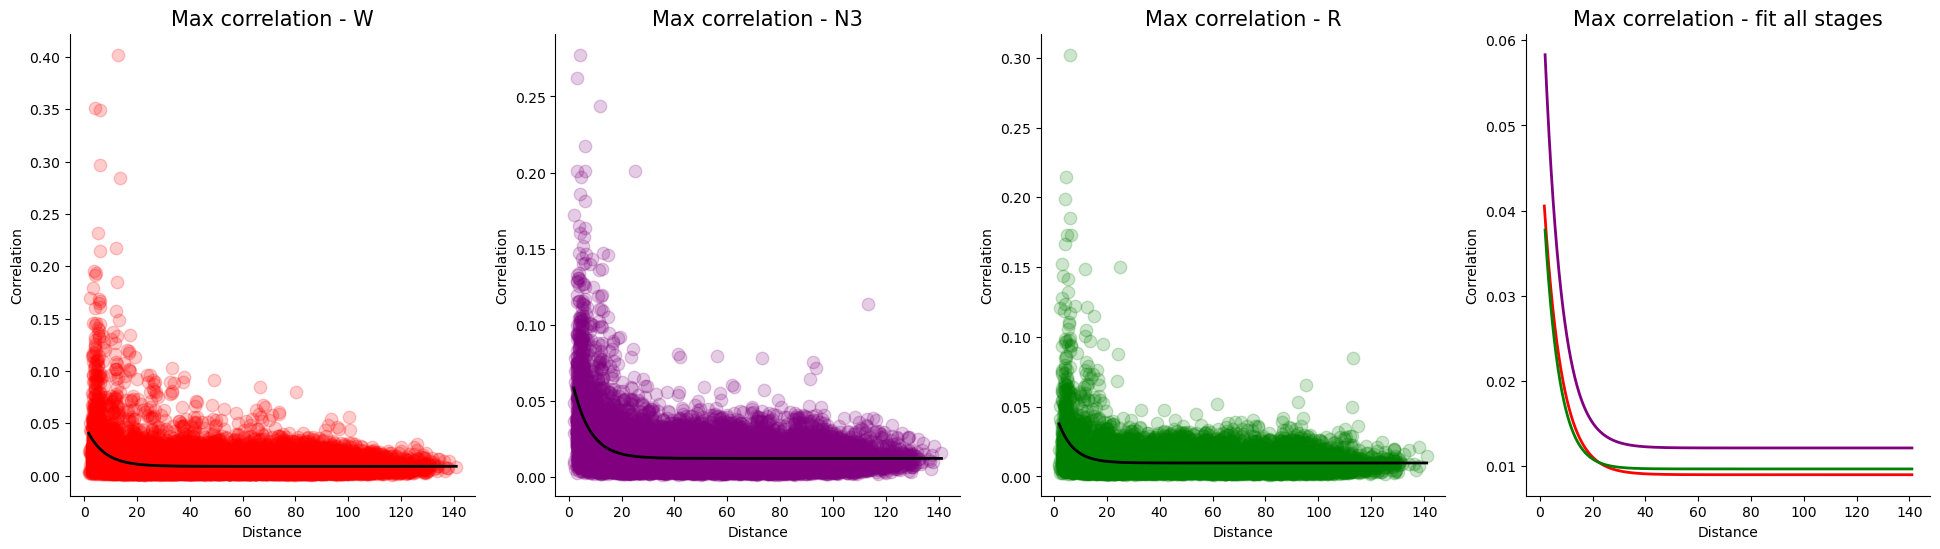

In [9]:
params_max_stages = {}
plt.figure(figsize=(24, 6))
for i, stage in enumerate(["W", "N3", "R"]):
    popt, pcov = curve_fit(
        uti._exp_decay,
        df_sc_stages[stage]["dist"],
        df_sc_stages[stage]["corr_max"],
        bounds=(([0, 0, -np.inf], [np.inf, np.inf, np.inf])),
    )
    params_max_stages[stage] = popt
    print(stage, popt)

    plt.subplot(1, 4, i + 1)
    plt.plot(
        df_sc_stages[stage]["dist"],
        df_sc_stages[stage]["corr_max"],
        "o",
        c=colors_stage[stage],
        ms=9,
        alpha=0.2,
    )
    plt.plot(
        df_sc_stages[stage]["dist"].sort_values(),
        uti._exp_decay(df_sc_stages[stage]["dist"].sort_values(), *popt),
        "-",
        c="k",
        lw=2,
        zorder=9,
    )
    plt.xlabel("Distance", fontsize=10)
    plt.ylabel("Correlation", fontsize=10)
    plt.title(f"Max correlation - {stage}", fontsize=15)
    sns.despine()
plt.subplot(1, 4, 4)
for stage in ["W", "N3", "R"]:
    plt.plot(
        df_sc_stages[stage]["dist"].sort_values(),
        uti._exp_decay(
            df_sc_stages[stage]["dist"].sort_values(), *params_max_stages[stage]
        ),
        "-",
        c=colors_stage[stage],
        lw=2,
    )
plt.xlabel("Distance", fontsize=10)
plt.ylabel("Correlation", fontsize=10)
plt.title("Max correlation - fit all stages", fontsize=15)
sns.despine()
plt.show()

W [6.53851456e+00 4.74093302e-02 3.90539698e-03]
N3 [6.63843479e+00 7.04629989e-02 5.51063562e-03]
R [6.09846037e+00 4.42654718e-02 3.88097517e-03]


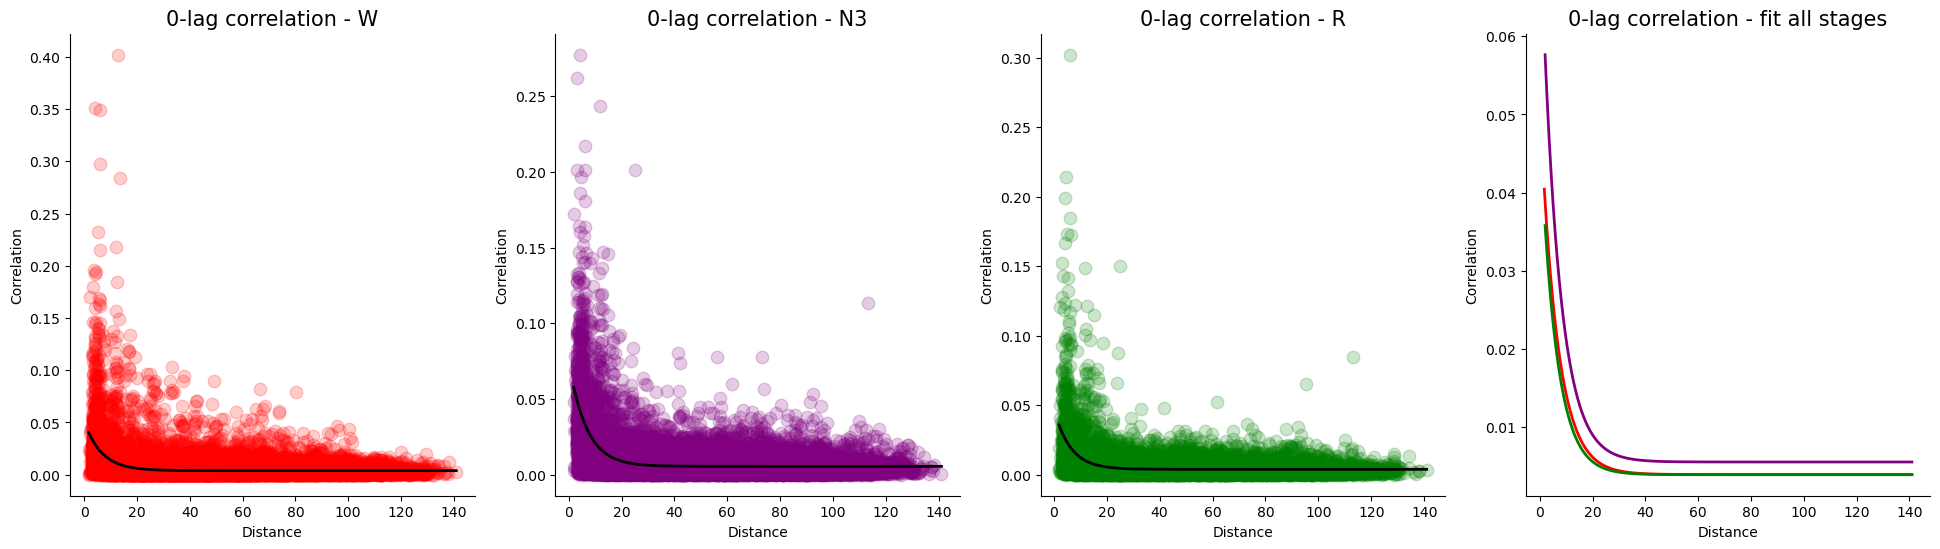

In [10]:
params_0_stages = {}
plt.figure(figsize=(24, 6))
for i, stage in enumerate(["W", "N3", "R"]):
    popt, pcov = curve_fit(
        uti._exp_decay,
        df_sc_stages[stage]["dist"],
        df_sc_stages[stage]["corr_0"].abs(),
        bounds=(([0, 0, -np.inf], [np.inf, np.inf, np.inf])),
    )
    params_0_stages[stage] = popt
    print(stage, popt)

    plt.subplot(1, 4, i + 1)
    plt.plot(
        df_sc_stages[stage]["dist"],
        df_sc_stages[stage]["corr_0"].abs(),
        "o",
        c=colors_stage[stage],
        ms=9,
        alpha=0.2,
    )
    plt.plot(
        df_sc_stages[stage]["dist"].sort_values(),
        uti._exp_decay(df_sc_stages[stage]["dist"].sort_values(), *popt),
        "-",
        c="k",
        lw=2,
        zorder=9,
    )
    plt.xlabel("Distance", fontsize=10)
    plt.ylabel("Correlation", fontsize=10)
    plt.title(f"0-lag correlation - {stage}", fontsize=15)
    sns.despine()
plt.subplot(1, 4, 4)
for stage in ["W", "N3", "R"]:
    plt.plot(
        df_sc_stages[stage]["dist"].sort_values(),
        uti._exp_decay(
            df_sc_stages[stage]["dist"].sort_values(), *params_0_stages[stage]
        ),
        "-",
        c=colors_stage[stage],
        lw=2,
    )
plt.xlabel("Distance", fontsize=10)
plt.ylabel("Correlation", fontsize=10)
plt.title("0-lag correlation - fit all stages", fontsize=15)
sns.despine()

plt.show()

Binned plot:

W [4.92967999 0.05610164 0.00902486]
N3 [5.69277535 0.07718045 0.01213327]
R [3.72223264 0.07944087 0.00960635]


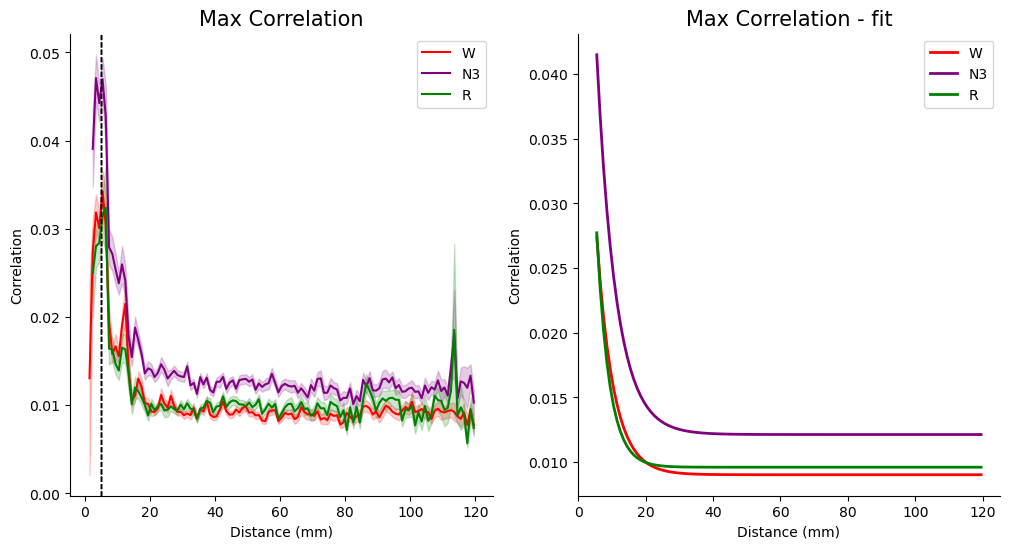

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for stage in ["W", "N3", "R"]:
    x = df_sc_bin_stages[stage]["bin"][df_sc_bin_stages[stage]["bin"] > 5]
    y = df_sc_bin_stages[stage]["corr_max"][df_sc_bin_stages[stage]["bin"] > 5]
    y_err = df_sc_bin_stages[stage]["corr_max_sem"][df_sc_bin_stages[stage]["bin"] > 5]
    popt, pcov = curve_fit(
        uti._exp_decay,
        x,
        y,
        sigma=y_err,
        bounds=(([0, 0, -np.inf], [np.inf, np.inf, np.inf])),
    )
    print(stage, popt)

    # Plot of data
    axs[0].plot(
        df_sc_bin_stages[stage]["bin"],
        df_sc_bin_stages[stage]["corr_max"],
        "-",
        c=colors_stage[stage],
        label=stage,
    )
    axs[0].fill_between(
        df_sc_bin_stages[stage]["bin"],
        df_sc_bin_stages[stage]["corr_max"] - df_sc_bin_stages[stage]["corr_max_sem"],
        df_sc_bin_stages[stage]["corr_max"] + df_sc_bin_stages[stage]["corr_max_sem"],
        color=colors_stage[stage],
        alpha=0.2,
    )
    axs[0].axvline(5, c="k", ls="--", lw=1)
    axs[0].set_xlabel("Distance (mm)", fontsize=10)
    axs[0].set_ylabel("Correlation", fontsize=10)
    axs[0].set_title("Max Correlation", fontsize=15)
    axs[0].legend()
    axs[0].spines[["top", "right"]].set_visible(False)

    # Plot of fit
    axs[1].plot(
        x, uti._exp_decay(x, *popt), "-", c=colors_stage[stage], lw=2, label=stage
    )
    axs[1].set_xlabel("Distance (mm)", fontsize=10)
    axs[1].set_ylabel("Correlation", fontsize=10)
    axs[1].set_title("Max Correlation - fit", fontsize=15)
    axs[1].legend()
    axs[1].spines[["top", "right"]].set_visible(False)

plt.show()

W [4.80919125e+00 6.80909430e-02 3.85446036e-03]
N3 [5.86089170e+00 8.42232984e-02 5.46060099e-03]
R [5.33518469e+00 4.82724592e-02 3.83251182e-03]


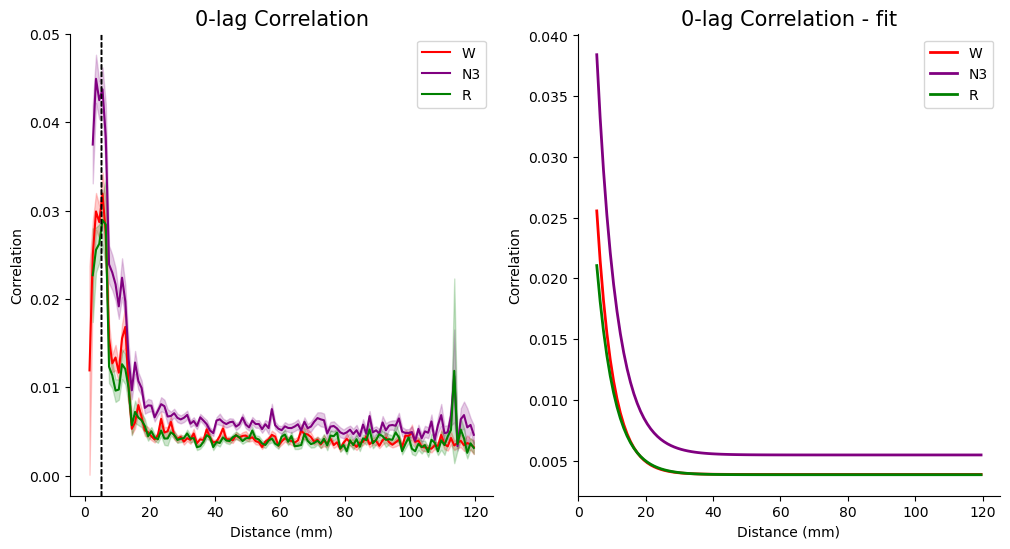

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
for stage in ["W", "N3", "R"]:
    x = df_sc_bin_stages[stage]["bin"][df_sc_bin_stages[stage]["bin"] > 5]
    y = df_sc_bin_stages[stage]["corr_0"][df_sc_bin_stages[stage]["bin"] > 5]
    y_err = df_sc_bin_stages[stage]["corr_0_sem"][df_sc_bin_stages[stage]["bin"] > 5]
    popt, pcov = curve_fit(
        uti._exp_decay,
        x,
        y,
        sigma=y_err,
        bounds=(([0, 0, -np.inf], [np.inf, np.inf, np.inf])),
    )
    print(stage, popt)

    # Plot of data
    axs[0].plot(
        df_sc_bin_stages[stage]["bin"],
        df_sc_bin_stages[stage]["corr_0"],
        "-",
        c=colors_stage[stage],
        label=stage,
    )
    axs[0].fill_between(
        df_sc_bin_stages[stage]["bin"],
        df_sc_bin_stages[stage]["corr_0"] - df_sc_bin_stages[stage]["corr_0_sem"],
        df_sc_bin_stages[stage]["corr_0"] + df_sc_bin_stages[stage]["corr_0_sem"],
        color=colors_stage[stage],
        alpha=0.2,
    )
    axs[0].axvline(5, c="k", ls="--", lw=1)
    axs[0].set_xlabel("Distance (mm)", fontsize=10)
    axs[0].set_ylabel("Correlation", fontsize=10)
    axs[0].set_title("0-lag Correlation", fontsize=15)
    axs[0].legend()
    axs[0].spines[["top", "right"]].set_visible(False)

    # Plot of fit
    axs[1].plot(
        x, uti._exp_decay(x, *popt), "-", c=colors_stage[stage], lw=2, label=stage
    )
    axs[1].set_xlabel("Distance (mm)", fontsize=10)
    axs[1].set_ylabel("Correlation", fontsize=10)
    axs[1].set_title("0-lag Correlation - fit", fontsize=15)
    axs[1].legend()
    axs[1].spines[["top", "right"]].set_visible(False)

plt.show()

Considerations for max and 0-lag correlations:
1. NREM3 mantains higher correlation at higher distances
2. Wake is more correlated at short distances than NREM3 and REM (higher "amplitude" value)
3. NREM3 has a faster decay in space than Wake and REM, unsure for Wake-REM as it depends on the binning

### Check profiles for the different lobes / regions

First, plot one figure per stage, across lobes:

W
Temporal [8.21613018 0.03794797 0.009255  ]
Frontal [5.92940603 0.04504817 0.00939202]
Insula [4.43181792 0.05116337 0.00938203]
Occipital [7.18737284e+00 4.15519099e-02 6.89194097e-03]
Parietal [6.44688146 0.03649411 0.00788874]


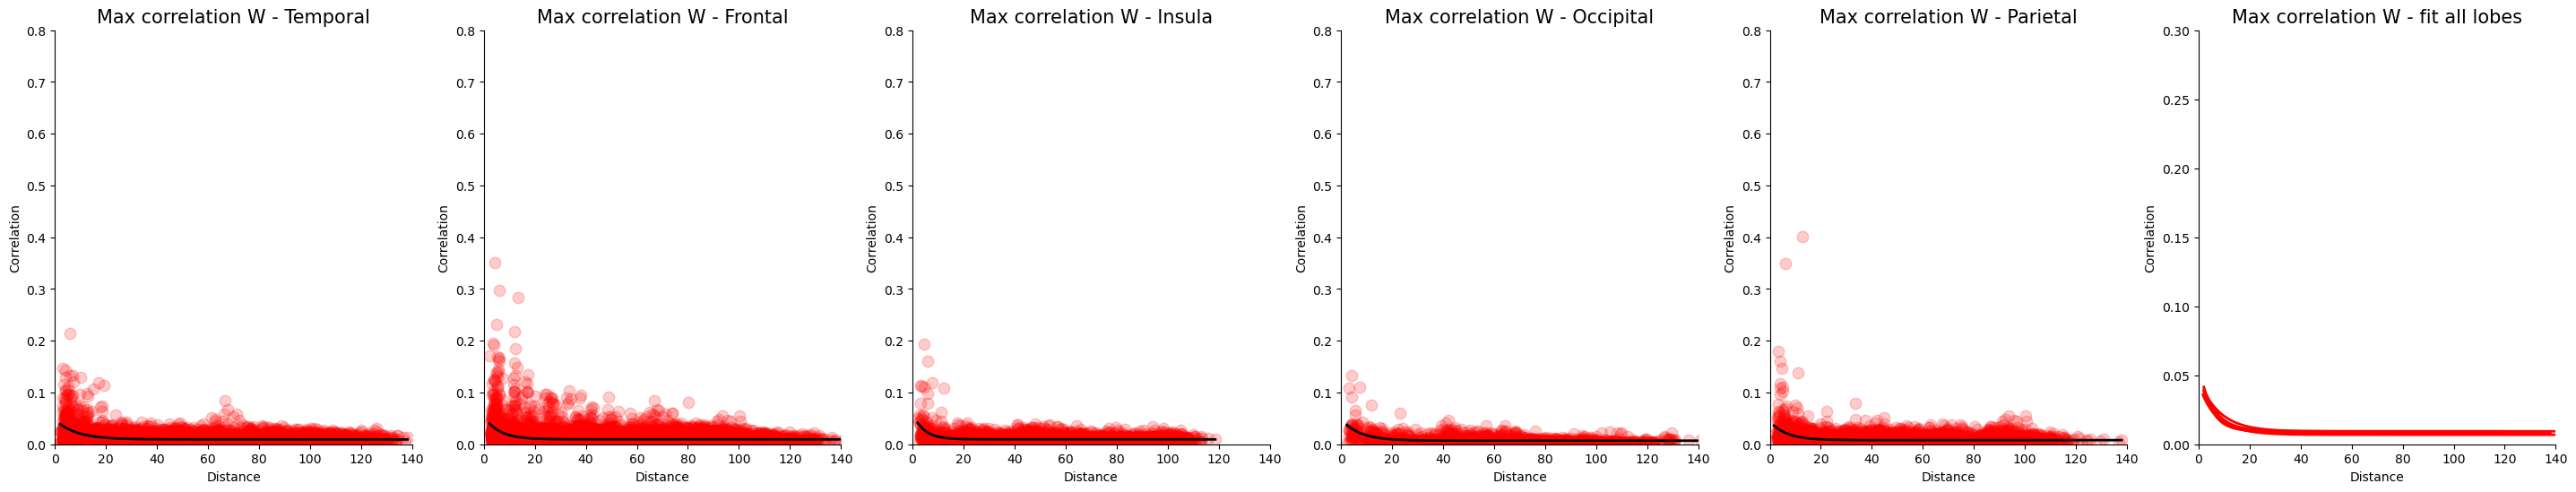

N3
Frontal [5.89930199 0.06356461 0.01212385]
Insula [6.50331195 0.05469916 0.01231513]
Temporal [7.28153783 0.05979734 0.01255123]
Occipital [1.05408060e+01 6.59685691e-02 8.95762145e-03]
Parietal [5.27175922 0.07889076 0.01260111]


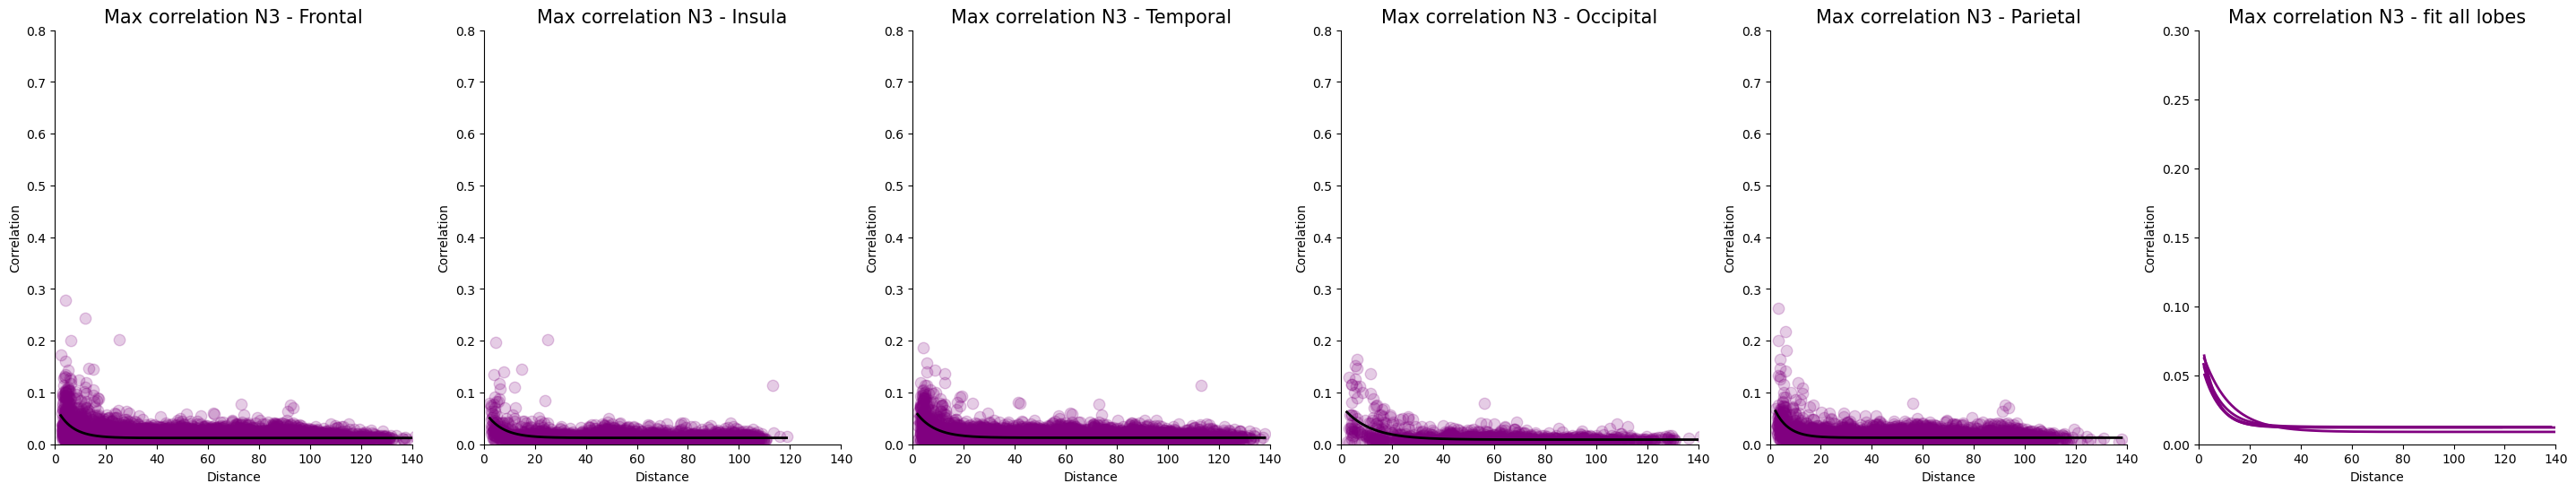

R
Frontal [4.80933094 0.04541872 0.00961264]
Parietal [3.78106816 0.04783153 0.00988631]
Temporal [6.61304621 0.03298892 0.01026386]
Occipital [9.45039765e+00 4.30729089e-02 8.08684641e-03]
Insula [8.85801995 0.03751924 0.01043022]


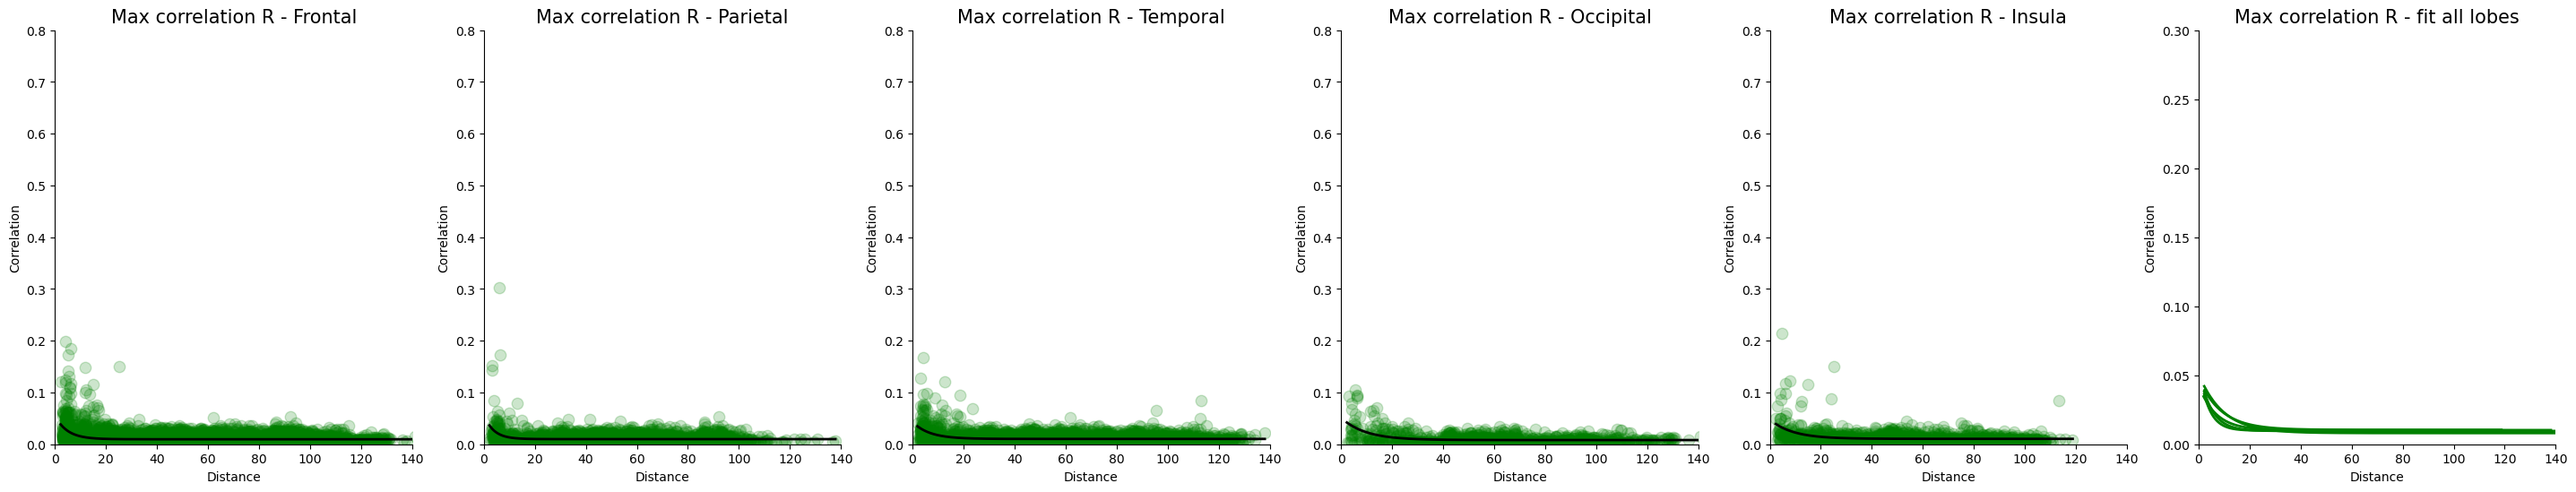

In [13]:
for stage in ["W", "N3", "R"]:
    print(stage)
    df_sc_stage = df_sc_stages[stage]
    # params_max_lobes = {}
    fig, axs = plt.subplots(1, 6, figsize=(36, 6))

    for i, lobe in enumerate(df_sc_stage["lobe1"].unique()):
        df_sc_stage_lobe = df_sc_stage[
            (df_sc_stage["lobe1"] == lobe) | (df_sc_stage["lobe2"] == lobe)
        ]
        popt, pcov = curve_fit(
            uti._exp_decay,
            df_sc_stage_lobe["dist"],
            df_sc_stage_lobe["corr_max"],
            bounds=(([0, 0, -np.inf], [np.inf, np.inf, np.inf])),
        )
        # params_max_lobes[lobe] = popt
        print(lobe, popt)

        # Plot of data
        axs[i].plot(
            df_sc_stage_lobe["dist"],
            df_sc_stage_lobe["corr_max"],
            "o",
            c=colors_stage[stage],
            ms=9,
            alpha=0.2,
        )
        axs[i].plot(
            df_sc_stage_lobe["dist"].sort_values(),
            uti._exp_decay(df_sc_stage_lobe["dist"].sort_values(), *popt),
            "-",
            c="k",
            lw=2,
            zorder=9,
        )
        axs[i].set_ylim(0, 0.8)
        axs[i].set_xlim(0, 140)
        axs[i].set_xlabel("Distance", fontsize=10)
        axs[i].set_ylabel("Correlation", fontsize=10)
        axs[i].set_title(f"Max correlation {stage} - {lobe}", fontsize=15)
        axs[i].spines[["top", "right"]].set_visible(False)

        # Plot of fit
        axs[-1].plot(
            df_sc_stage_lobe["dist"].sort_values(),
            uti._exp_decay(df_sc_stage_lobe["dist"].sort_values(), *popt),
            "-",
            c=colors_stage[stage],
            lw=2,
        )
        axs[-1].set_ylim(0, 0.3)
        axs[-1].set_xlim(0, 140)
        axs[-1].set_xlabel("Distance", fontsize=10)
        axs[-1].set_ylabel("Correlation", fontsize=10)
        axs[-1].set_title(f"Max correlation {stage} - fit all lobes", fontsize=15)
        # sns.despine(fig, axs[-1])
        axs[-1].spines[["top", "right"]].set_visible(False)
    plt.show()

Differences:
1. Occipital lobe has the slowest decay and lowest SC at higher distances across stages; Parietal has the fastest decay across stages.
2. Wake and REM are generally more similar than NREM3.
3. Frontal is quite correlated at higher distances.

Second, plot one figure per lobe, across stages:

Frontal
W [5.92940603 0.04504817 0.00939202]
N3 [5.89930199 0.06356461 0.01212385]
R [4.80933094 0.04541872 0.00961264]


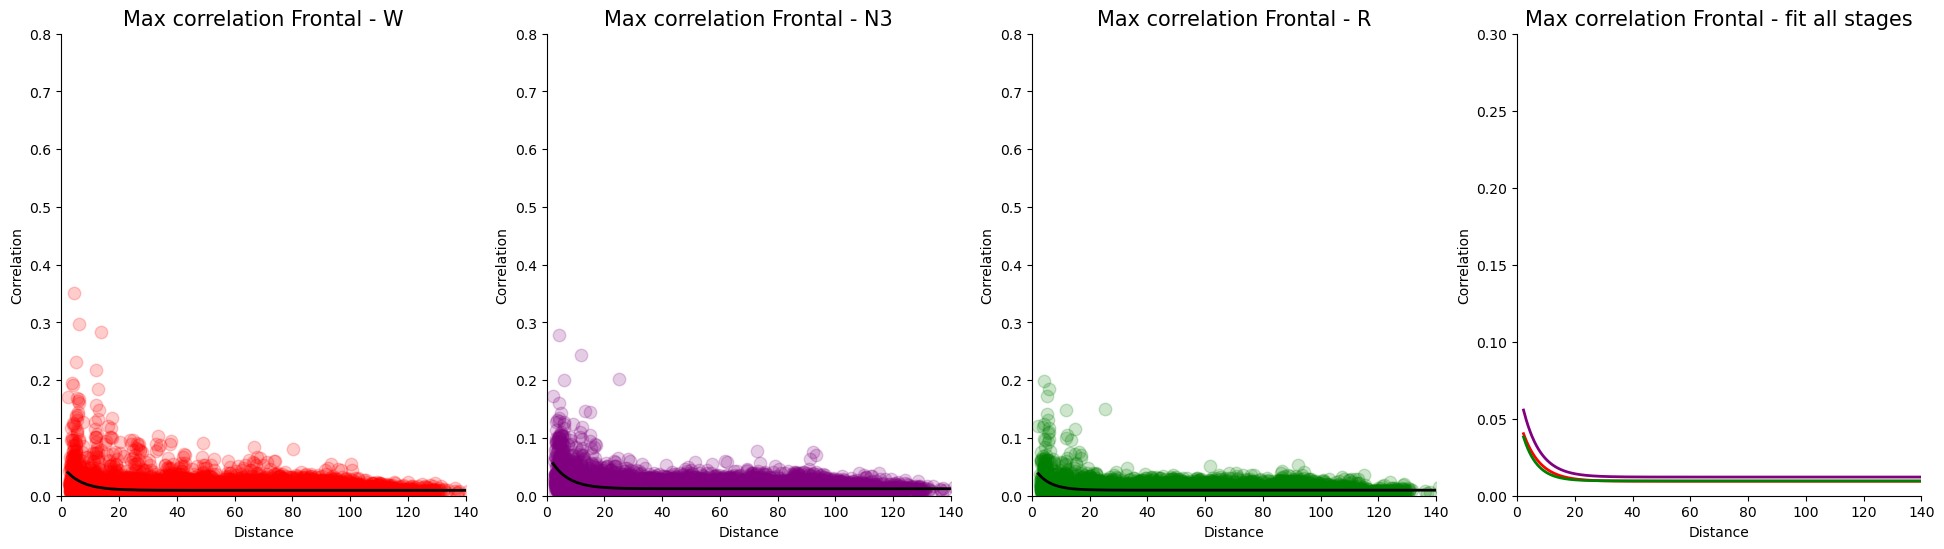

Parietal
W [6.44688146 0.03649411 0.00788874]
N3 [5.27175922 0.07889076 0.01260111]
R [3.78106816 0.04783153 0.00988631]


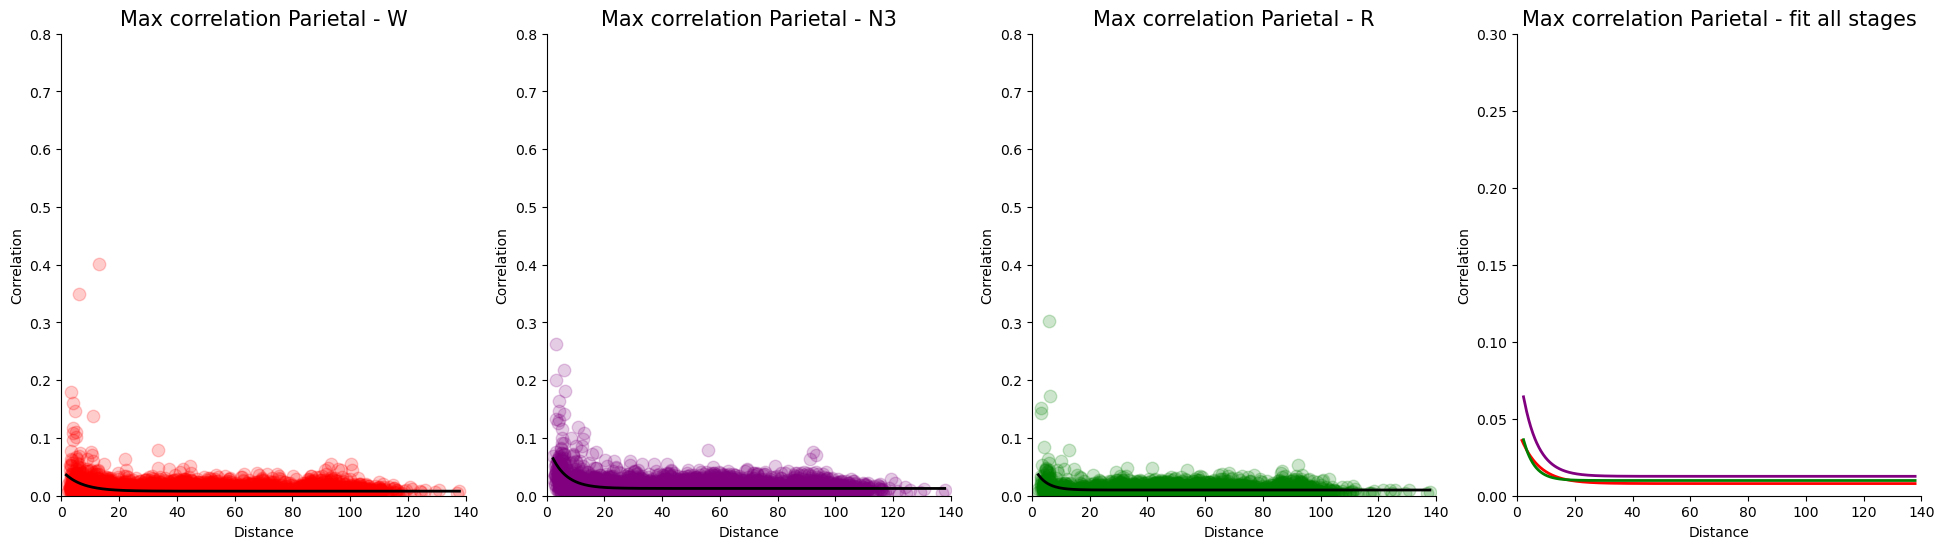

Temporal
W [8.21613018 0.03794797 0.009255  ]
N3 [7.28153783 0.05979734 0.01255123]
R [6.61304621 0.03298892 0.01026386]


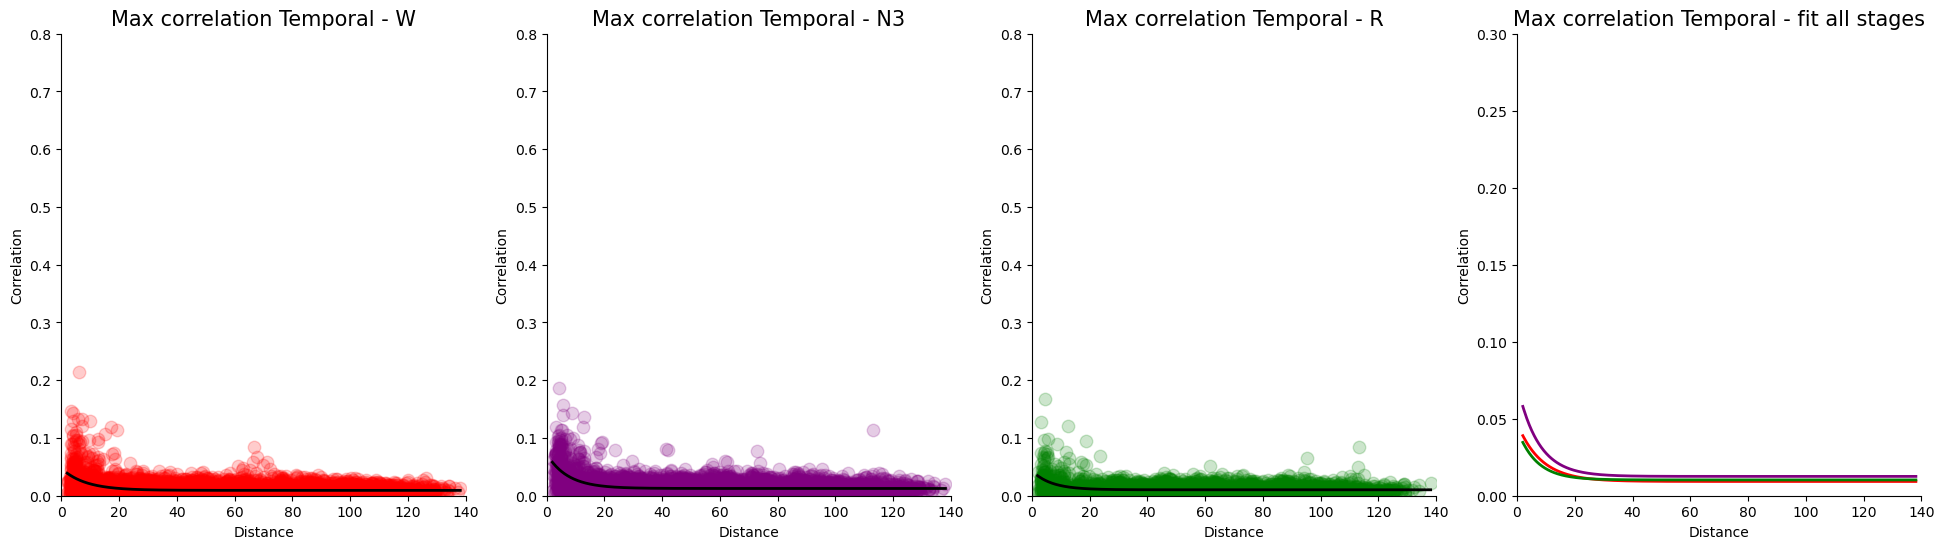

Occipital
W [7.18737284e+00 4.15519099e-02 6.89194097e-03]
N3 [1.05408060e+01 6.59685691e-02 8.95762145e-03]
R [9.45039765e+00 4.30729089e-02 8.08684641e-03]


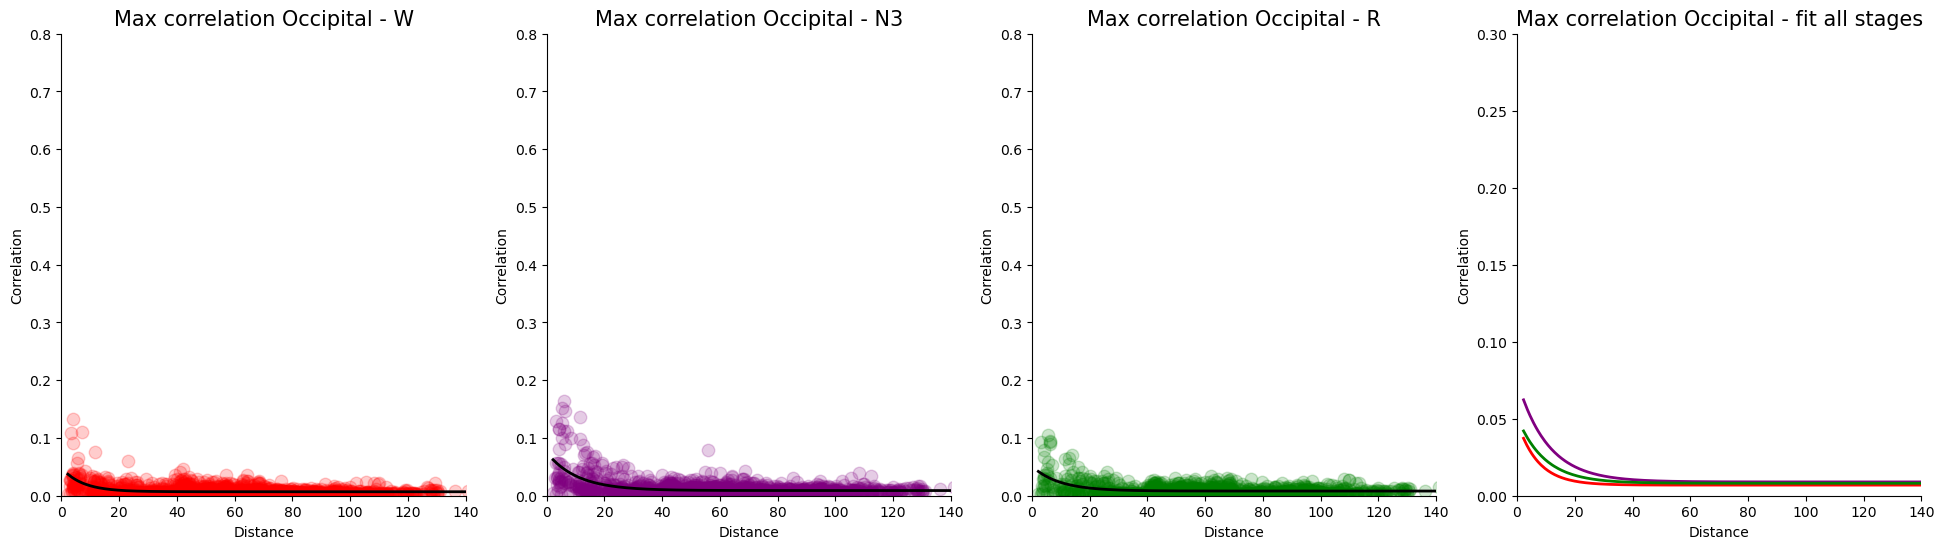

Insula
W [4.43181792 0.05116337 0.00938203]
N3 [6.50331195 0.05469916 0.01231513]
R [8.85801995 0.03751924 0.01043022]


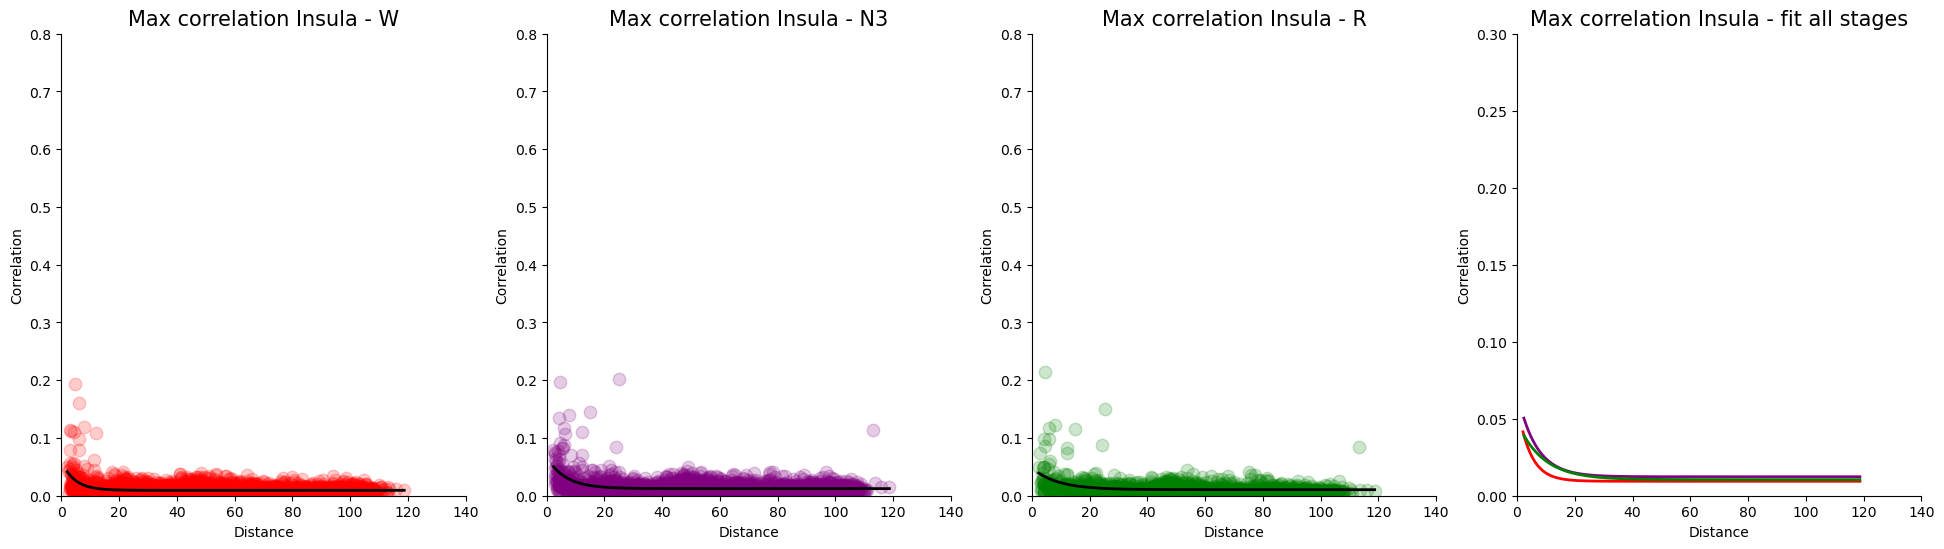

In [14]:
for lobe in df_sc_stage["lobe1"].unique():
    print(lobe)

    df_sc_lobe = df_sc_stages[stage]
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    for i, stage in enumerate(["W", "N3", "R"]):
        df_sc_stage_lobe = df_sc_stages[stage][
            (df_sc_stages[stage]["lobe1"] == lobe)
            | (df_sc_stages[stage]["lobe2"] == lobe)
        ]
        popt, pcov = curve_fit(
            uti._exp_decay,
            df_sc_stage_lobe["dist"],
            df_sc_stage_lobe["corr_max"],
            bounds=(([0, 0, -np.inf], [np.inf, np.inf, np.inf])),
        )
        print(stage, popt)

        # Plot of data
        axs[i].plot(
            df_sc_stage_lobe["dist"],
            df_sc_stage_lobe["corr_max"],
            "o",
            c=colors_stage[stage],
            ms=9,
            alpha=0.2,
        )
        axs[i].plot(
            df_sc_stage_lobe["dist"].sort_values(),
            uti._exp_decay(df_sc_stage_lobe["dist"].sort_values(), *popt),
            "-",
            c="k",
            lw=2,
            zorder=9,
        )
        axs[i].set_ylim(0, 0.8)
        axs[i].set_xlim(0, 140)
        axs[i].set_xlabel("Distance", fontsize=10)
        axs[i].set_ylabel("Correlation", fontsize=10)
        axs[i].set_title(f"Max correlation {lobe} - {stage}", fontsize=15)
        axs[i].spines[["top", "right"]].set_visible(False)

        # Plot of fit
        axs[-1].plot(
            df_sc_stage_lobe["dist"].sort_values(),
            uti._exp_decay(df_sc_stage_lobe["dist"].sort_values(), *popt),
            "-",
            c=colors_stage[stage],
            lw=2,
        )
        axs[-1].set_ylim(0, 0.3)
        axs[-1].set_xlim(0, 140)
        axs[-1].set_xlabel("Distance", fontsize=10)
        axs[-1].set_ylabel("Correlation", fontsize=10)
        axs[-1].set_title(f"Max correlation {lobe} - fit all stages", fontsize=15)
        axs[-1].spines[["top", "right"]].set_visible(False)
    plt.show()

Differences across lobes:
1. NREM3 higher correlation not strong for Occipital and Insula electrodes (but these are the lobes with also less electrodes); the effect is stronger for Frontal and Parietal electrodes.
2. The decay rate is also faster in NREM3 (compared to Wake) for Frontal, Parietal and Temporal electrodes and the opposite for Occipital/Insula.

### Plot one figure per brain region:

Middle temporal gyrus
W [9.05747247 0.0553831  0.01004554]
N3 [8.87910292 0.07099543 0.01328217]
R [1.26754512e+01 3.63740957e-02 9.74564648e-03]


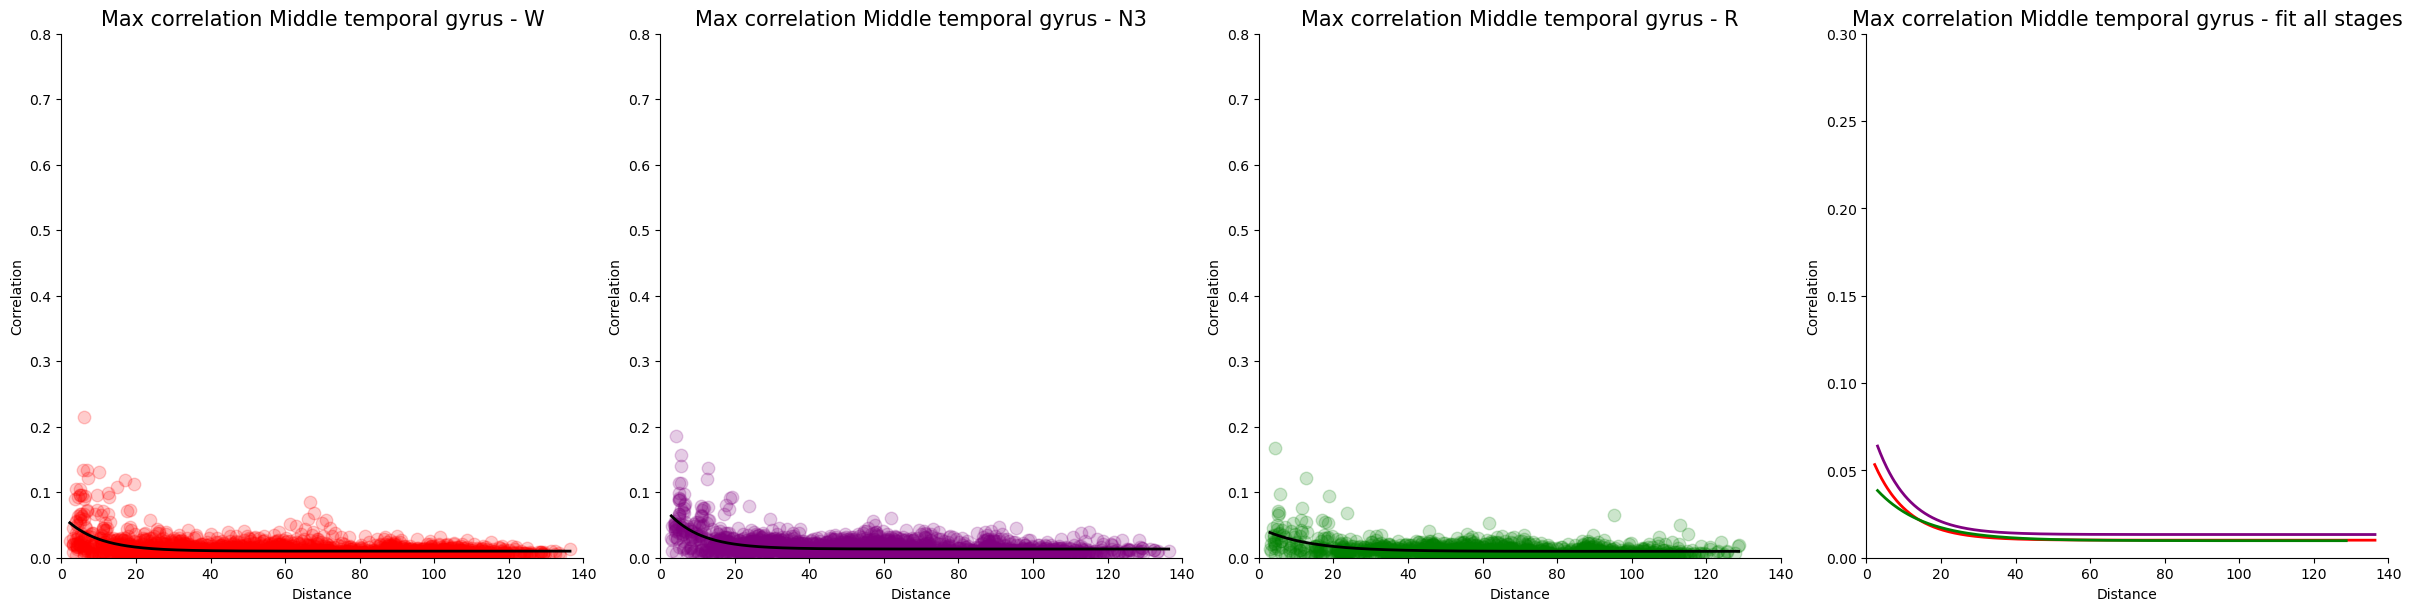

Medial frontal cortex
W [4.22623779 0.04163341 0.01402741]
N3 [1.98161912 0.16384461 0.01623354]
R [5.64070245 0.02594659 0.01519458]


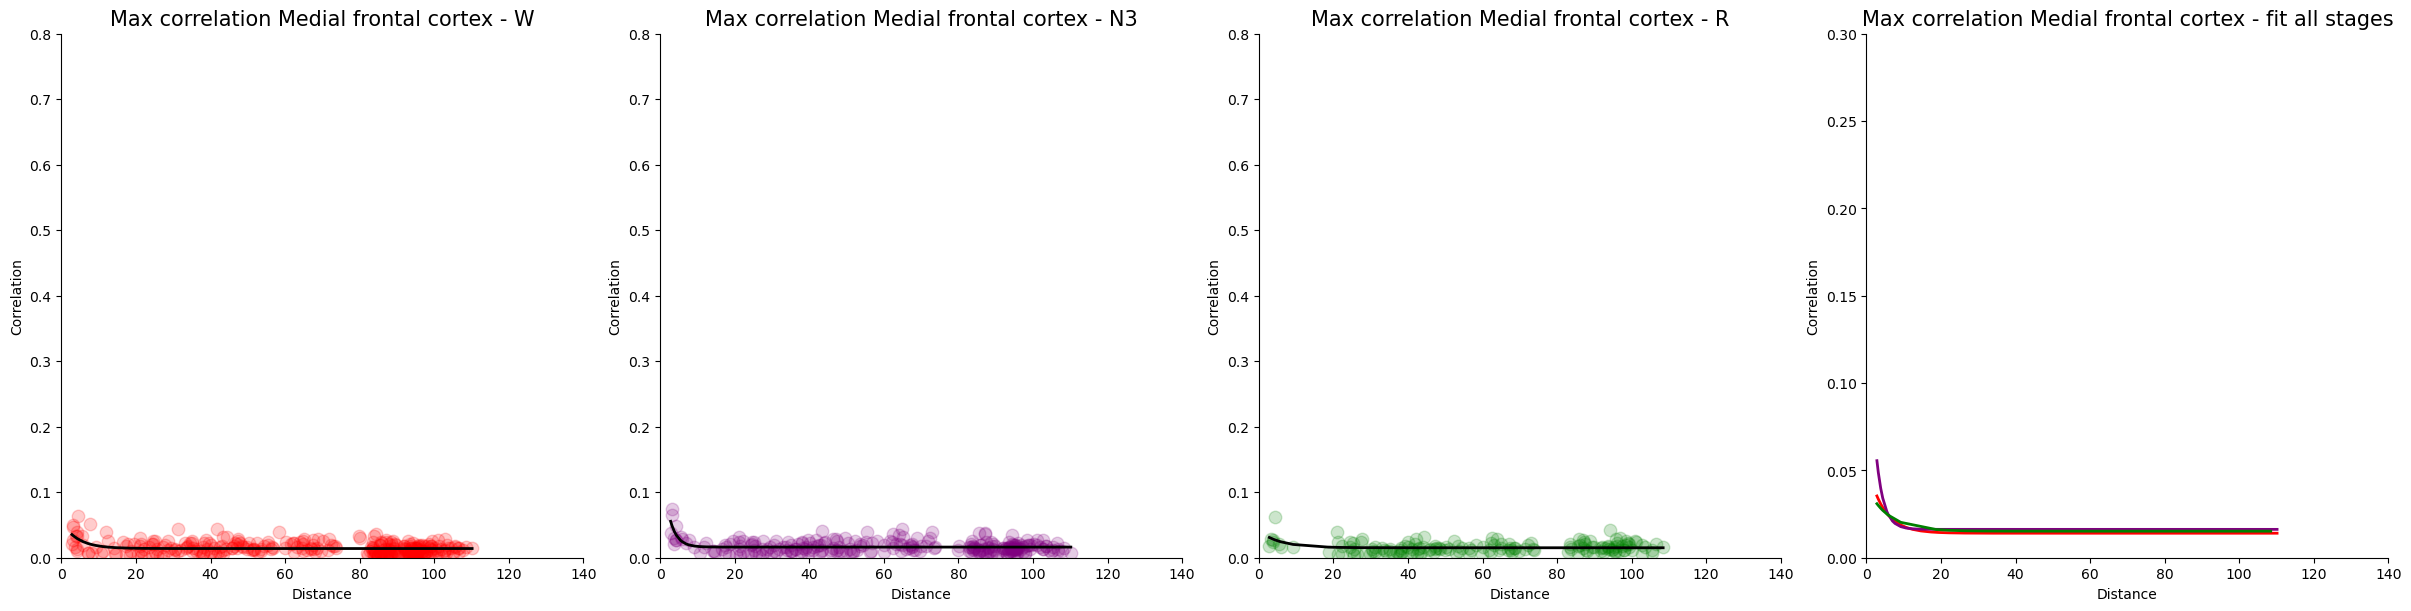

Planum temporale
W [9.03278052e+00 2.74510309e-02 8.73695504e-03]
N3 [5.41849629 0.0678501  0.01256016]
R [0.89046682 1.         0.00940826]


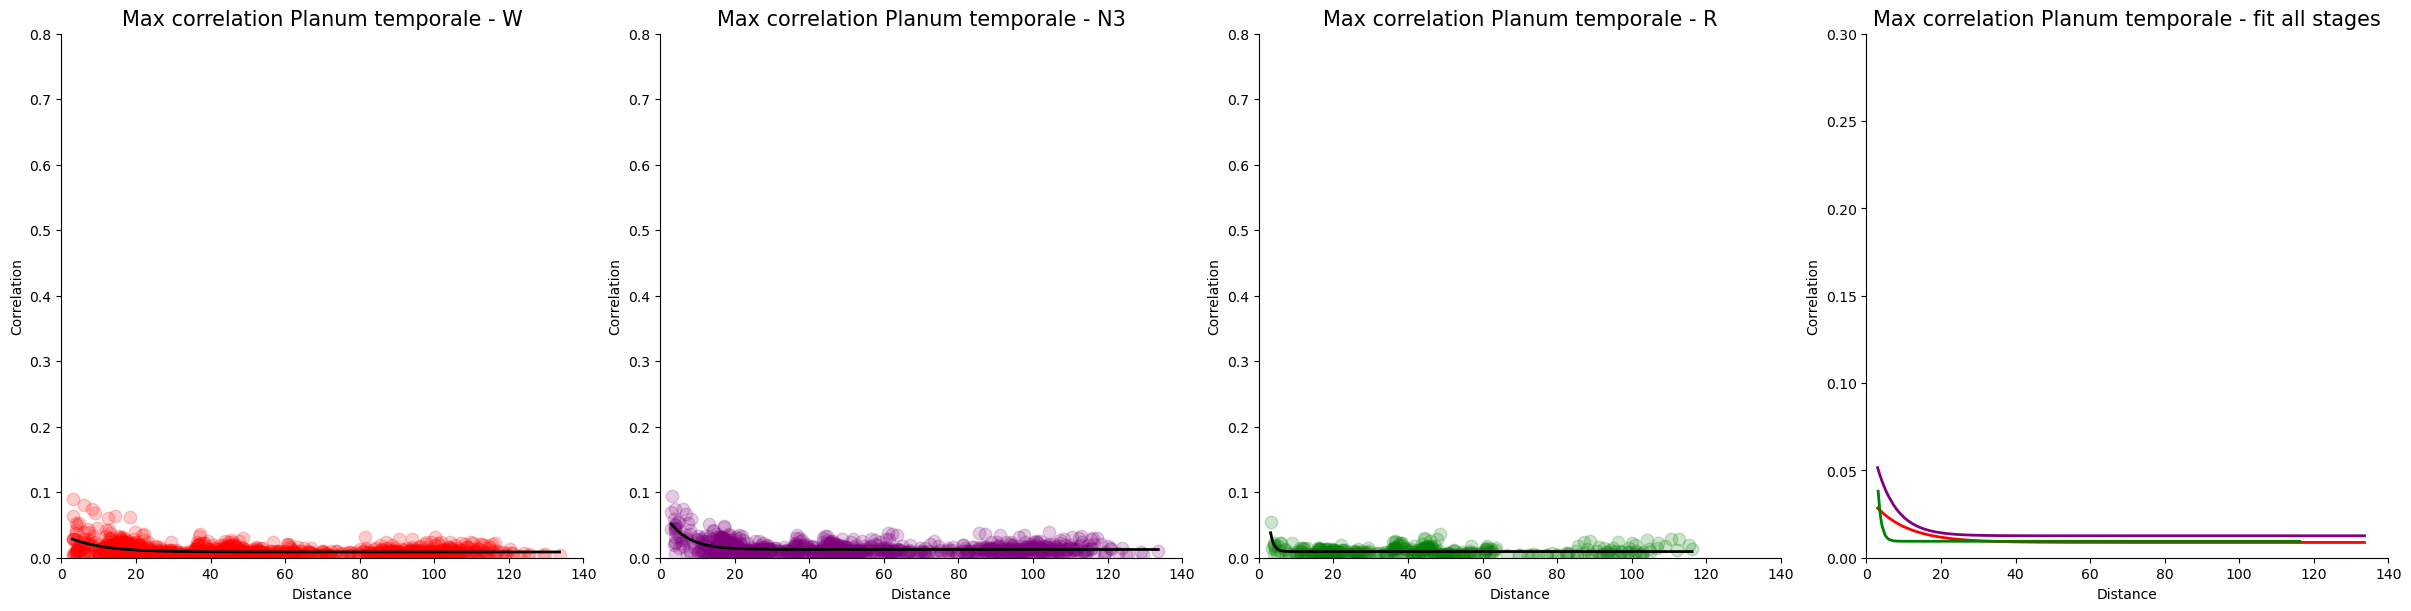

Middle cingulate
W [6.18506822 0.06491712 0.0102997 ]
N3 [8.19883583 0.05146586 0.01355518]
R [6.79009556 0.05499009 0.01112588]


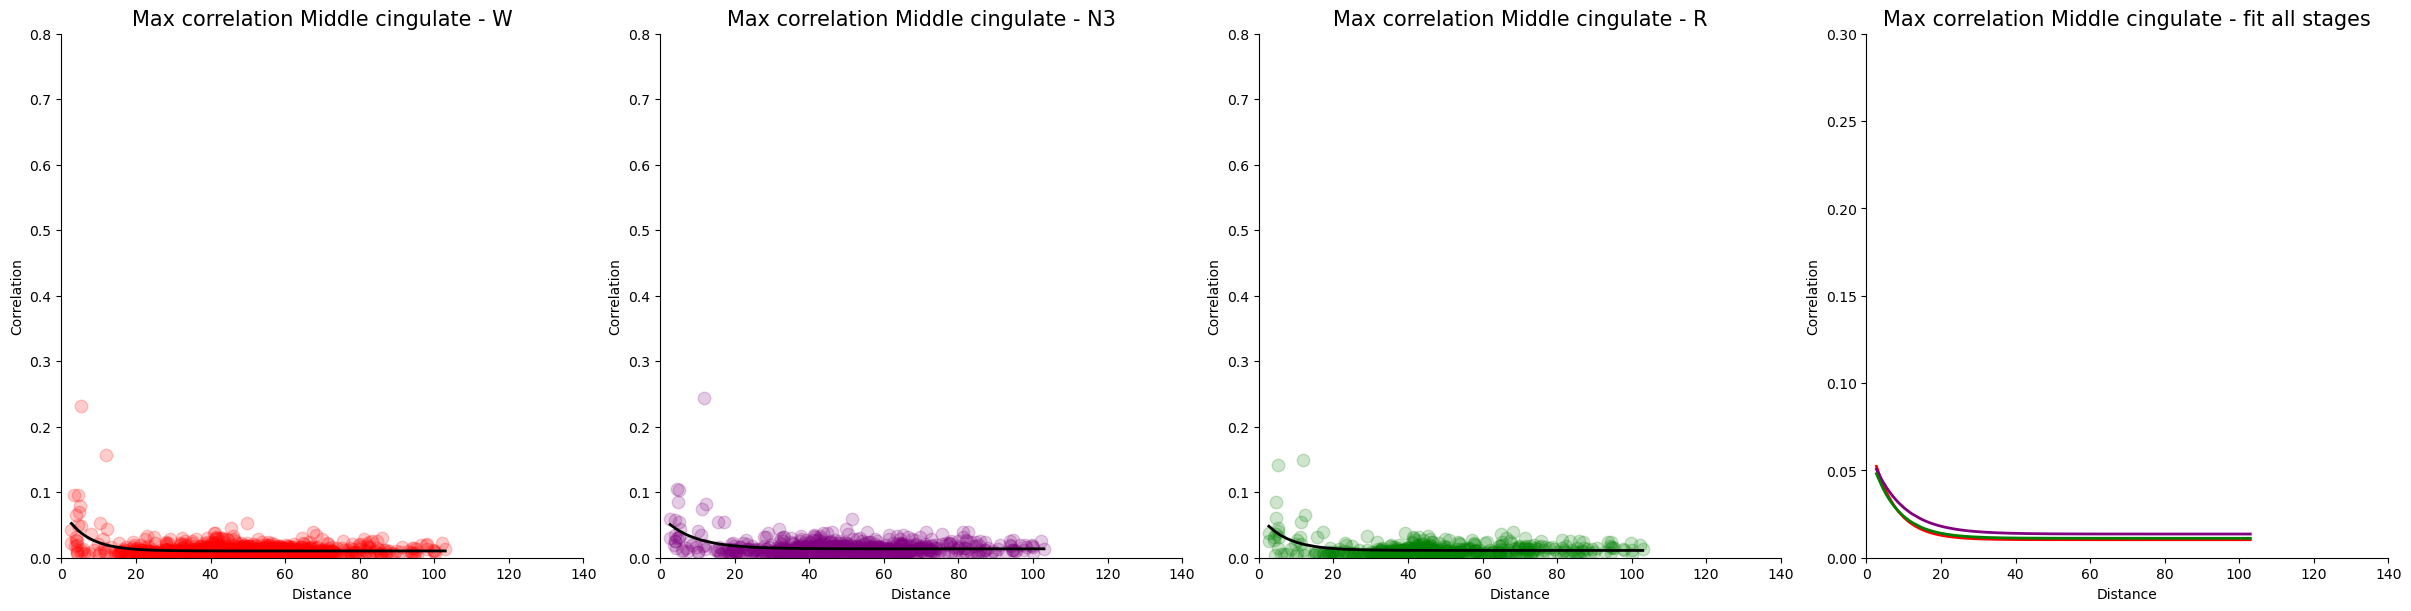

Precentral gyrus
W [4.60399634 0.04370224 0.00672784]
N3 [5.19436163 0.05771638 0.01051813]
R [3.32605554 0.05788918 0.00783449]


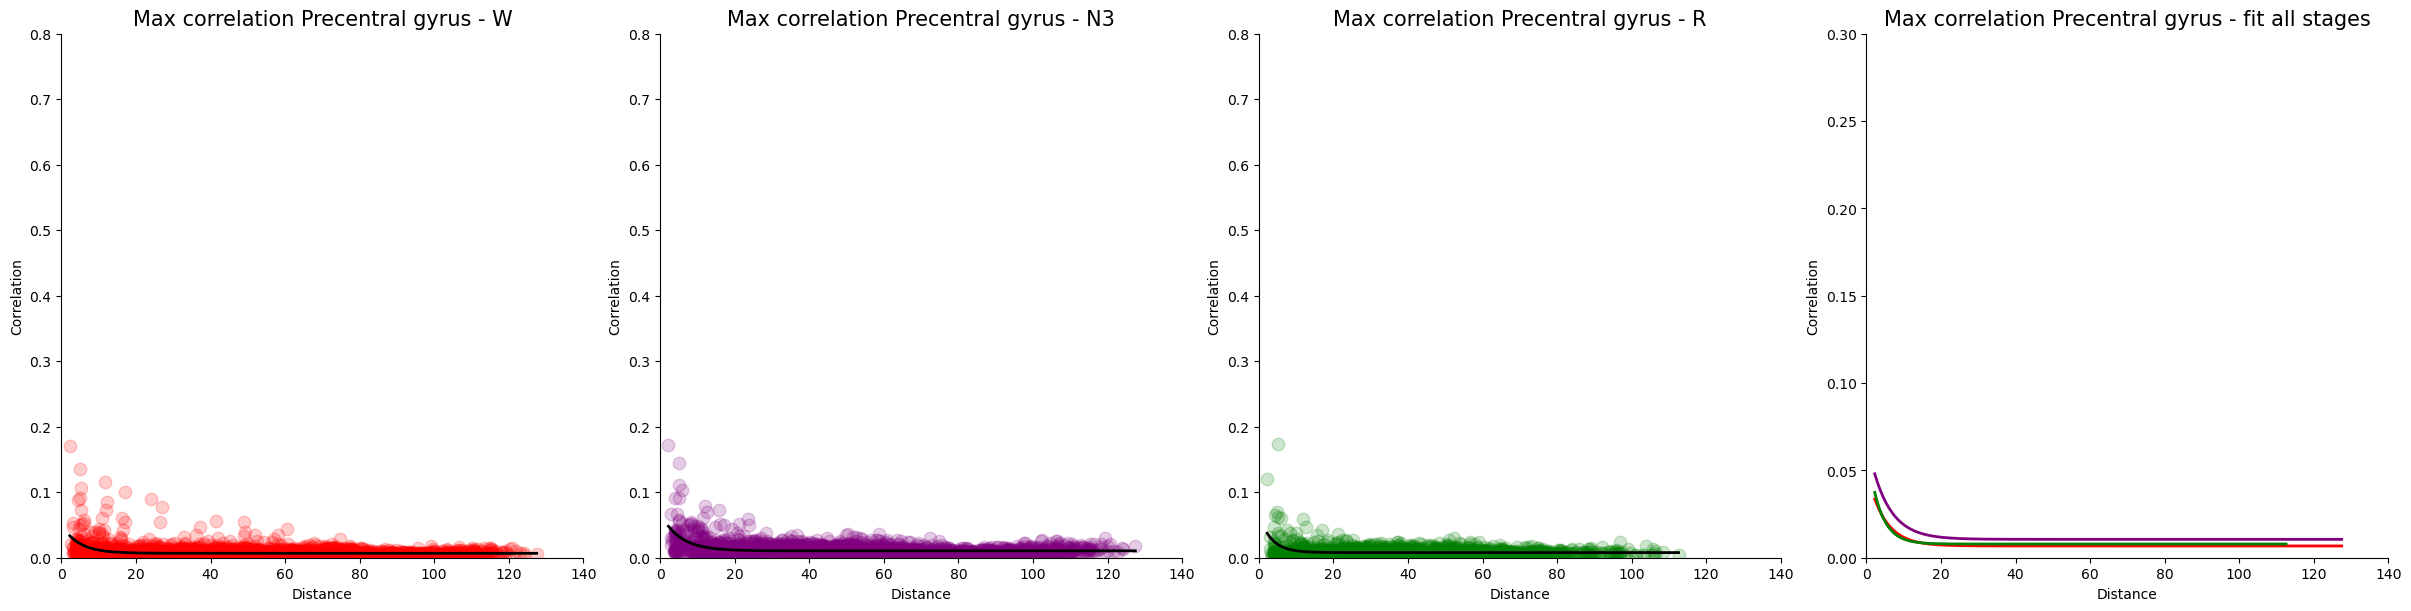

Supplementary motor cortex
W [4.3685474  0.05054989 0.00859773]
N3 [4.48228778 0.07641112 0.01147542]
R [2.56391612 0.11623463 0.00864425]


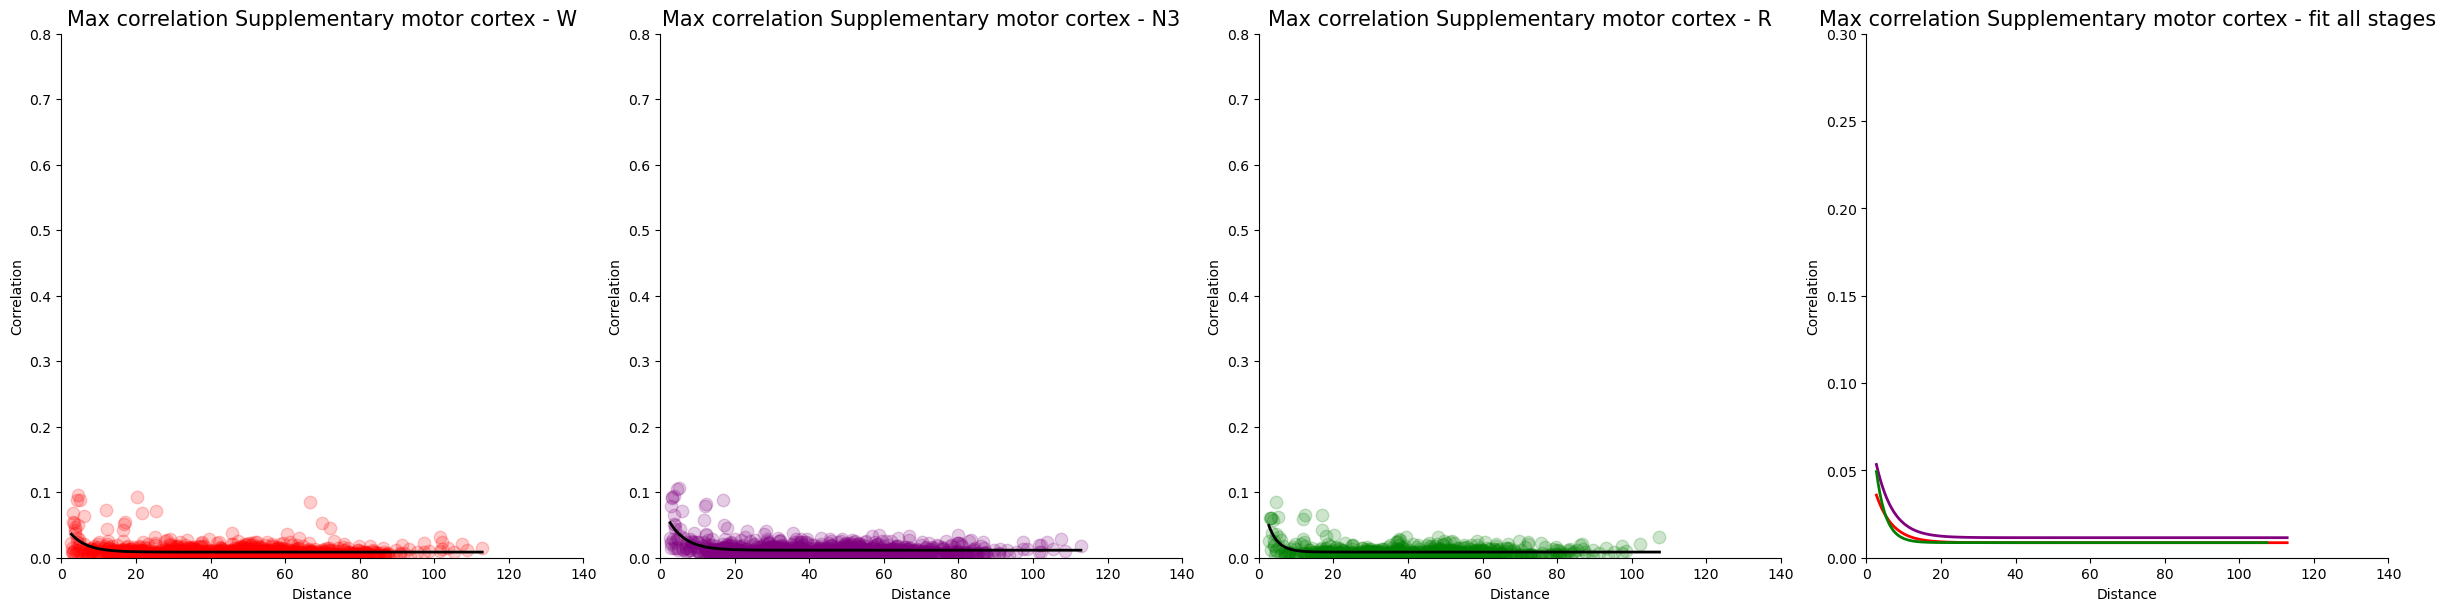

Anterior insula
W [5.36378761 0.04624692 0.00911724]
N3 [8.1118677  0.04599156 0.01138973]
R [8.69664184 0.03945356 0.00989735]


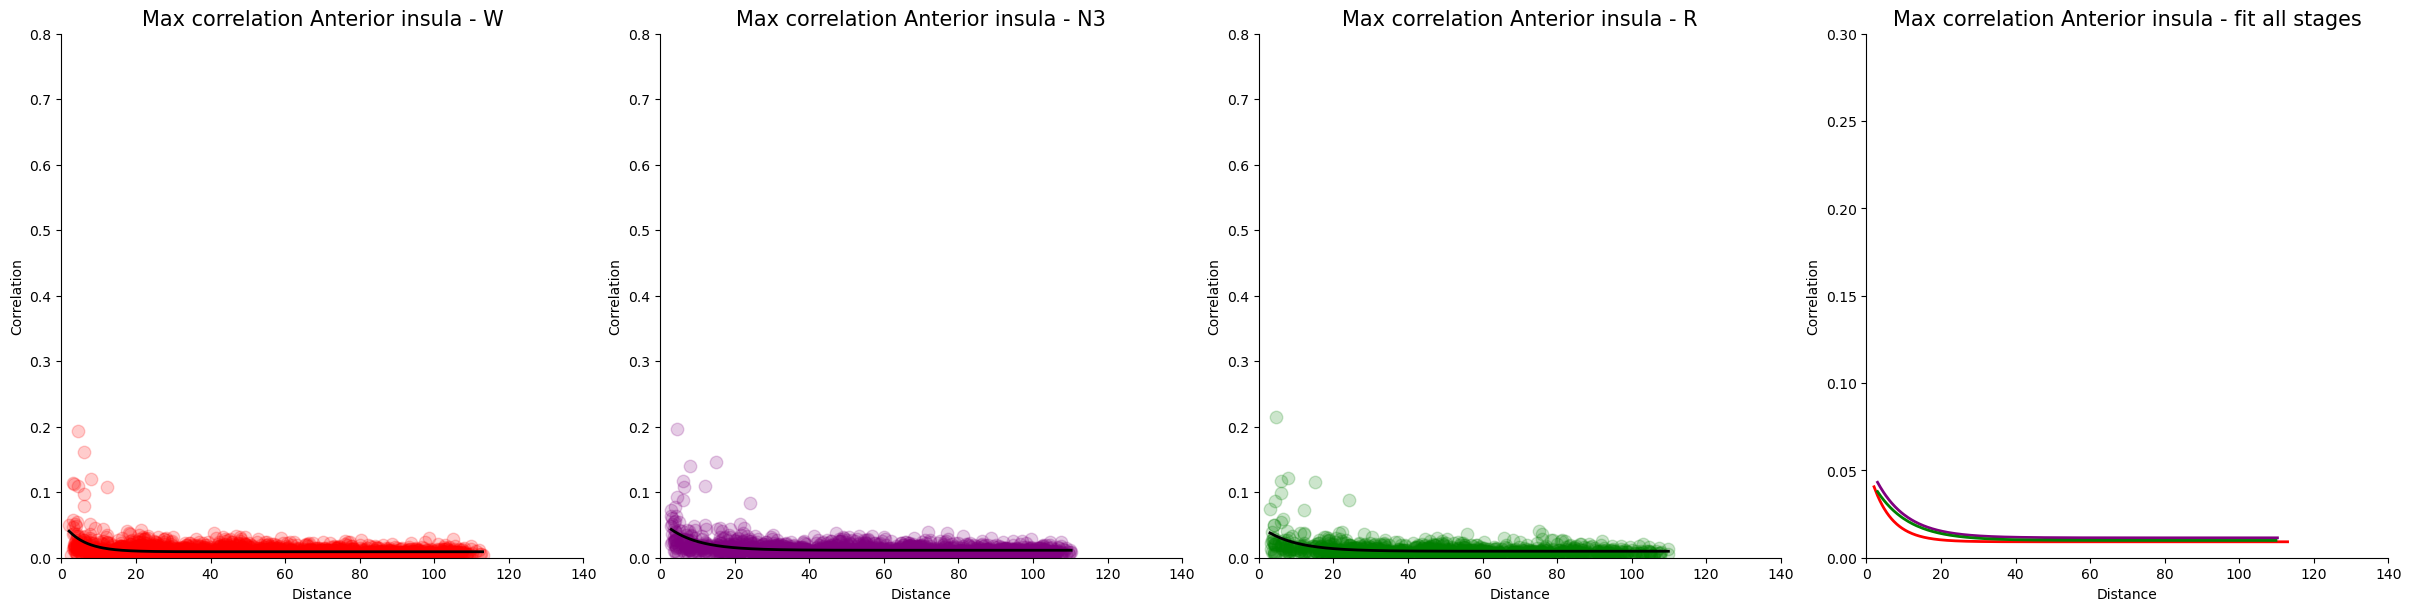

Temporal pole and planum polare
W [5.10189935 0.06240431 0.01044319]
N3 [8.19623923 0.07438236 0.01298777]
R [1.91976383e+01 3.40796657e-02 8.65374245e-03]


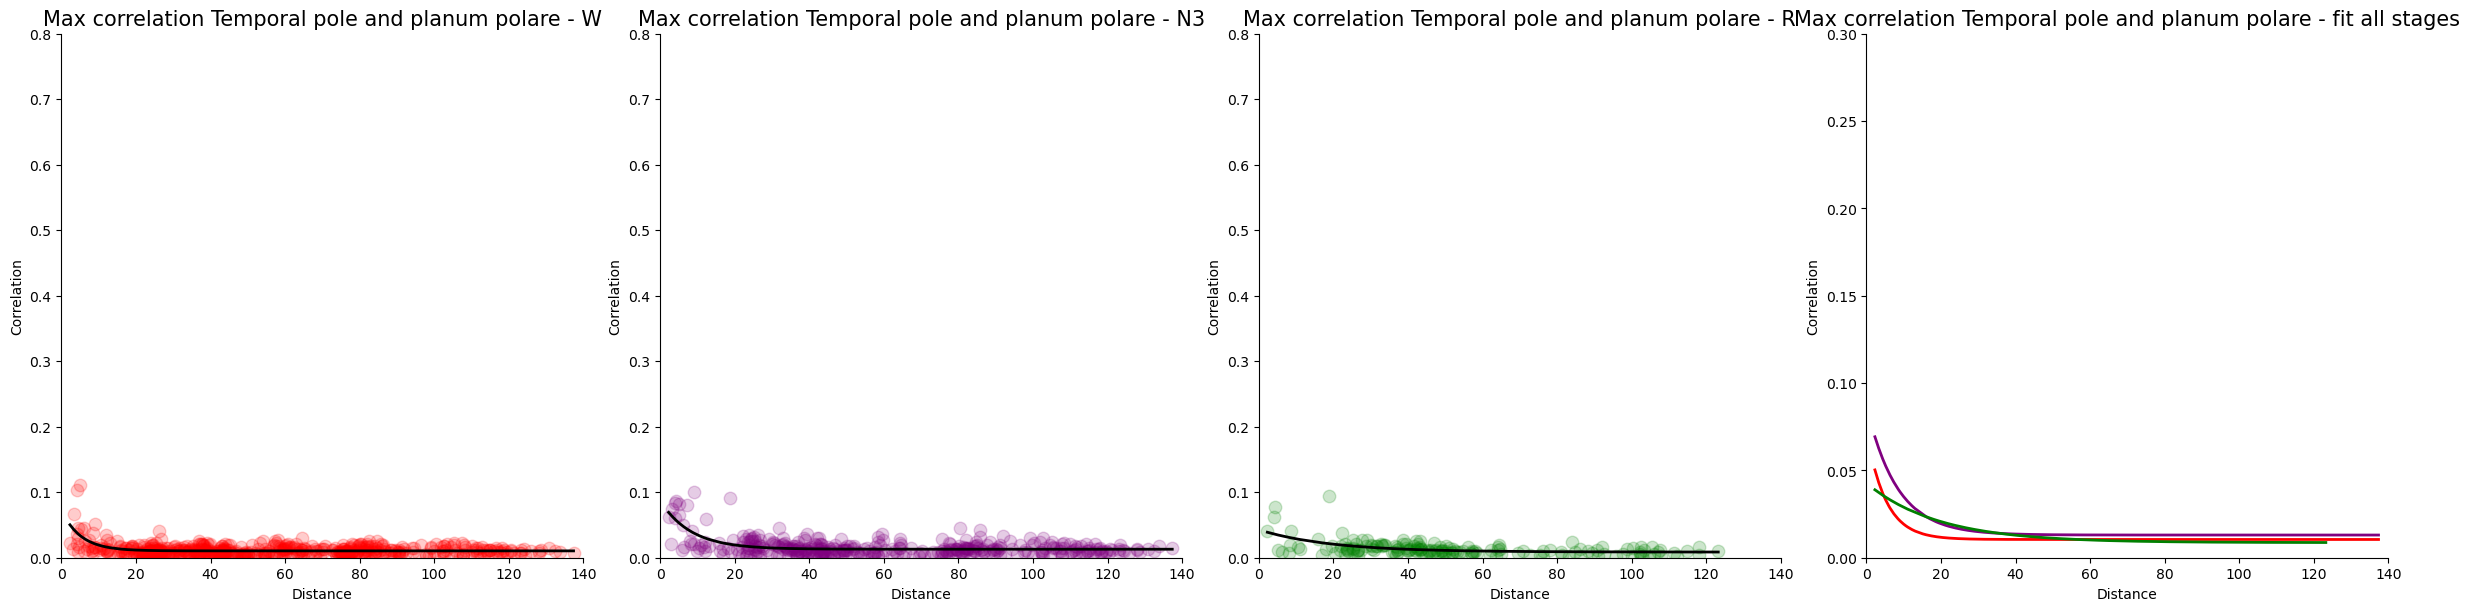

Hippocampus
W [8.64519328e+01 1.18282840e-02 4.74634645e-04]
N3 [3.67854980e+01 1.73284742e-02 4.68192346e-03]
R [1.00000000e+02 9.85573518e-03 8.66265507e-04]


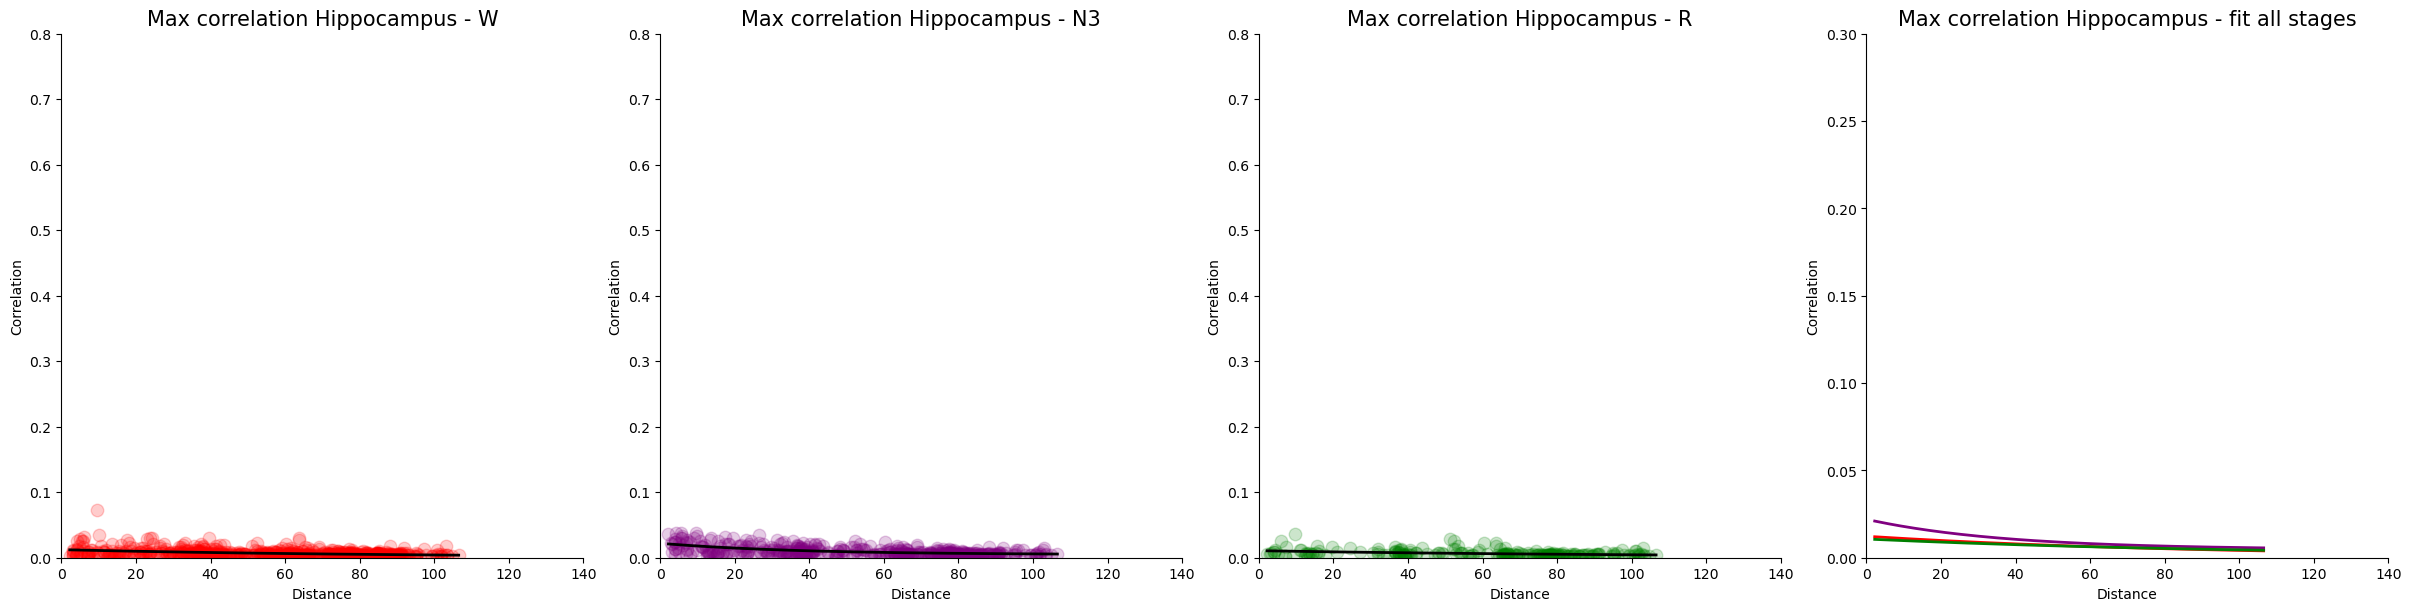

Central operculum
W [4.4120994  0.06711338 0.0110667 ]
N3 [4.87516975 0.07498015 0.01337137]
R [4.01978753 0.06785116 0.00998556]


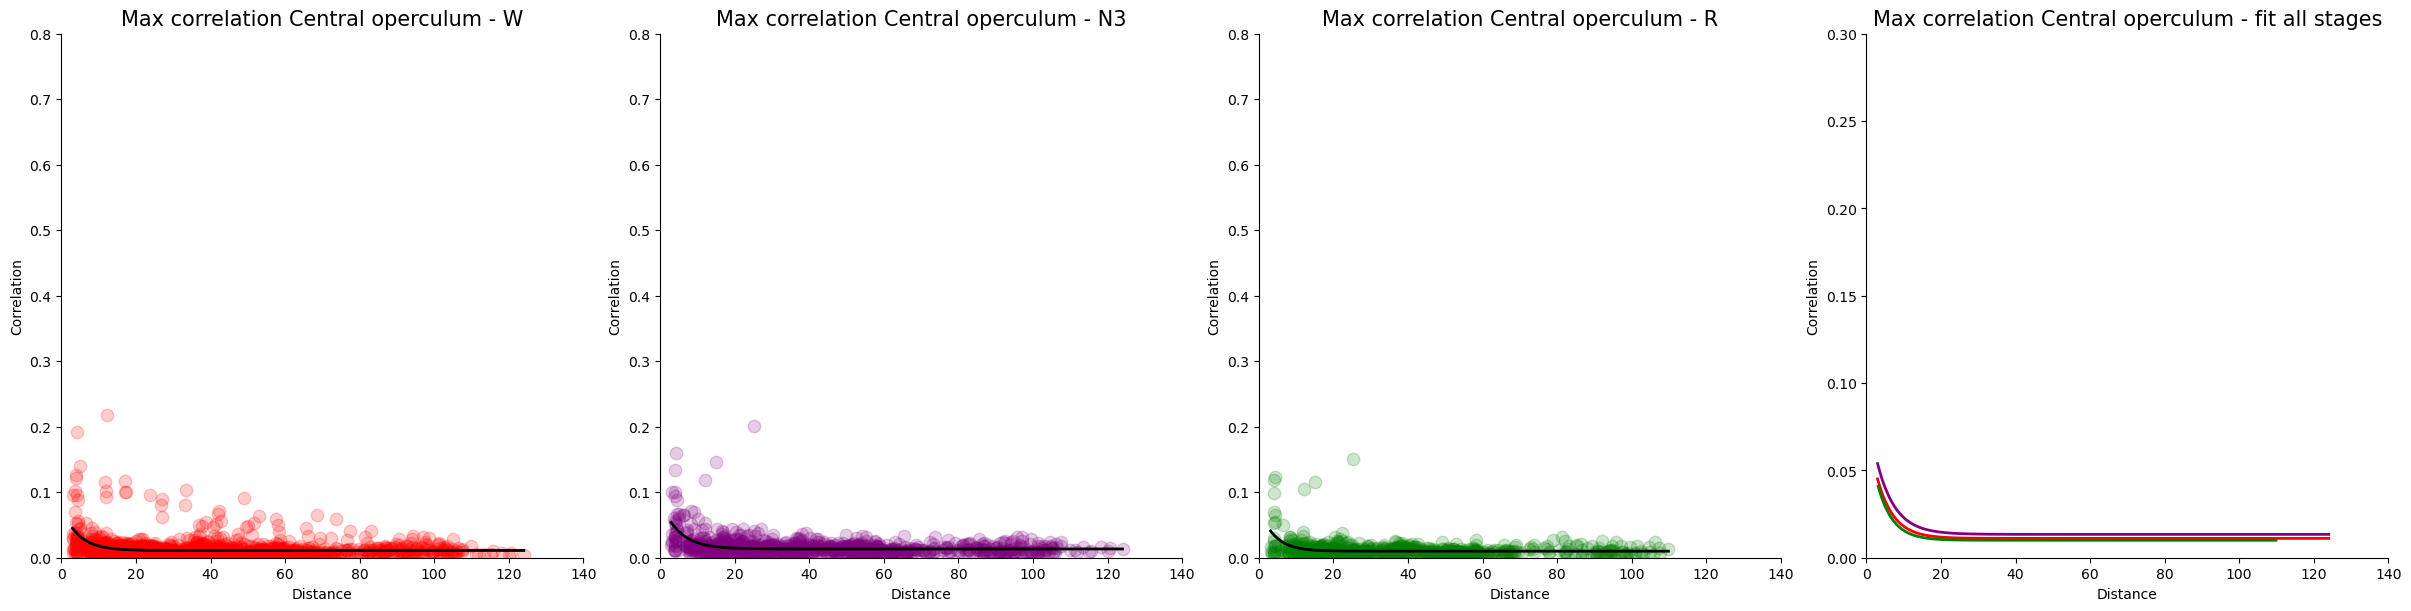

Transverse temporal gyrus
W [9.11981509e+00 1.54842393e-02 6.42705842e-03]
N3 [6.68408377 0.02313271 0.00887181]
R [7.85060280e+00 9.82314129e-03 7.31398195e-03]


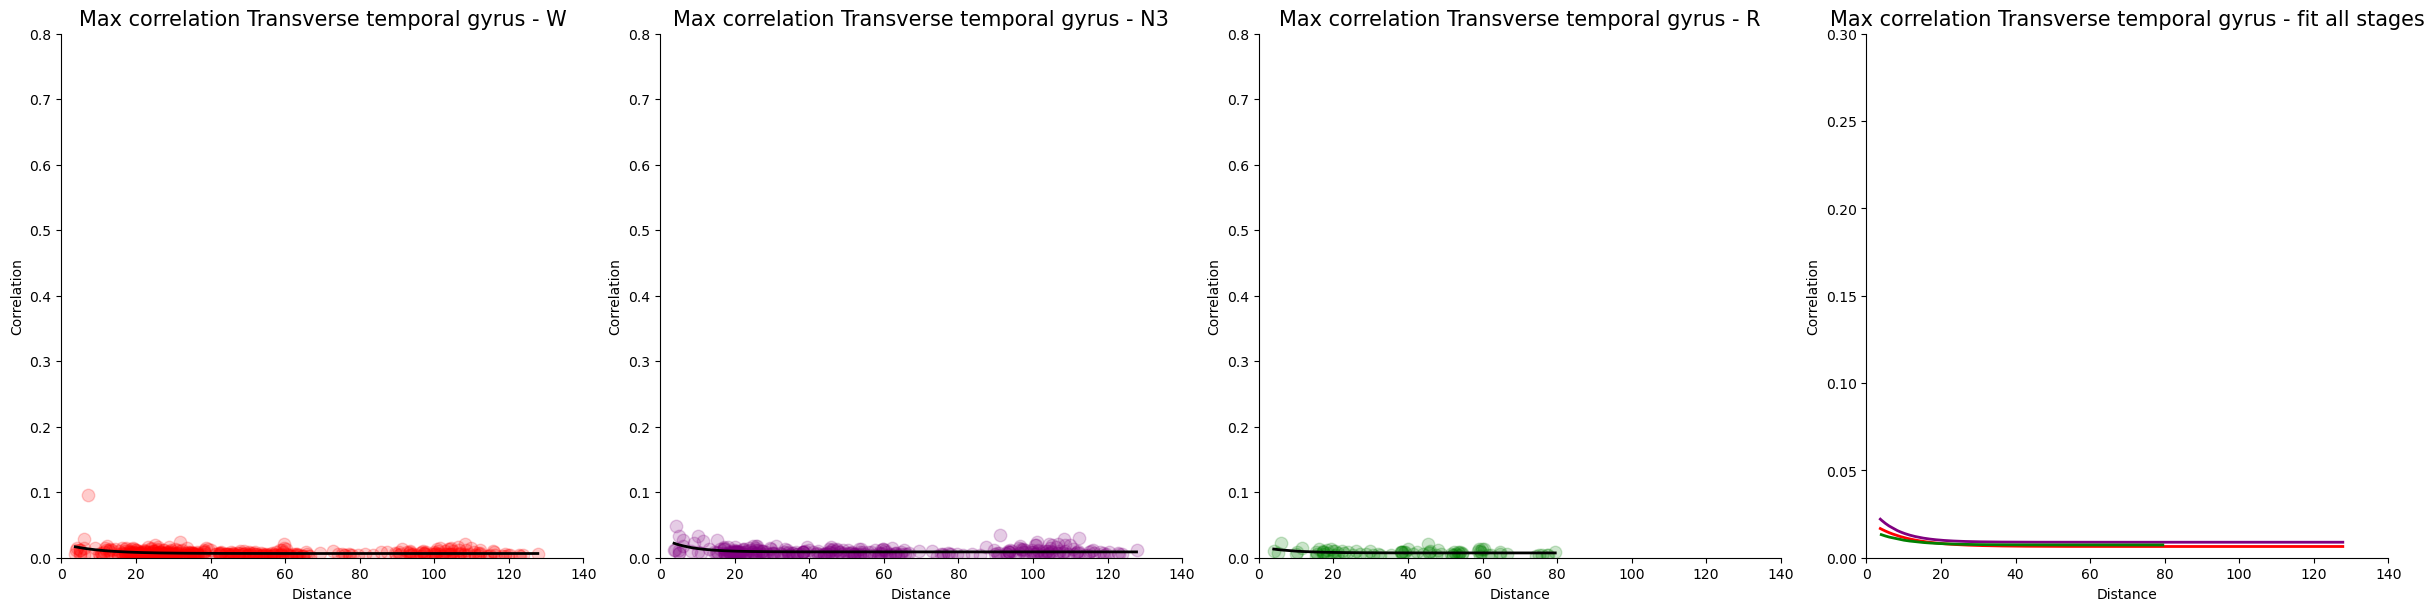

Lingual gyrus and occipital fusiform gyrus
W [1.20405986e+01 2.06897250e-02 5.21932383e-03]
N3 [1.20165955e+01 4.63587381e-02 7.77787142e-03]
R [1.03722673e+01 3.33888612e-02 7.87506738e-03]


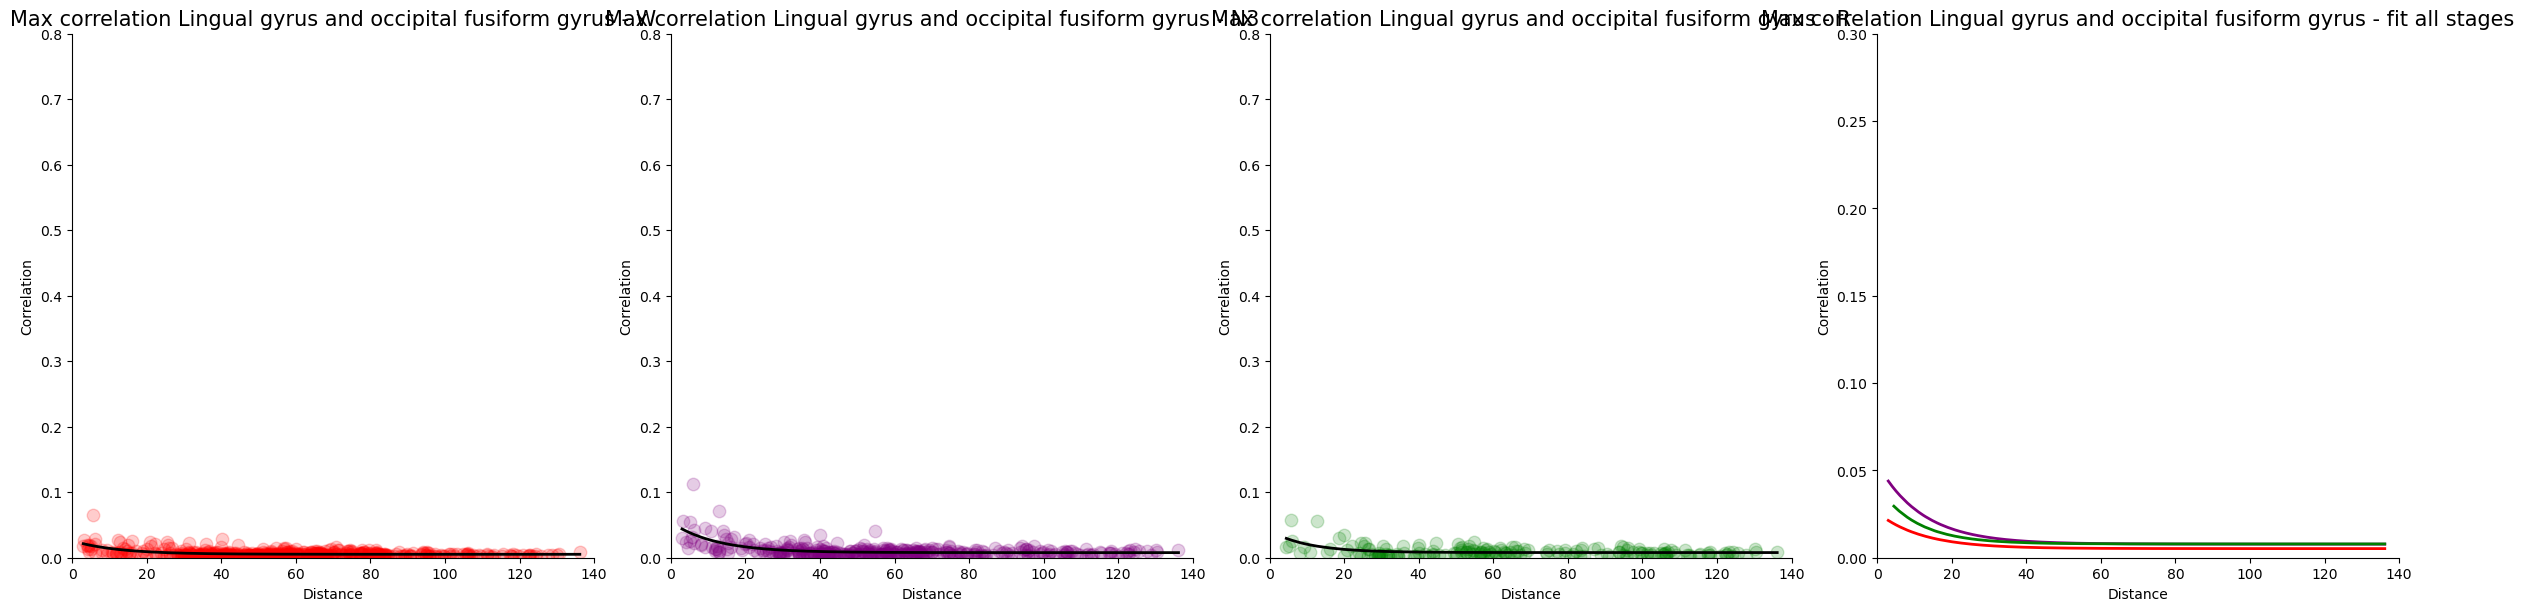

Fusiform and parahippocampal gyri
W [3.77131618 0.05978498 0.00946762]
N3 [5.10368926 0.0727734  0.01325357]
R [3.84569627 0.03901466 0.01077007]


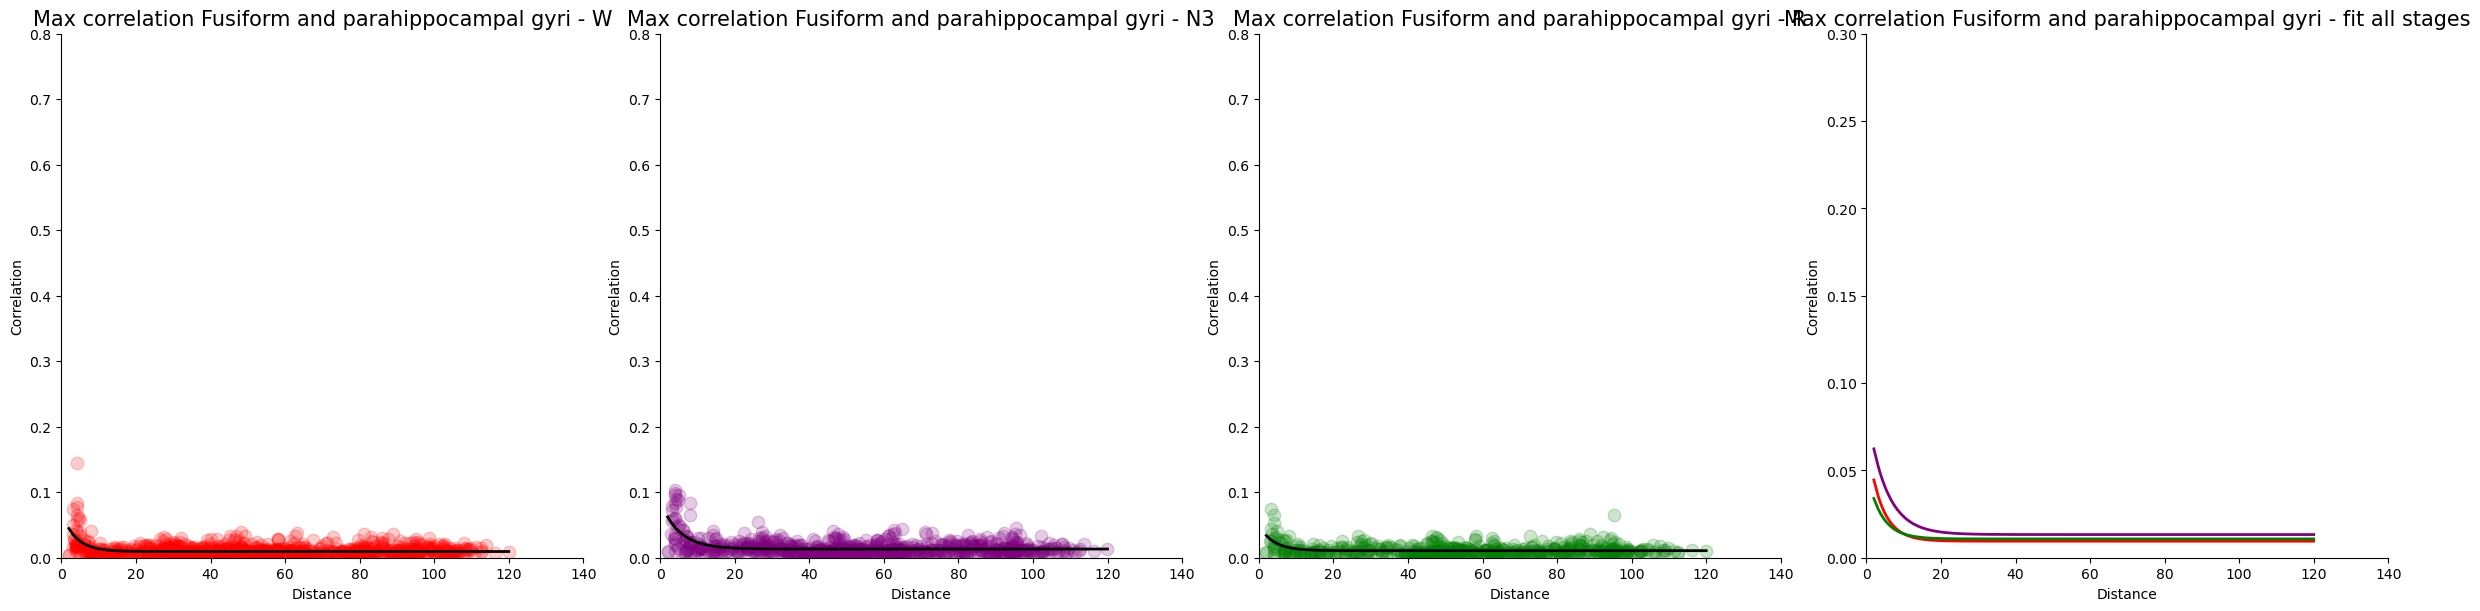

Inferior temporal gyrus
W [4.65501274 0.06013205 0.0084511 ]
N3 [4.64691763 0.0940004  0.0144056 ]
R [3.22177862 0.0687475  0.01148737]


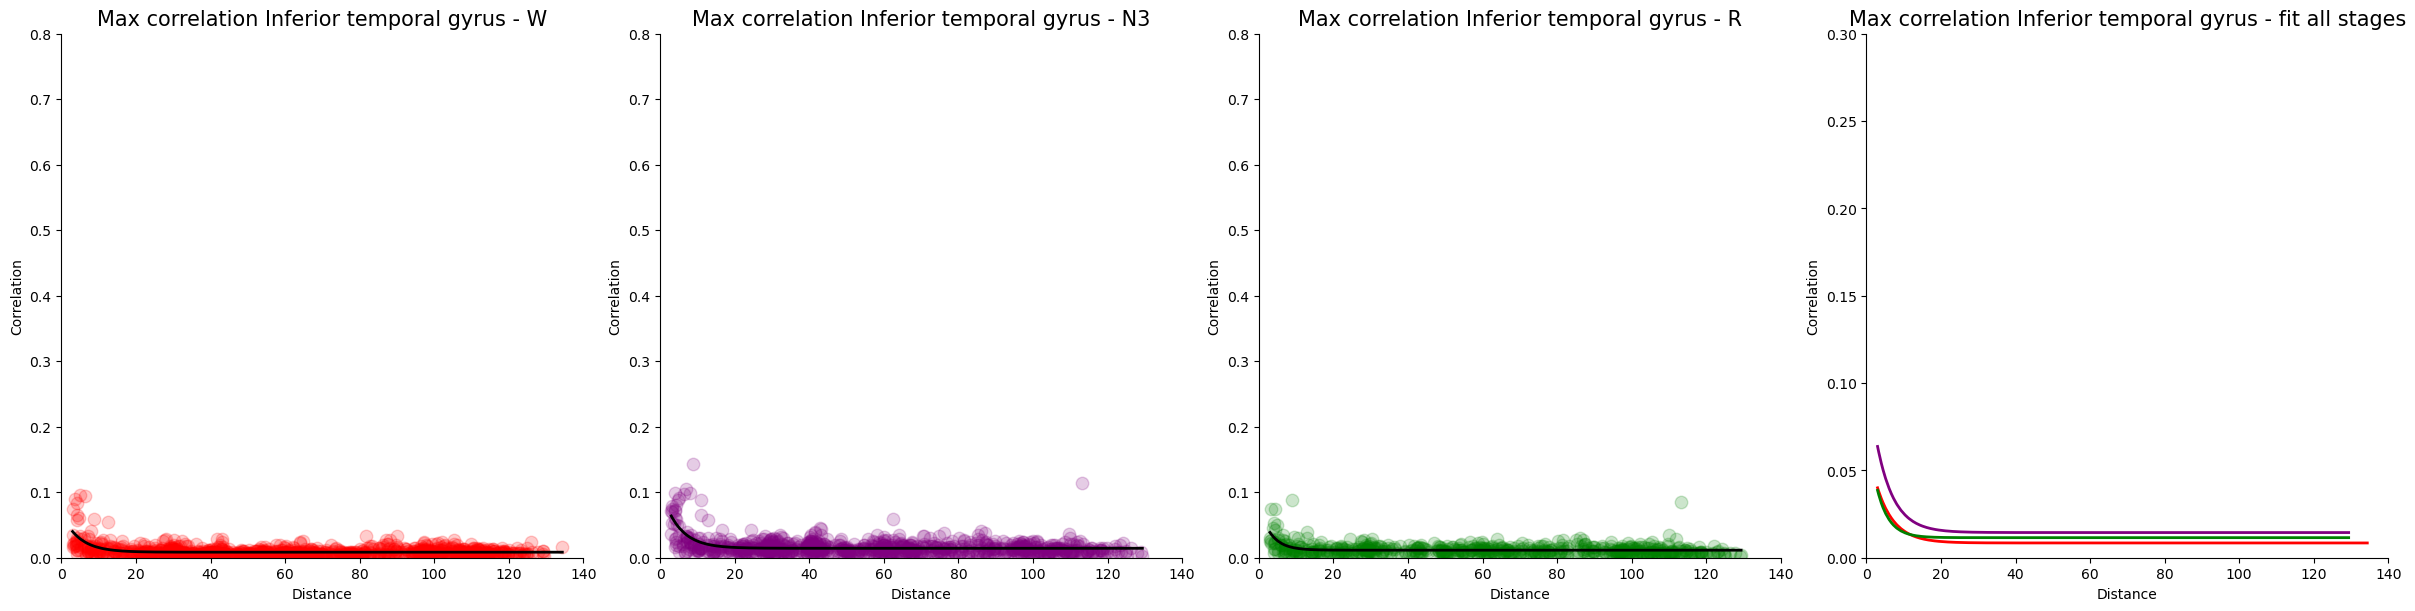

Postcentral gyrus (including medial segment)
W [8.41661408e+00 1.58426904e-02 5.30209254e-03]
N3 [8.68671982 0.04017766 0.01036451]
R [1.00000000e+02 1.84331594e-03 6.91885358e-03]


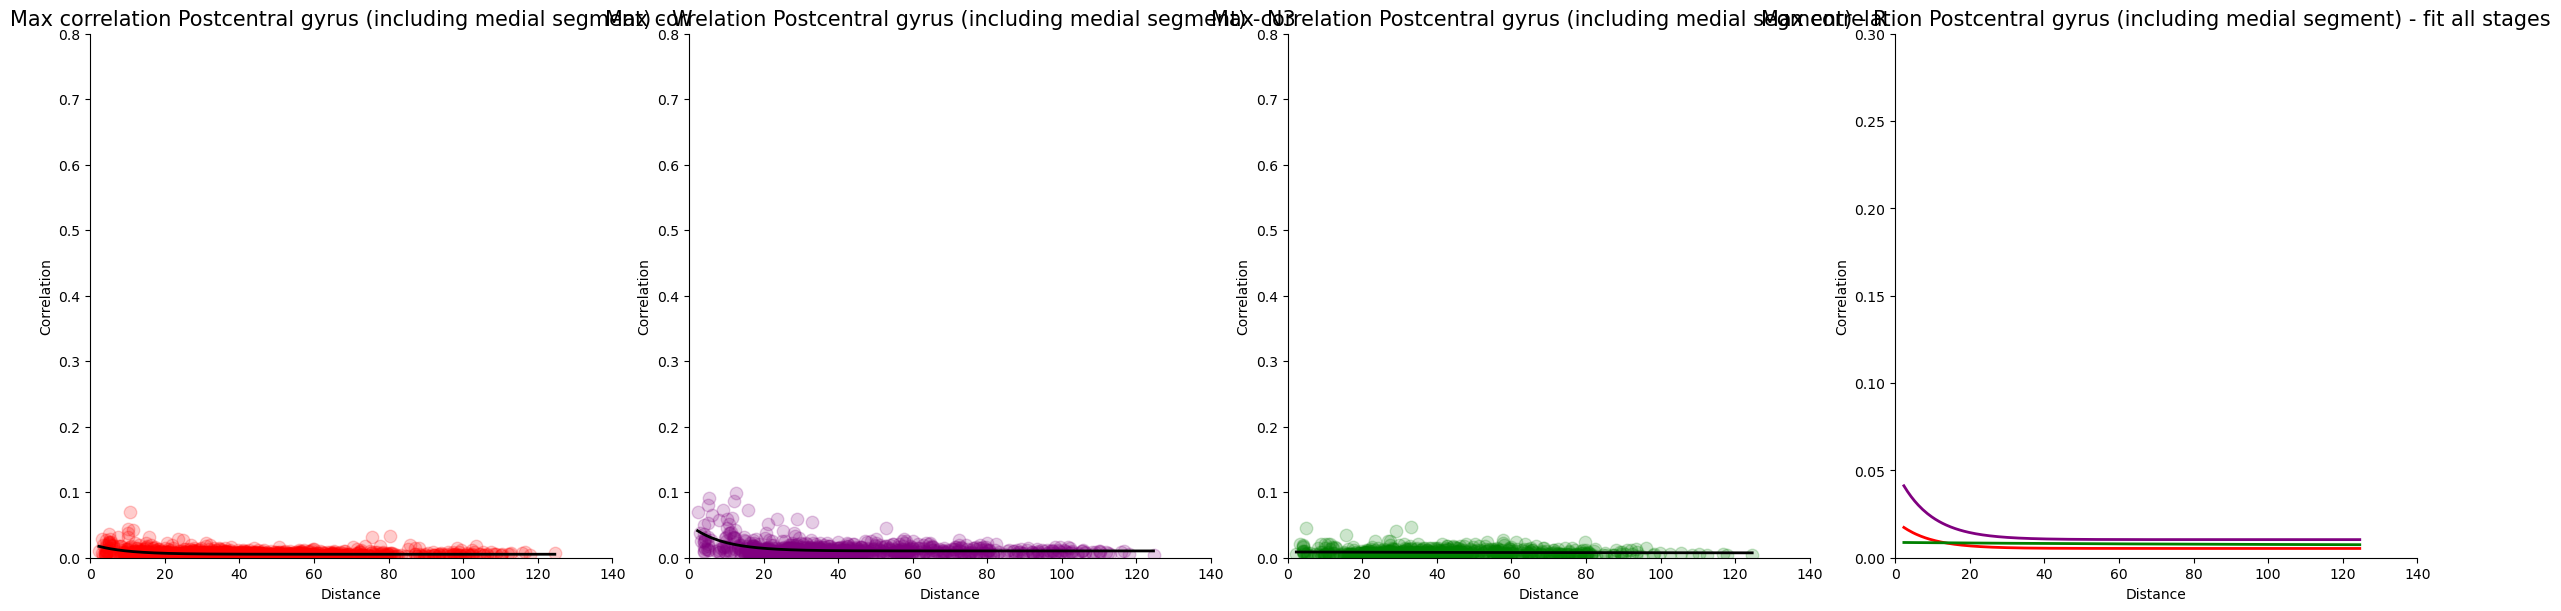

Precuneus
W [7.13674395 0.04461725 0.00935672]
N3 [7.20149426 0.0665437  0.01415493]
R [6.45964286 0.04283451 0.00980044]


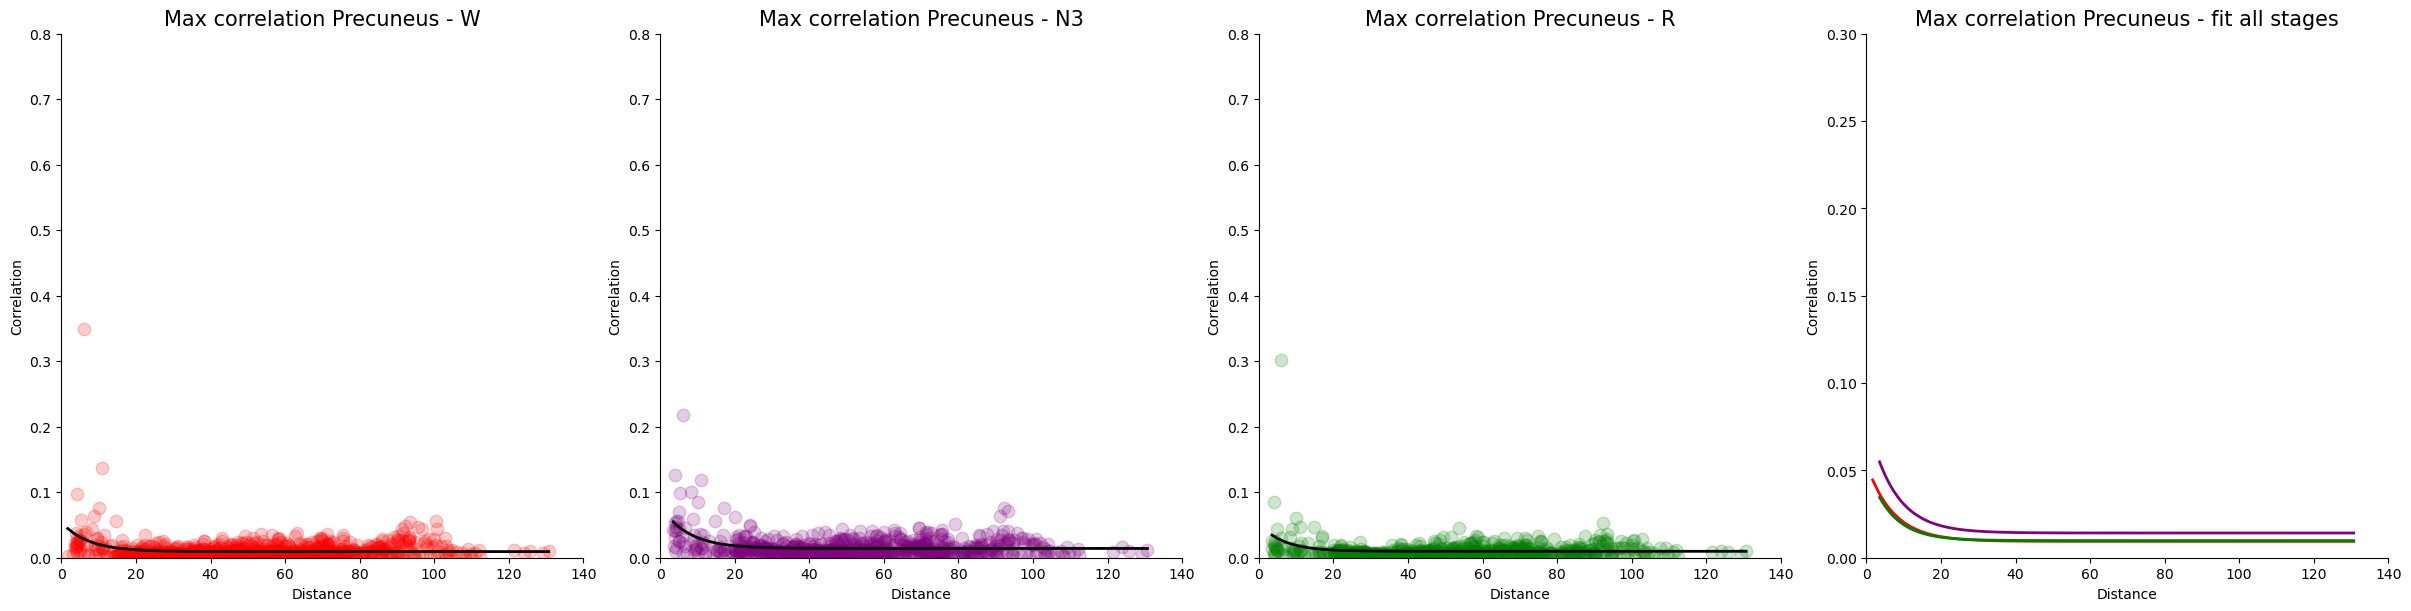

Angular gyrus
W [1.60406587 0.3066449  0.0071399 ]
N3 [2.2933015  0.25324885 0.01225338]
R [1.04058058 1.         0.00909344]


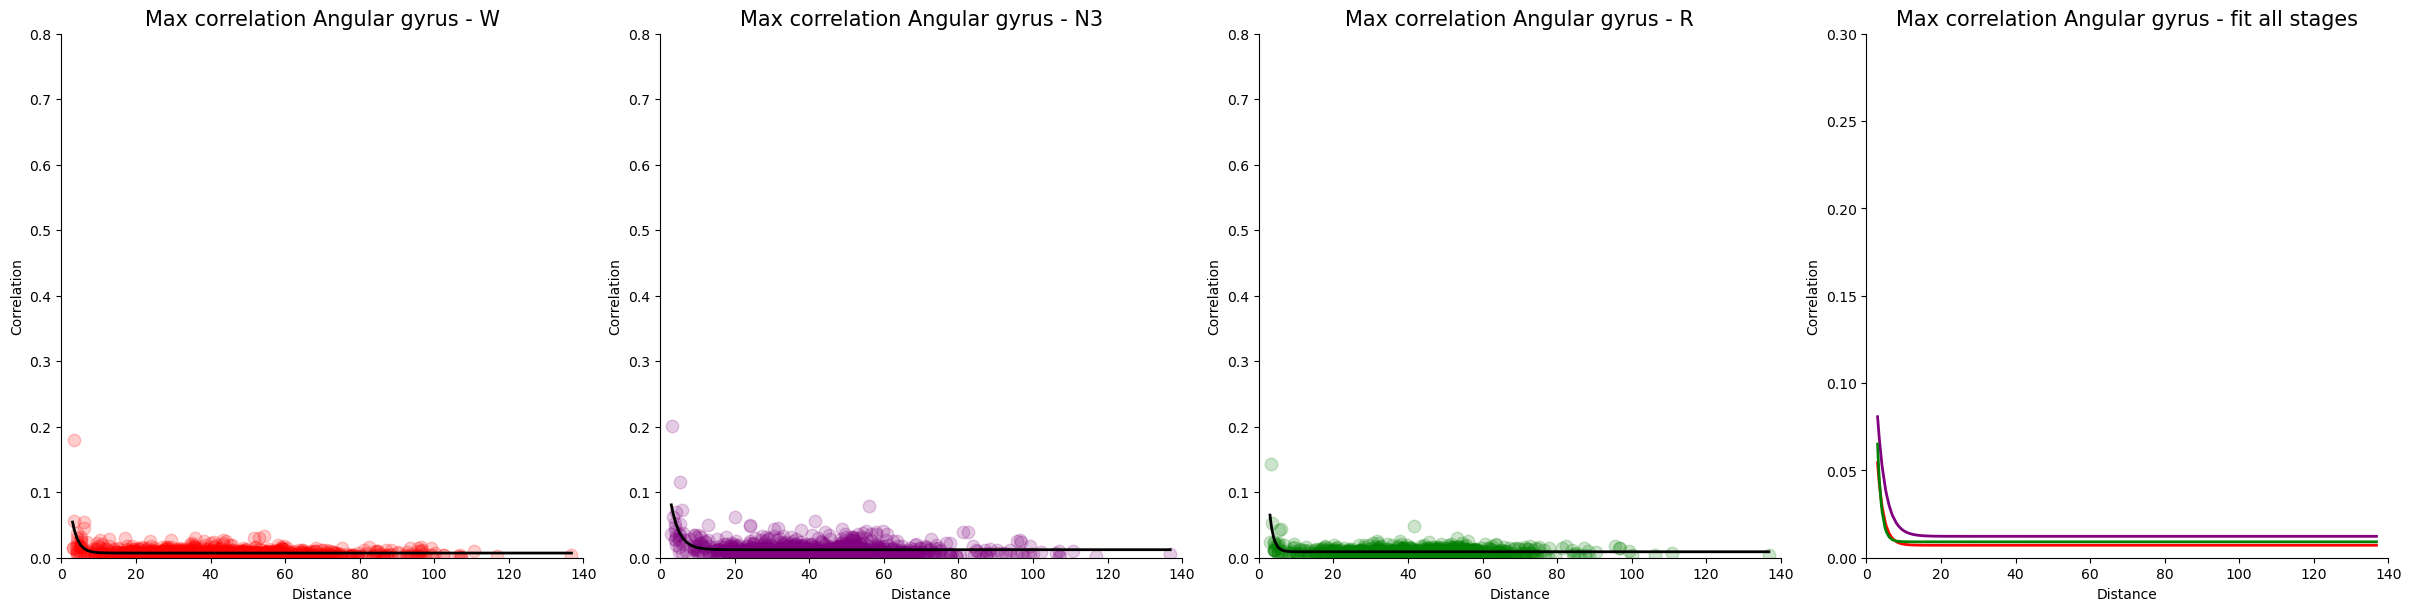

Opercular part of inferior frontal gyrus
W [3.06888880e+01 2.04781625e-02 4.75697871e-03]
N3 [1.28762087e+01 3.26935426e-02 9.35479840e-03]
R [1.97889635e+01 1.64104689e-02 6.52757507e-03]


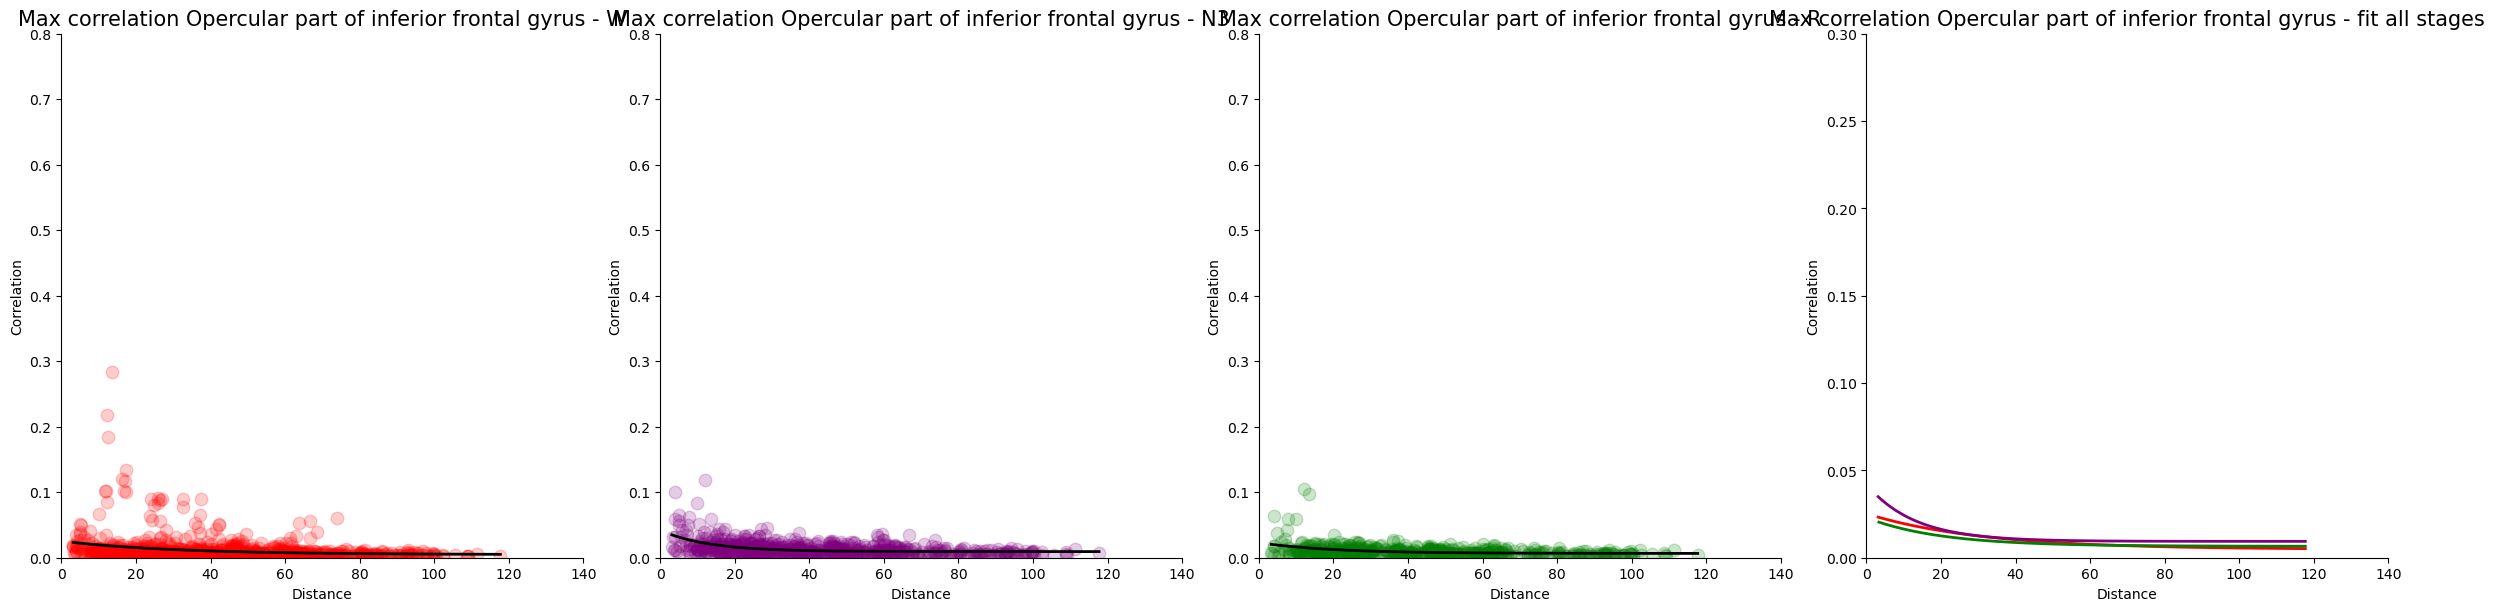

Parietal operculum
W [5.60146978 0.06512467 0.00983137]
N3 [4.88138328 0.09064143 0.01260422]
R [2.96084184 0.03903142 0.00705186]


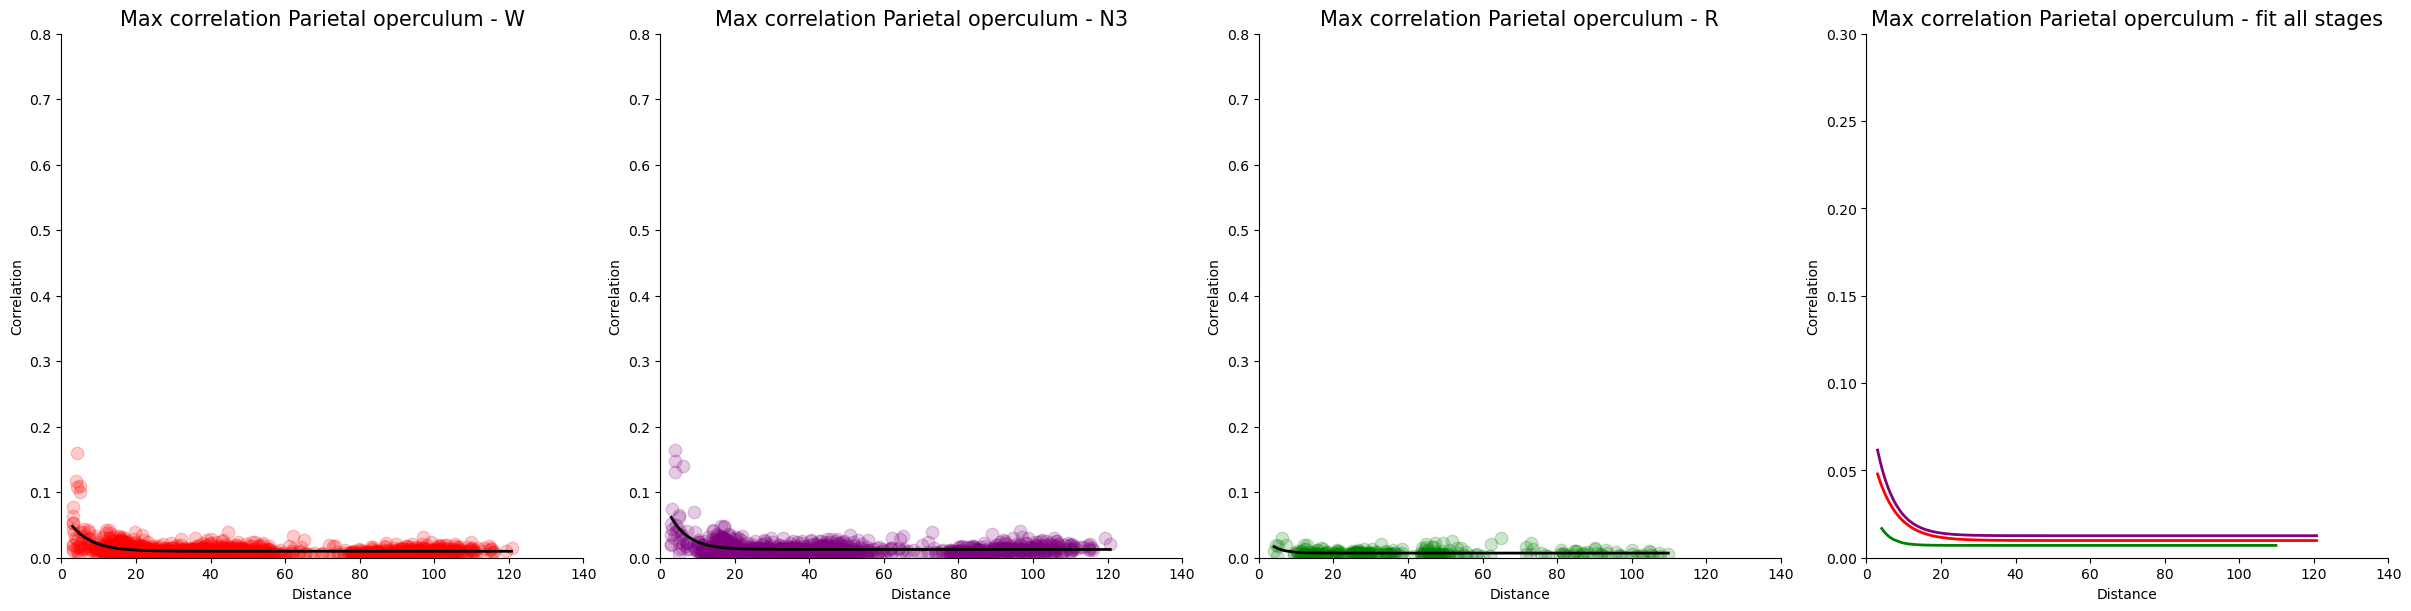

Frontal operculum
W [10.86624911  0.0335234   0.01091432]
N3 [9.47647447 0.05150143 0.01059306]
R [8.57549475 0.05401554 0.00877661]


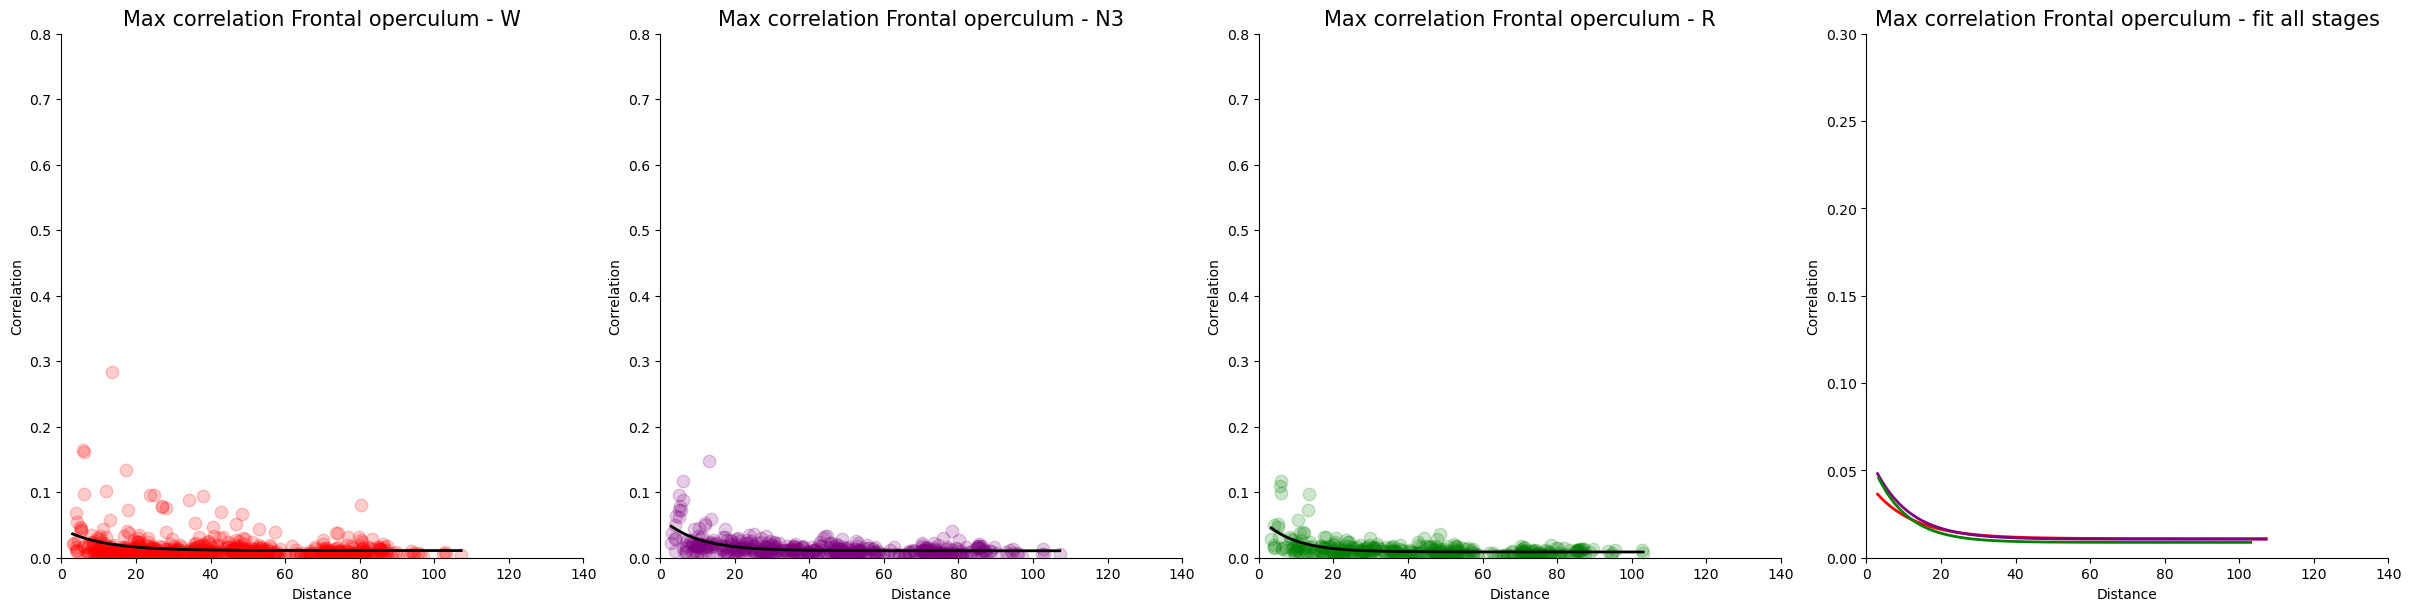

Triangular part of inferior frontal gyrus
W [5.34671028e+01 2.83947126e-02 3.39595161e-03]
N3 [8.92180698 0.05345293 0.01230934]
R [1.38109234e+01 2.31655602e-02 1.00292328e-02]


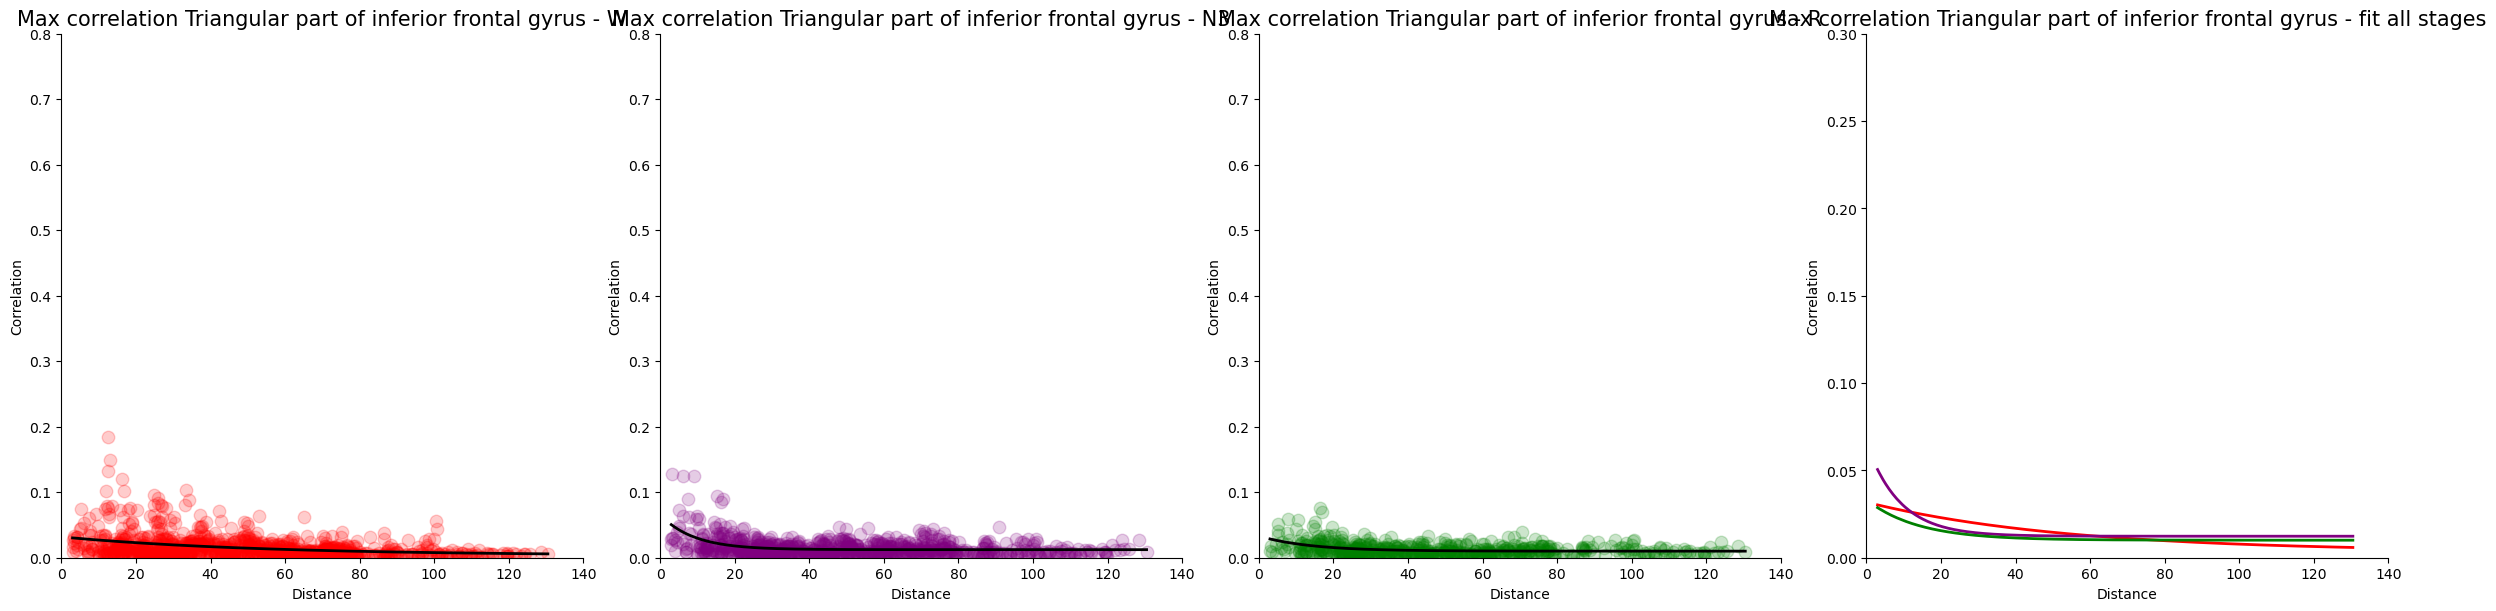

Middle frontal gyrus
W [5.48548737 0.04378068 0.00990752]
N3 [5.18881635 0.07013006 0.01184119]
R [4.18344303 0.04616521 0.00912573]


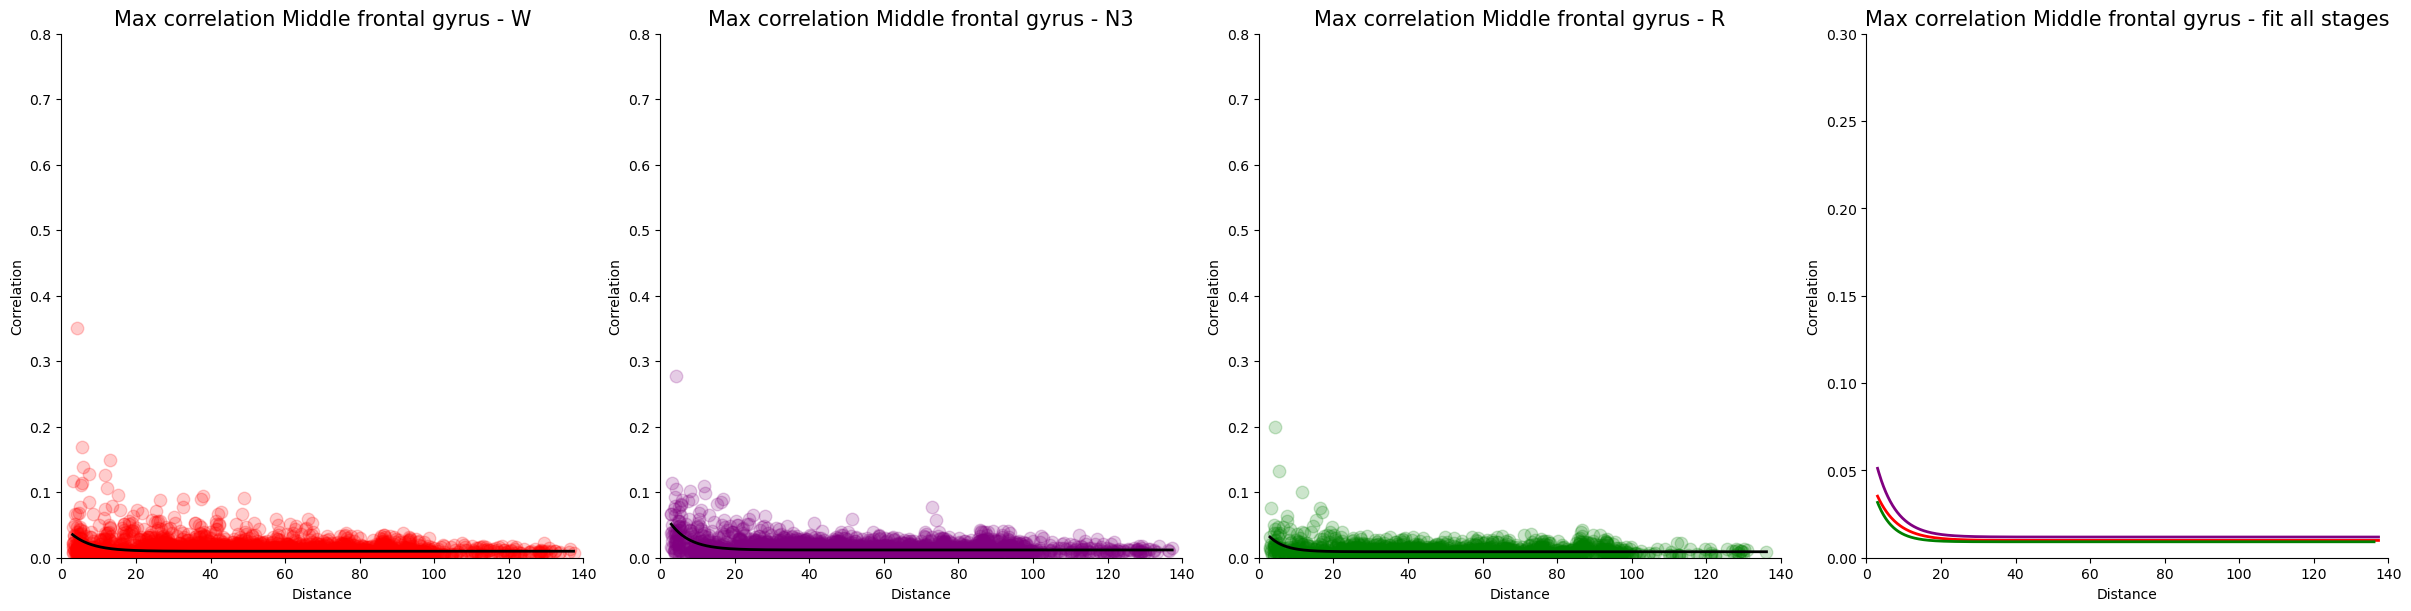

Anterior cingulate
W [13.33303221  0.01537002  0.01404564]
N3 [9.65516489 0.02361435 0.01442805]
R [1.30146606 0.41059564 0.01410099]


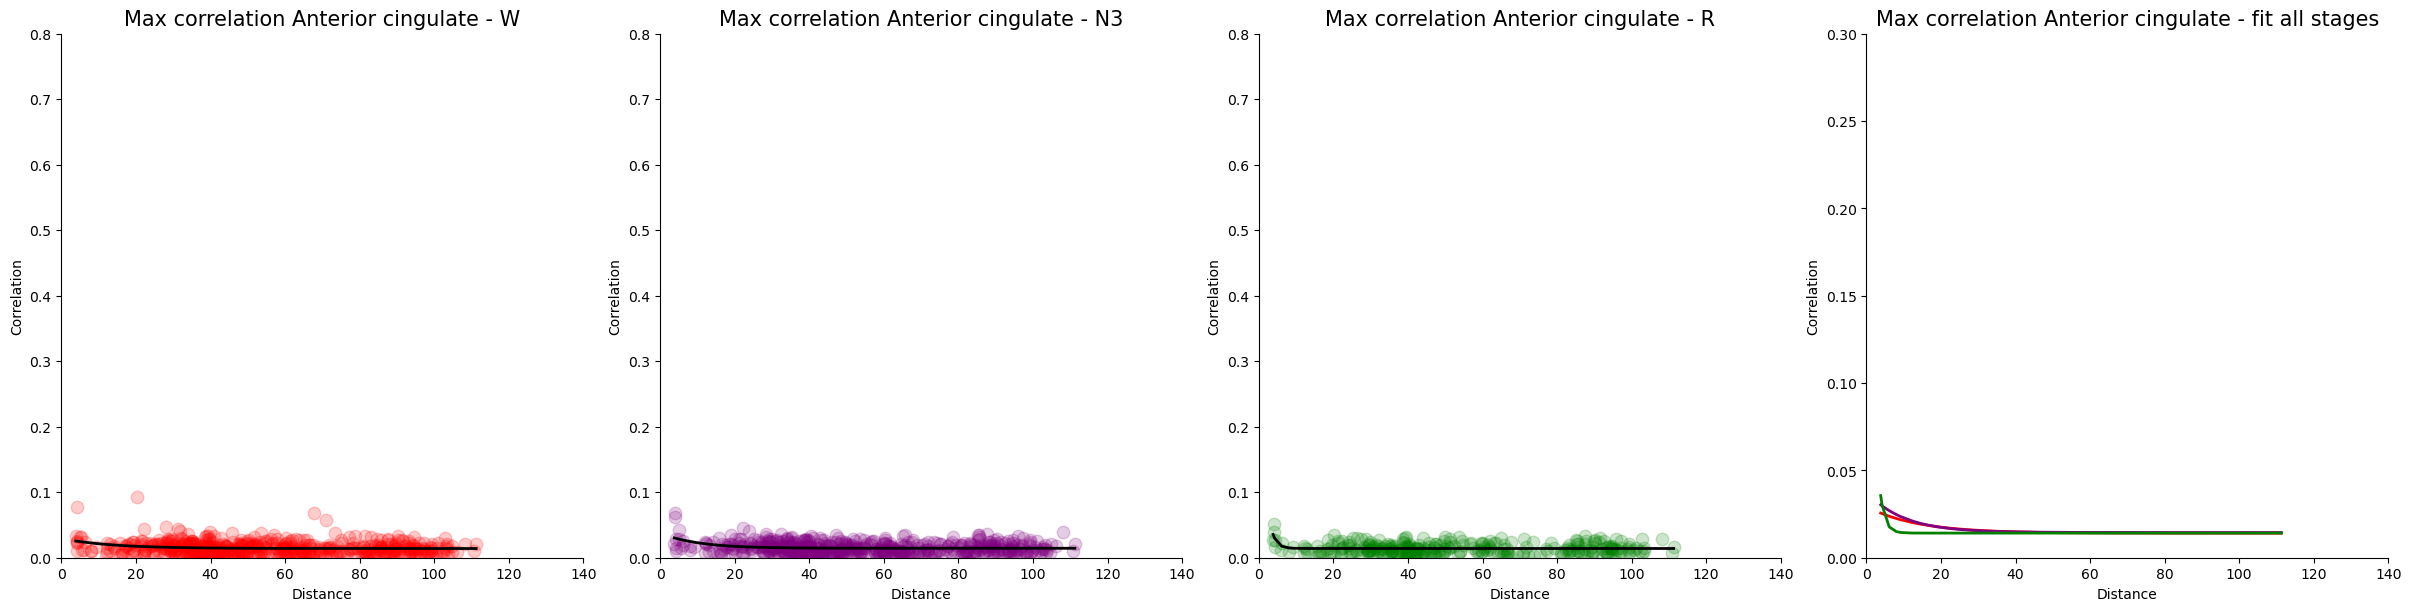

Superior temporal gyrus
W [5.61350771 0.05767841 0.01024325]
N3 [5.73465864 0.06809867 0.01219395]
R [4.92206673 0.05203581 0.01054541]


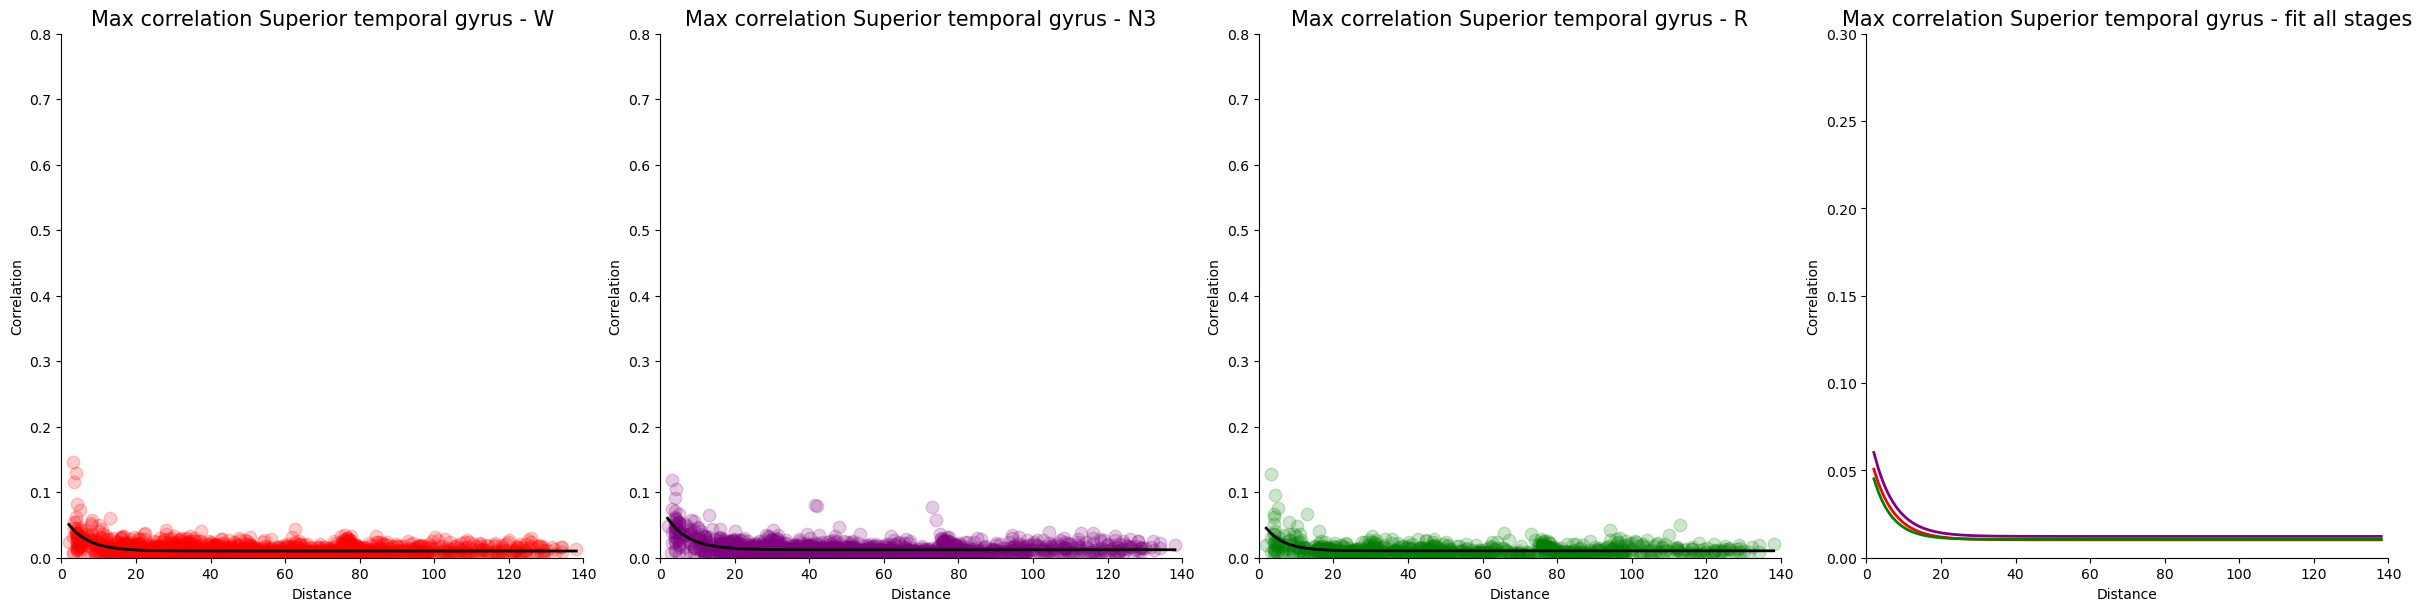

Posterior insula
W [2.69619021 0.07459294 0.00948956]
N3 [4.68172397 0.0780904  0.01367705]
R [3.63449585e+01 1.88084101e-02 8.36058532e-03]


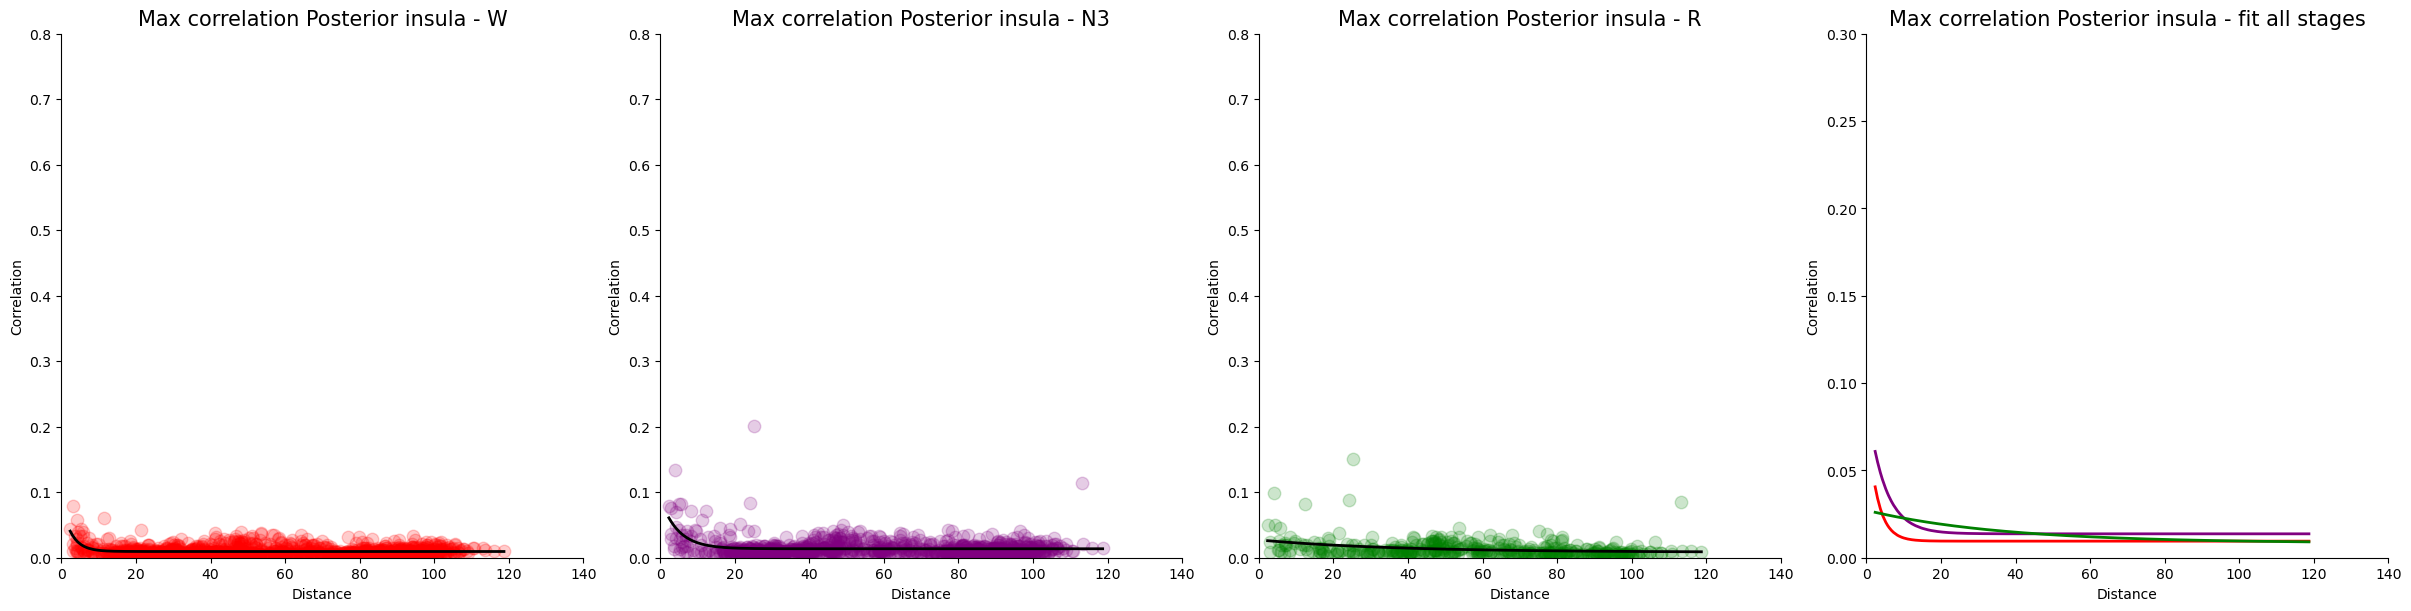

Medial segment of precentral gyrus
W [2.99433527 0.12969123 0.00622648]
N3 [4.67567092 0.14255195 0.01008747]
R [1.00000000e+02 8.56701724e-03 3.06462113e-03]


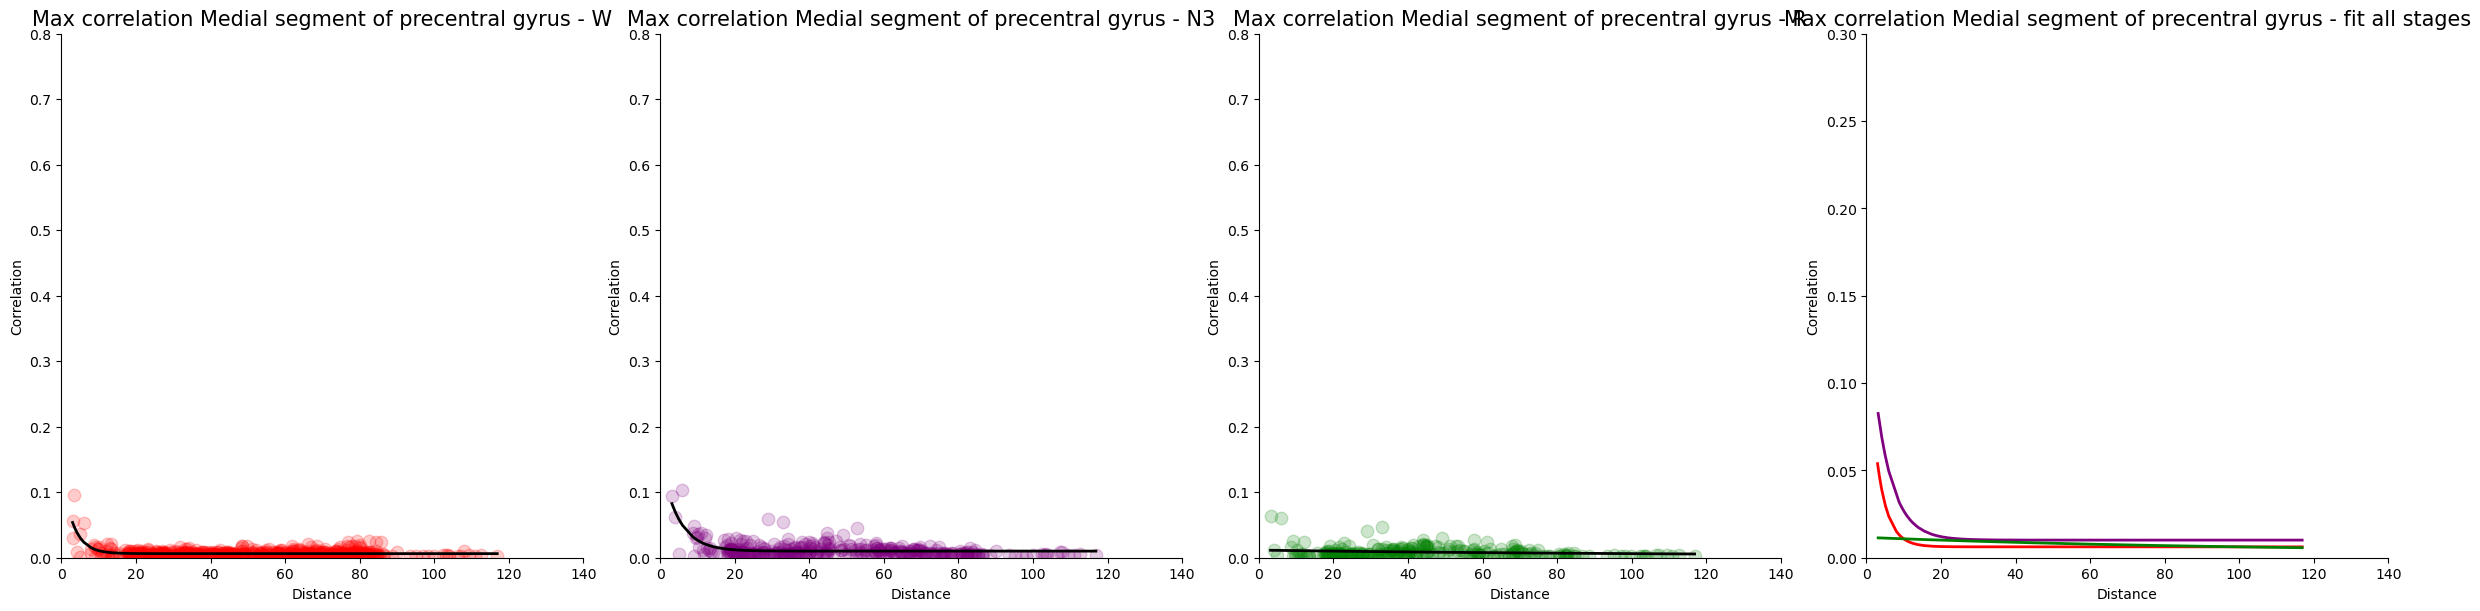

Medial segment of superior frontal gyrus
W [3.87331494 0.03822288 0.00753273]
N3 [3.20995087 0.09993054 0.01053279]
R [3.29844906 0.06175414 0.0067399 ]


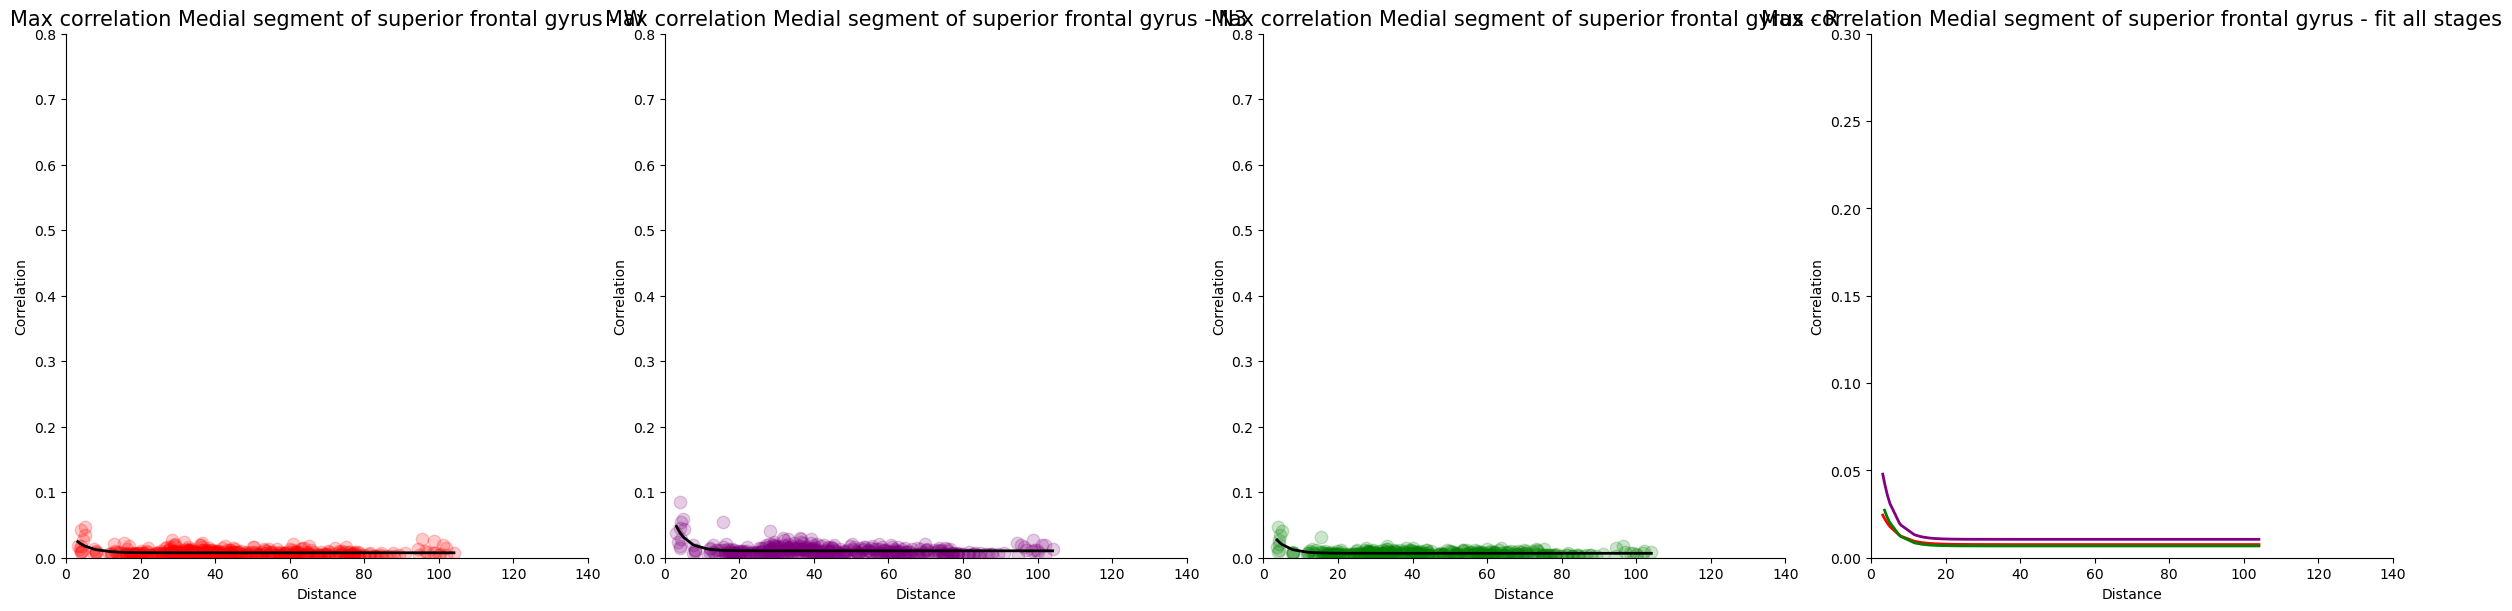

Superior frontal gyrus and frontal pole
W [4.79915467 0.06433044 0.01034988]
N3 [6.12447807 0.07873043 0.01206566]
R [5.88632287 0.03717214 0.0080155 ]


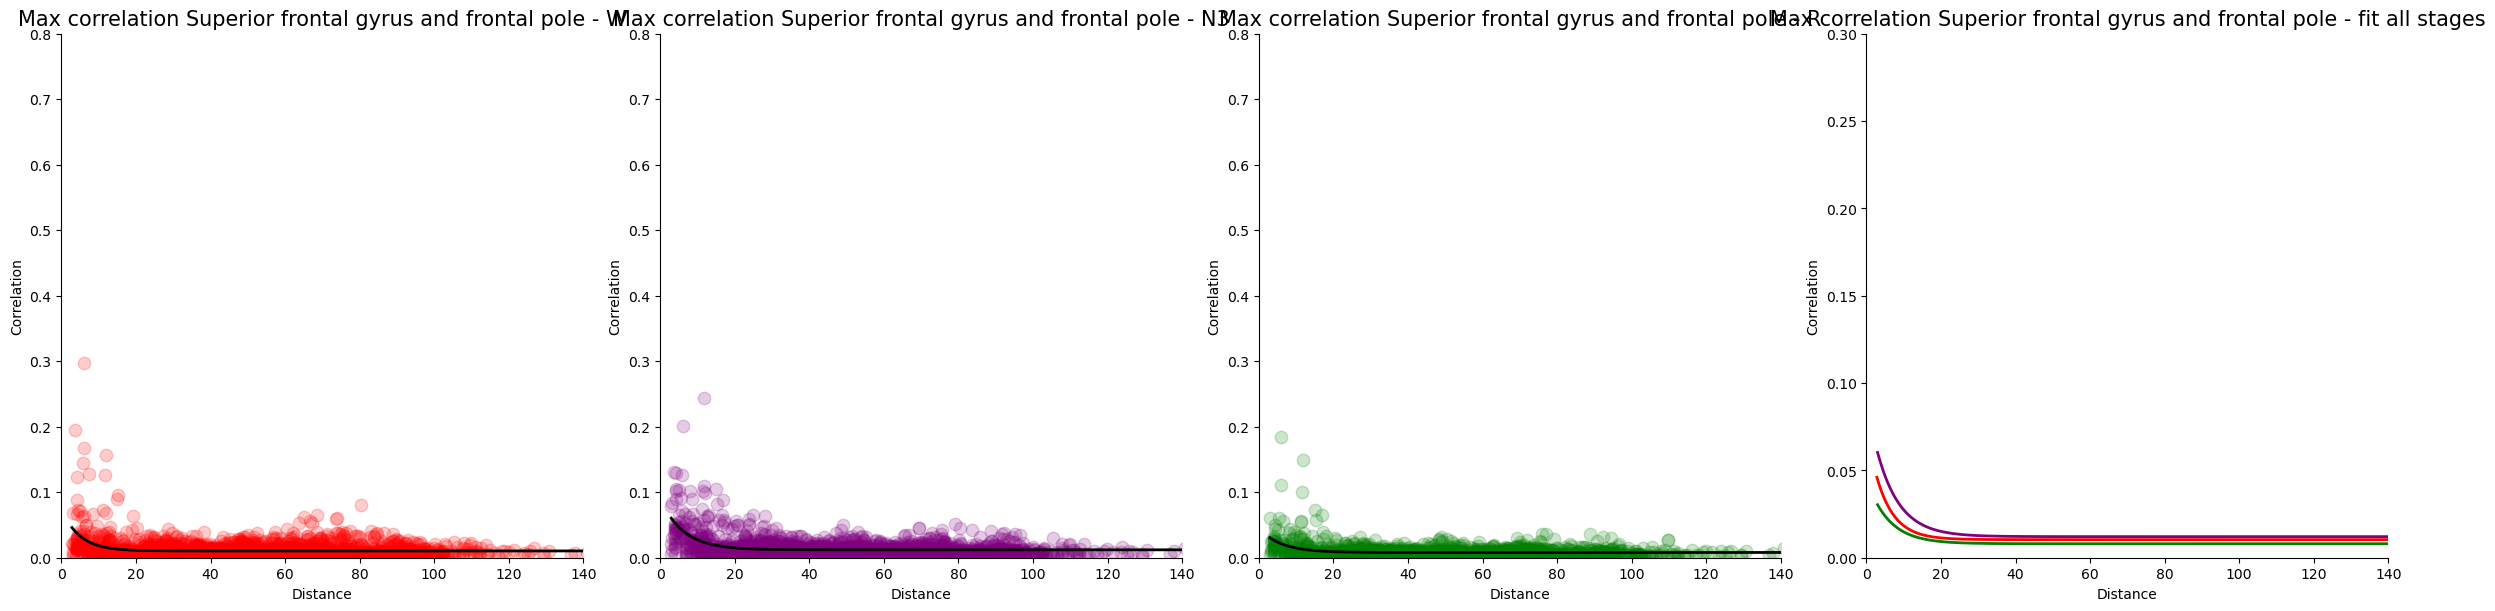

Superior parietal lobule
W [7.69711501 0.02441668 0.00903974]
N3 [6.17403085 0.05657042 0.0133721 ]
R [4.84353691 0.02684167 0.01078888]


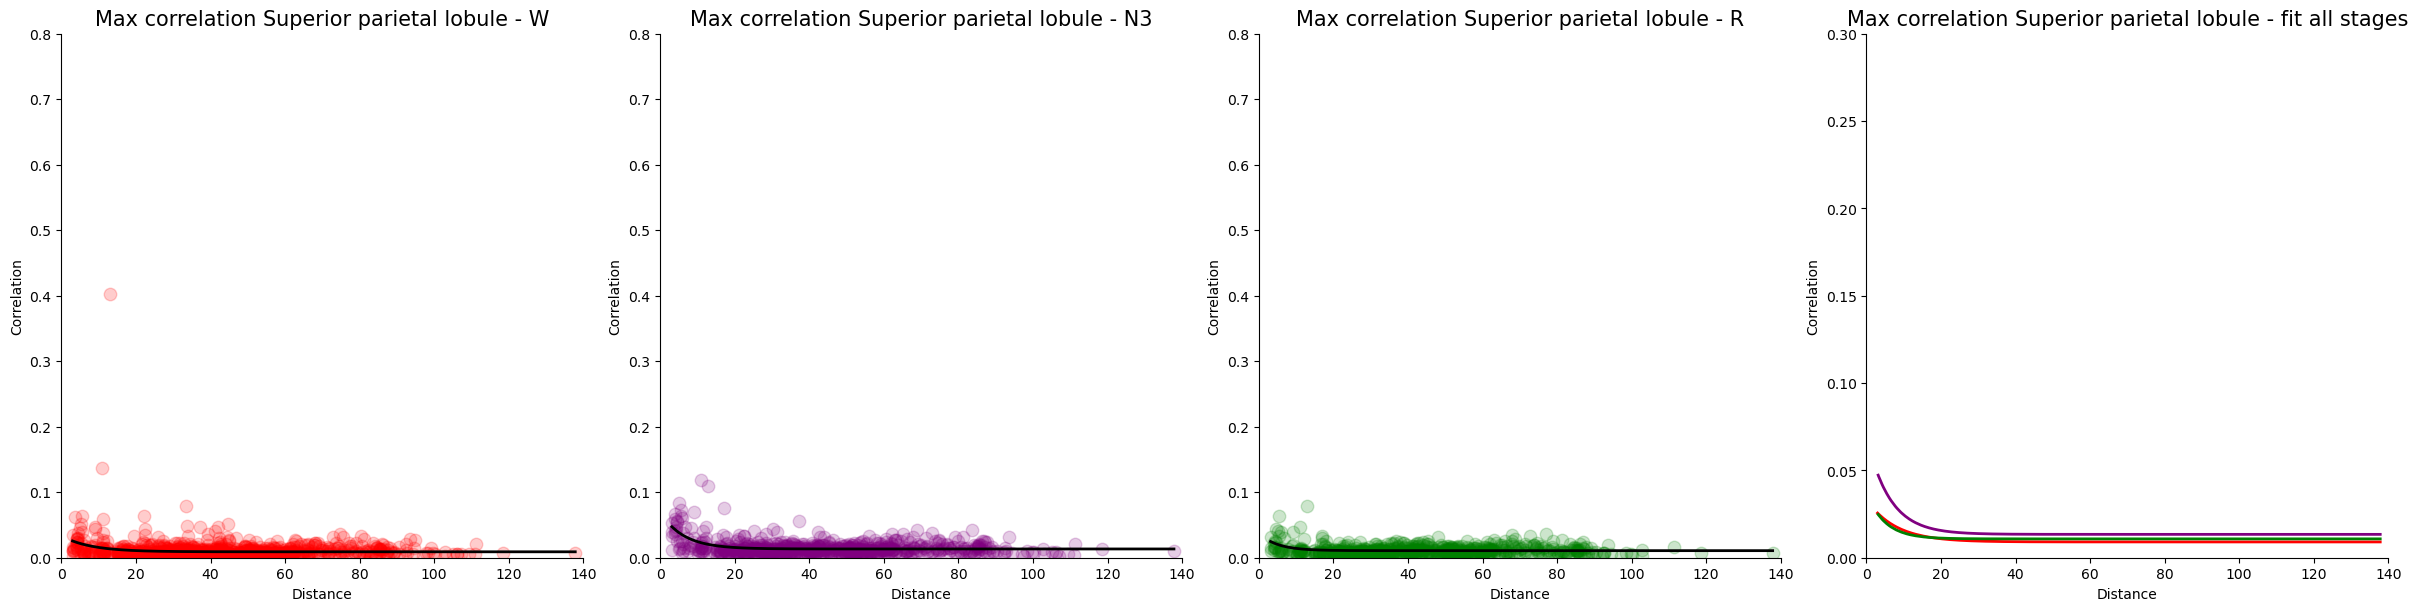

Posterior cingulate
W [1.13028876e+01 3.02484564e-02 7.53455678e-03]
N3 [1.556242   1.         0.01524693]
R [1.41733624 1.         0.01478421]


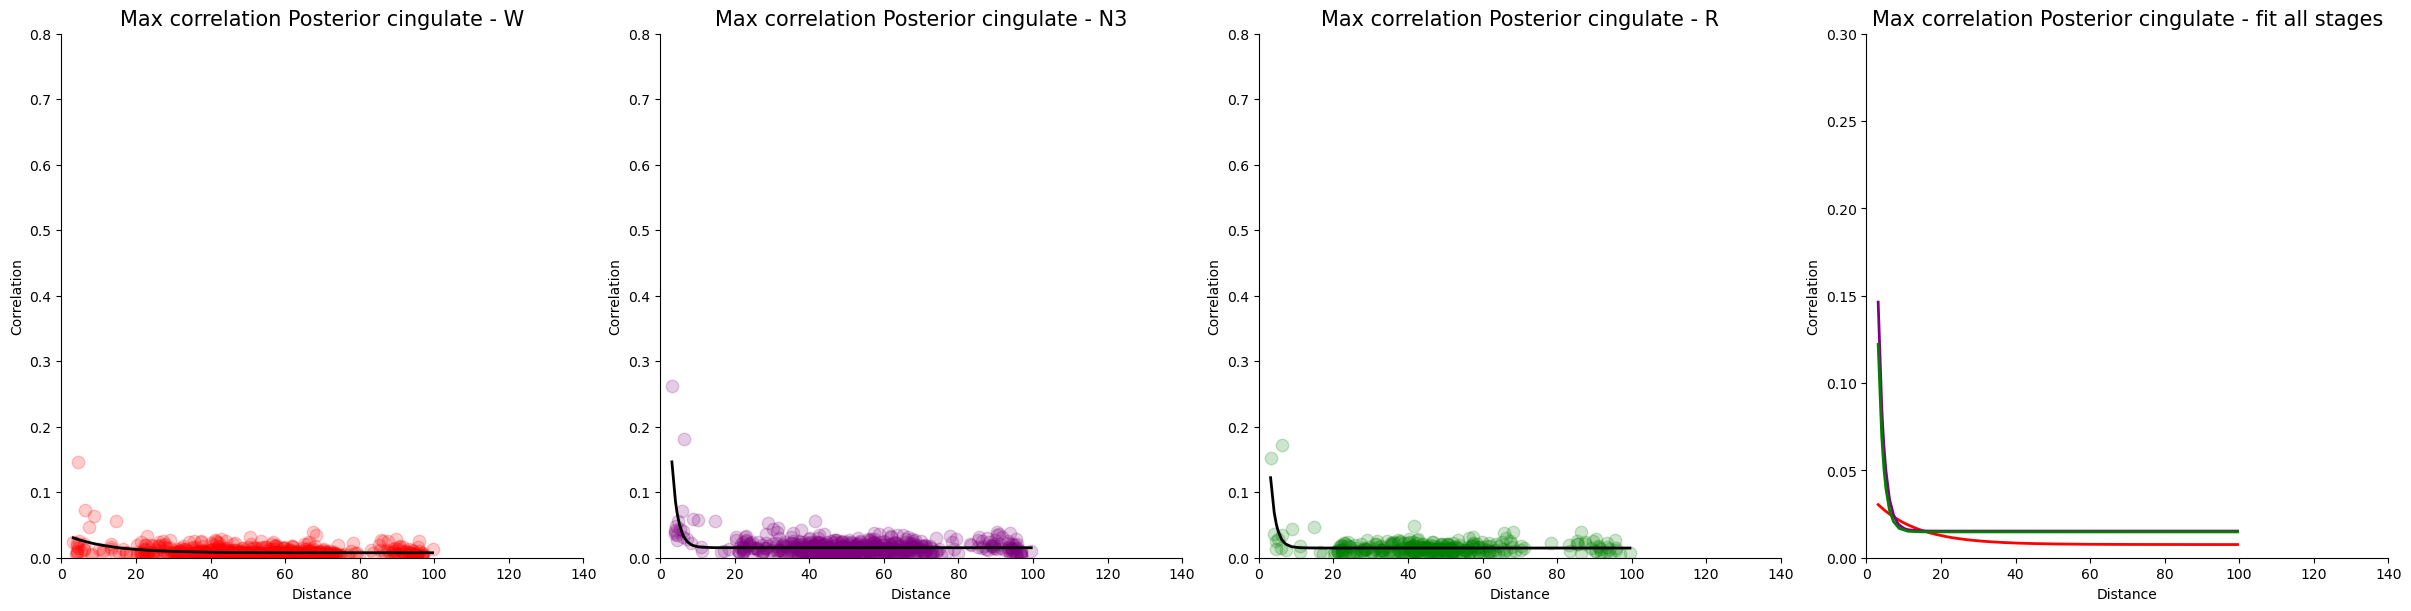

Supramarginal gyrus
W [4.48930666 0.03622377 0.00723327]
N3 [4.48785256 0.08011673 0.0121283 ]
R [4.26746175 0.0264567  0.01080469]


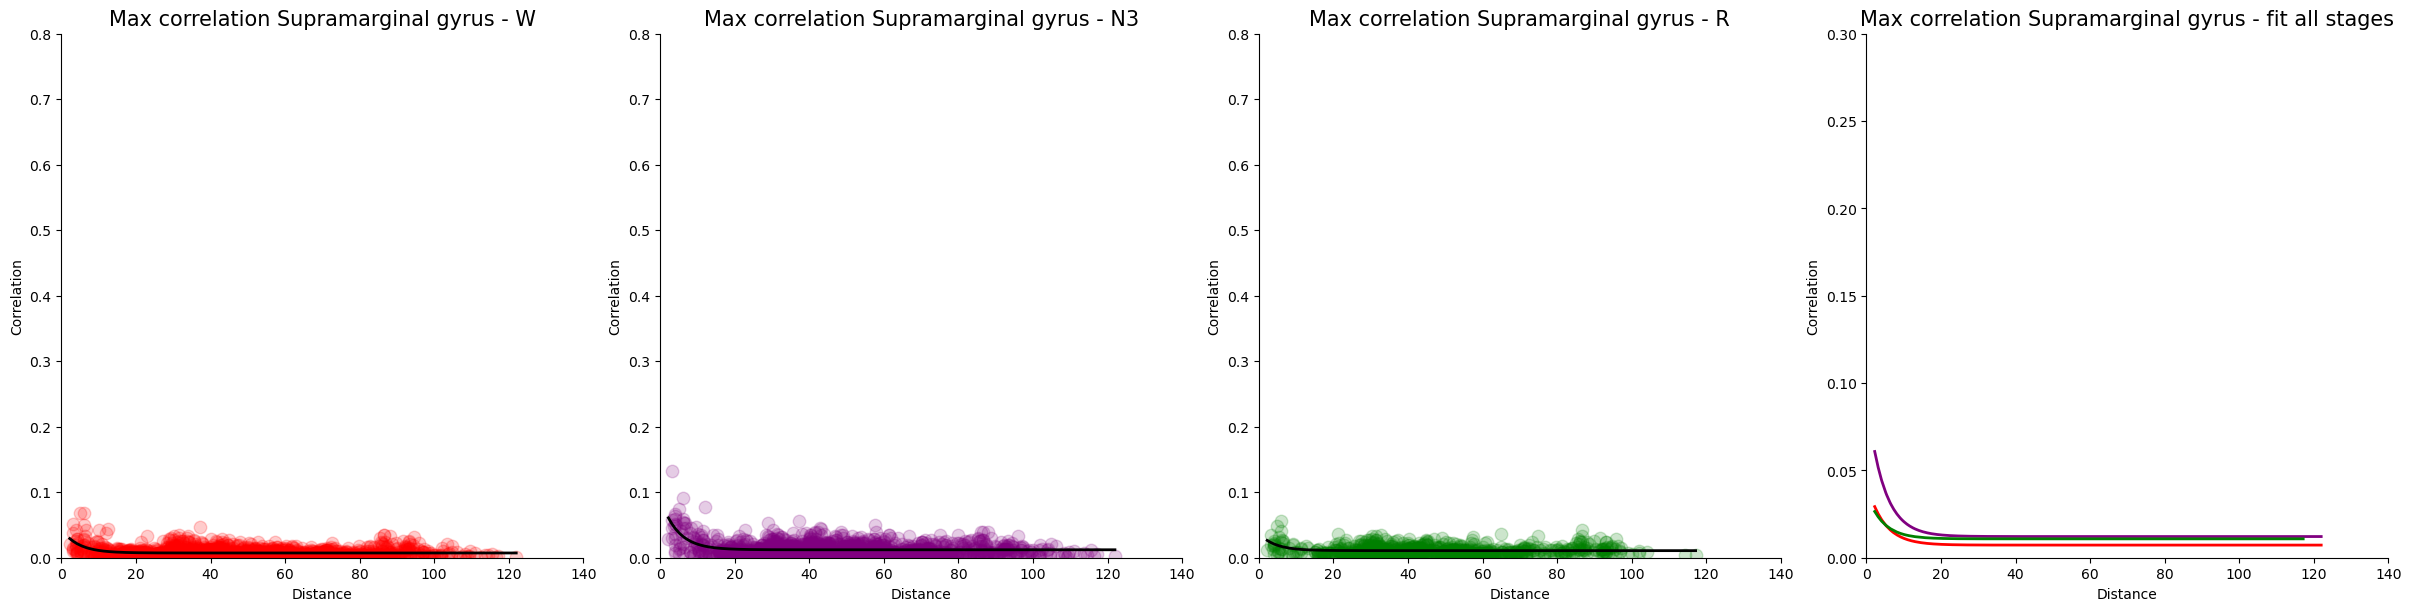

Gyrus rectus and orbital gyri
W [7.17705726 0.04194329 0.00874917]
N3 [5.43820081 0.05704733 0.01227199]
R [3.32241795 0.04446033 0.01077013]


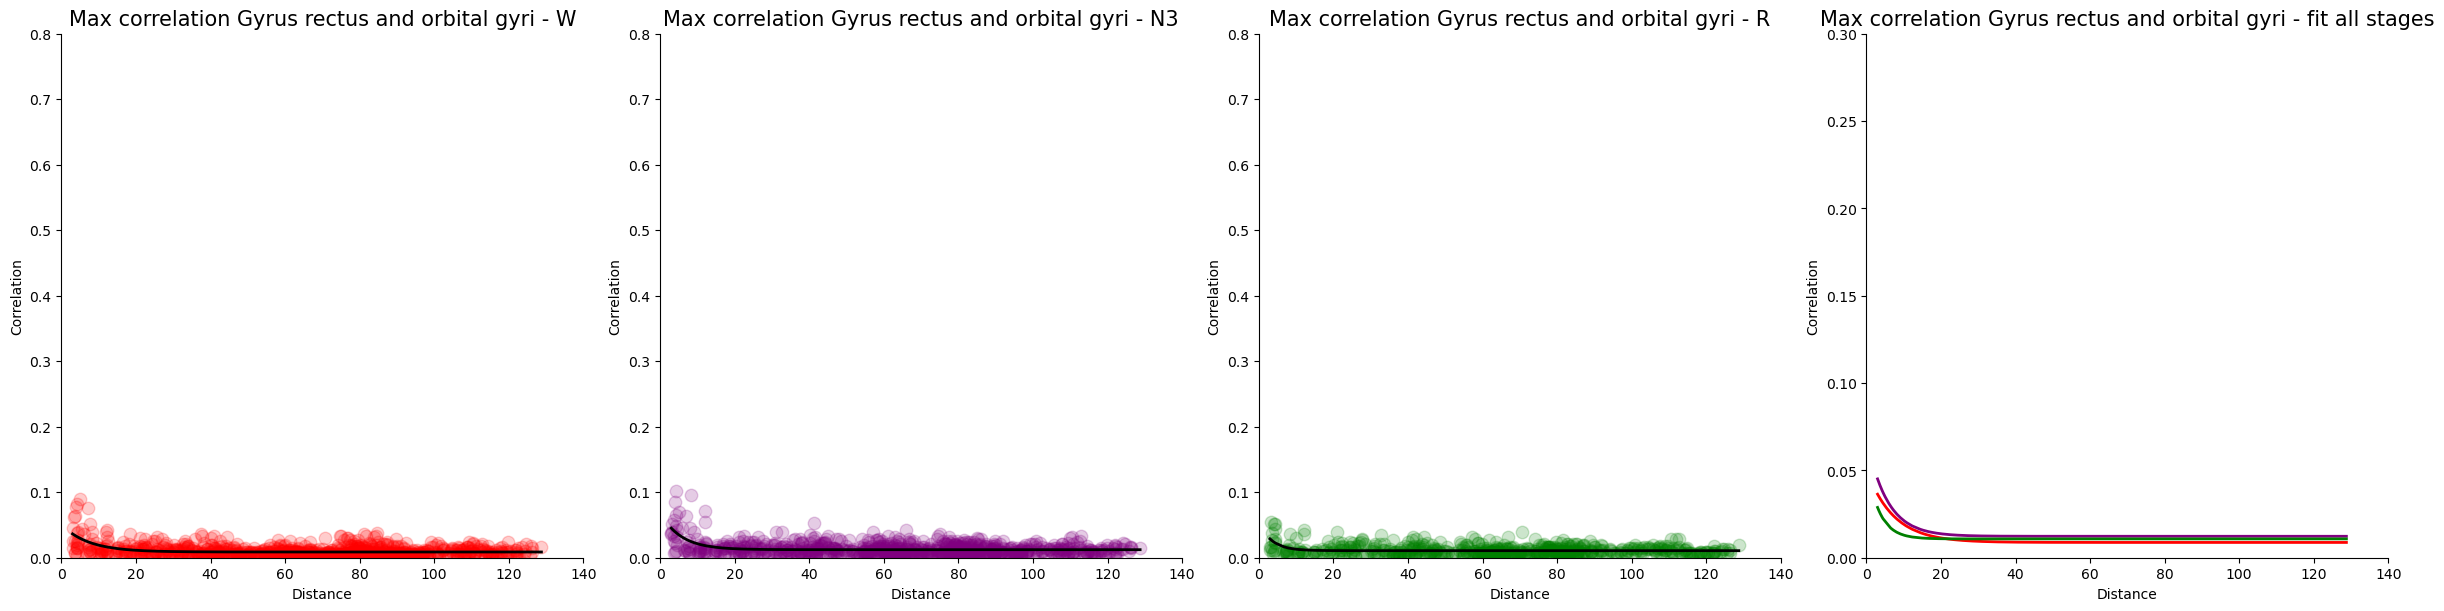

Amygdala
W [9.99999749e+01 1.21064486e-03 9.97750352e-03]
N3 [2.44373835 0.10602635 0.01377624]
R [2.82867164 0.0523341  0.01020779]


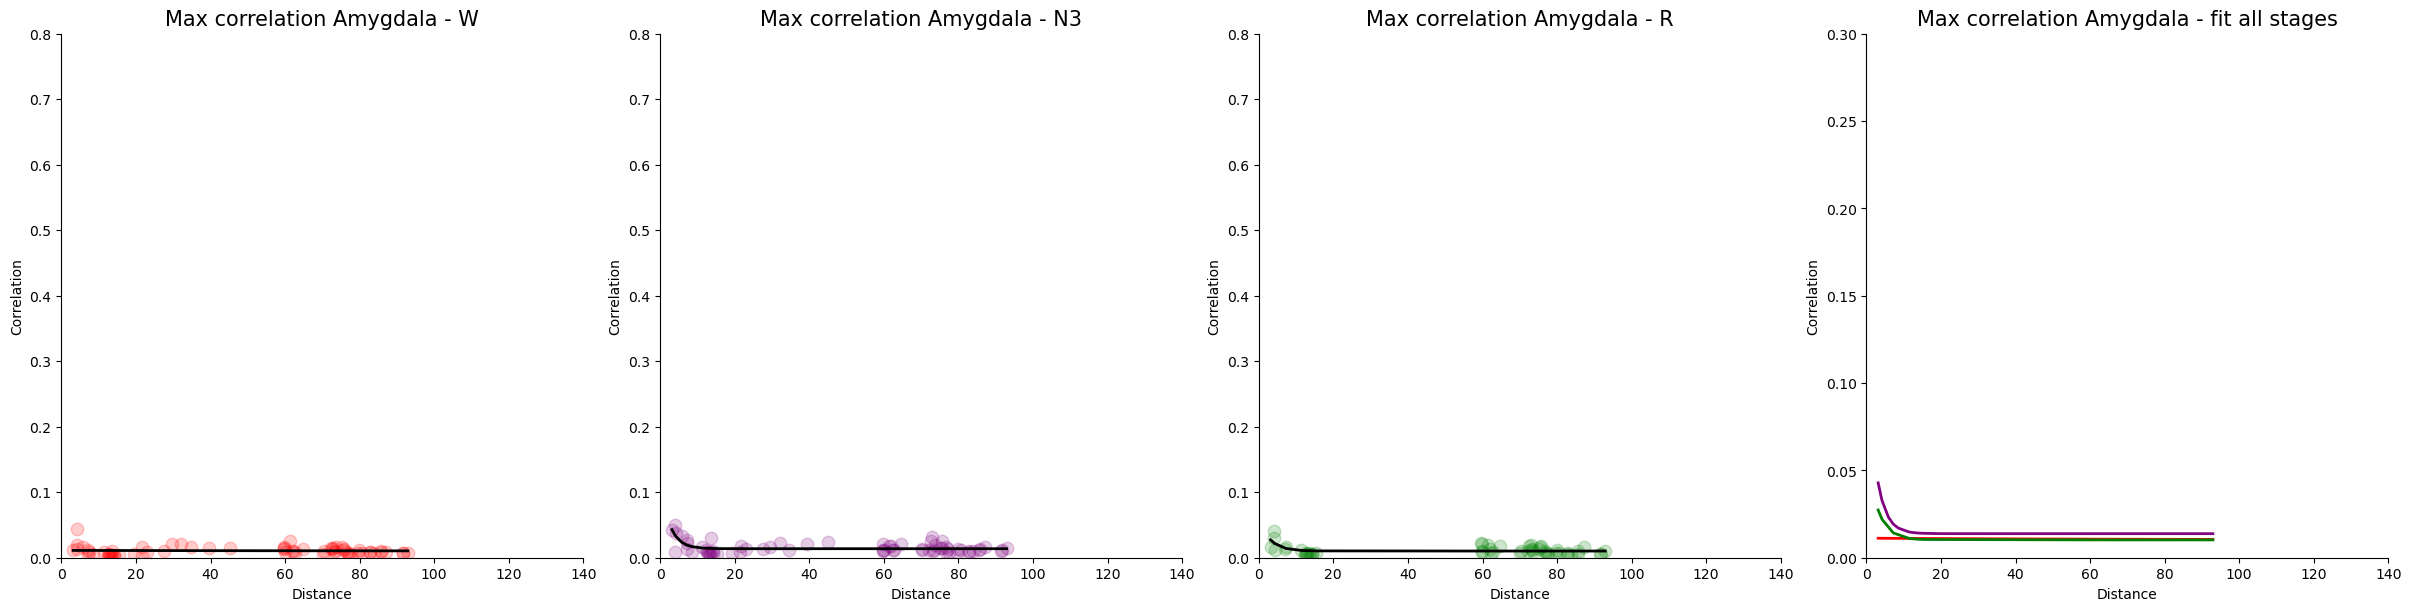

Inferior ocipital gyrus and occipital pole
W [4.83126879 0.10794903 0.00889971]
N3 [9.32376763 0.1148267  0.01125328]
R [9.00003406 0.0869172  0.01080808]


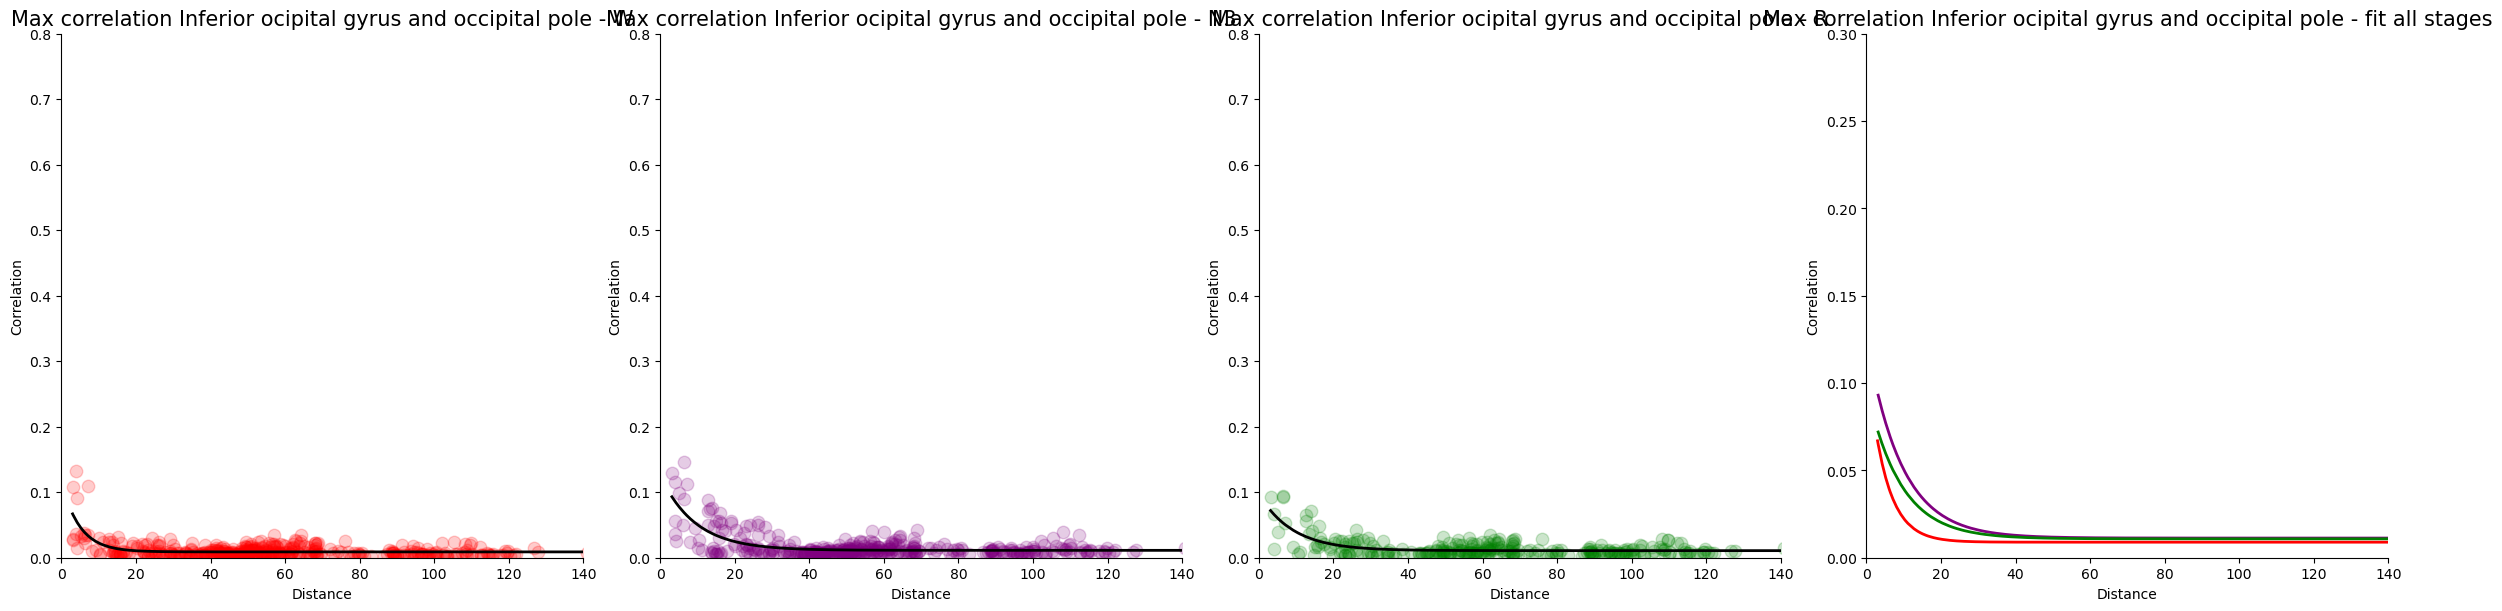

Calcarine cortex
W [7.18474508e+00 3.03340891e-02 7.08725070e-03]
N3 [1.49067462e+01 5.53455641e-02 1.07635987e-02]
R [1.28326656e+01 3.89552198e-02 1.09347155e-02]


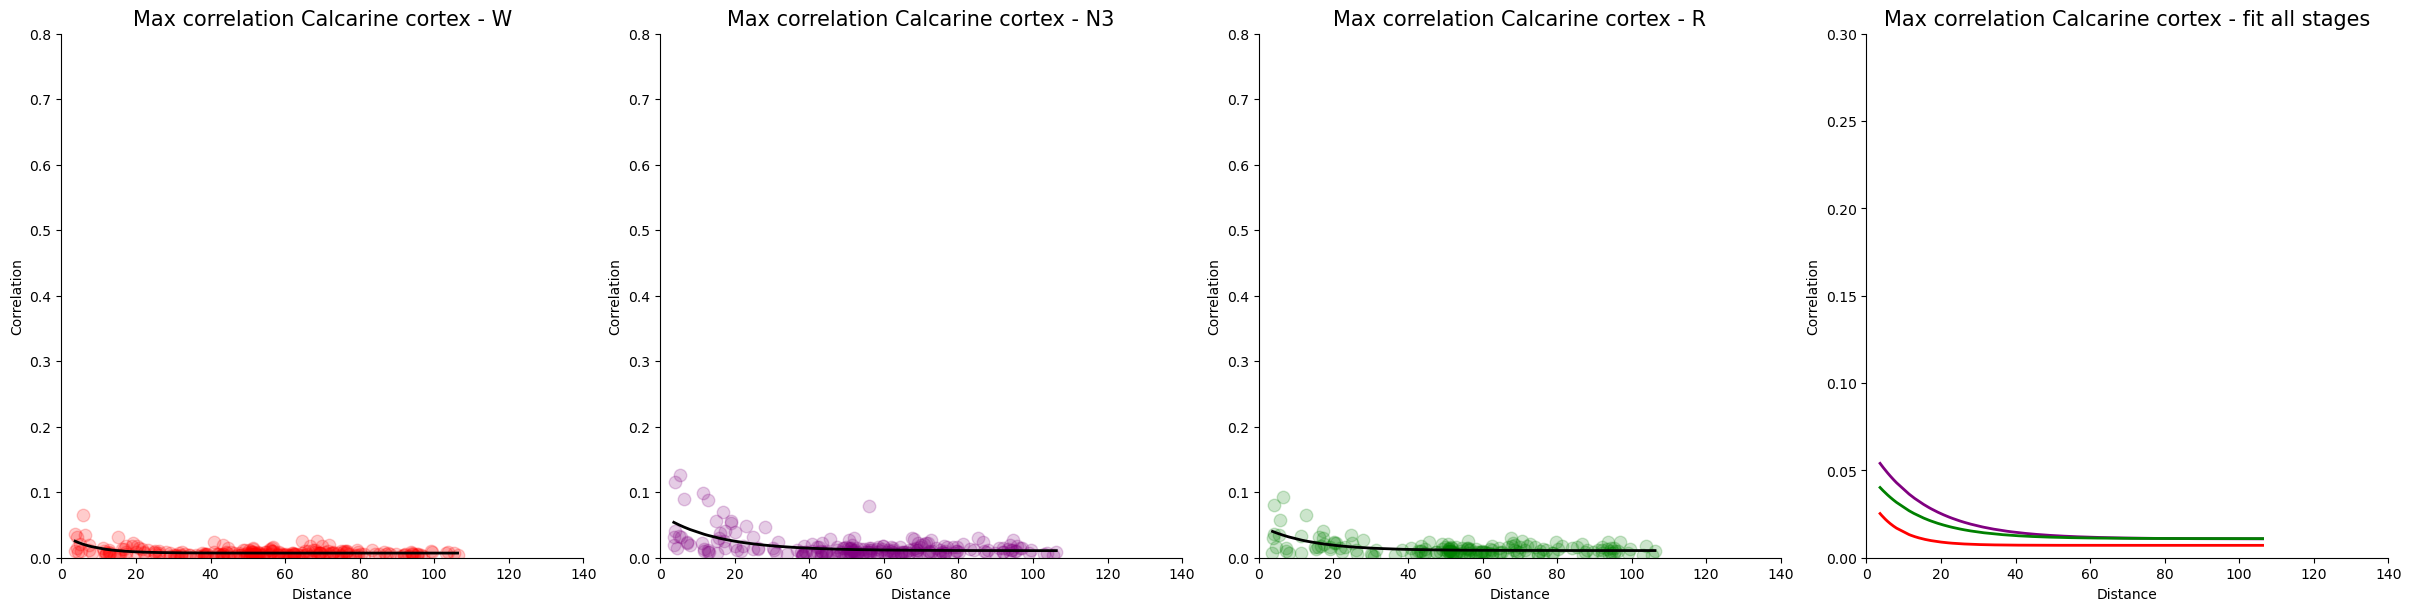

Superior and middle occipital gyri
W [9.63634673e+00 4.33704868e-02 6.39225625e-03]
N3 [9.50492824e+00 1.29269102e-01 6.94091884e-03]
R [1.12087092e+01 6.61674872e-02 4.50648299e-03]


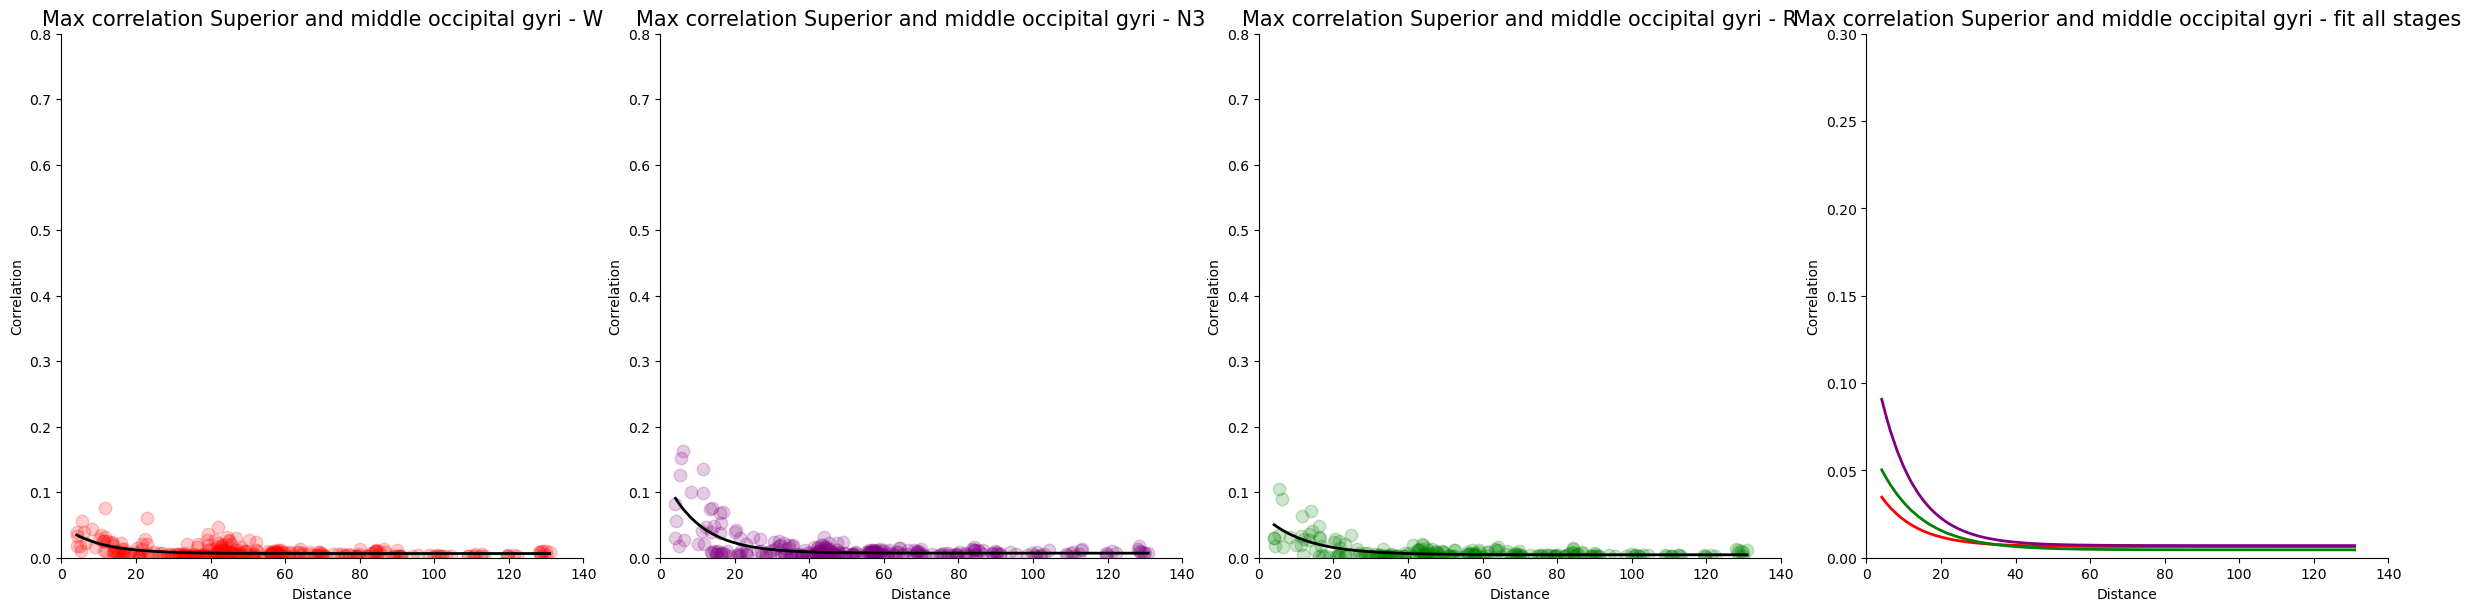

Cuneus
W [4.14768968e+01 7.55523471e-03 4.04242041e-03]
N3 [5.15376907e+01 1.35027821e-02 2.58717964e-03]
R [ 7.44445077e+01  1.29907591e-02 -9.43148416e-05]


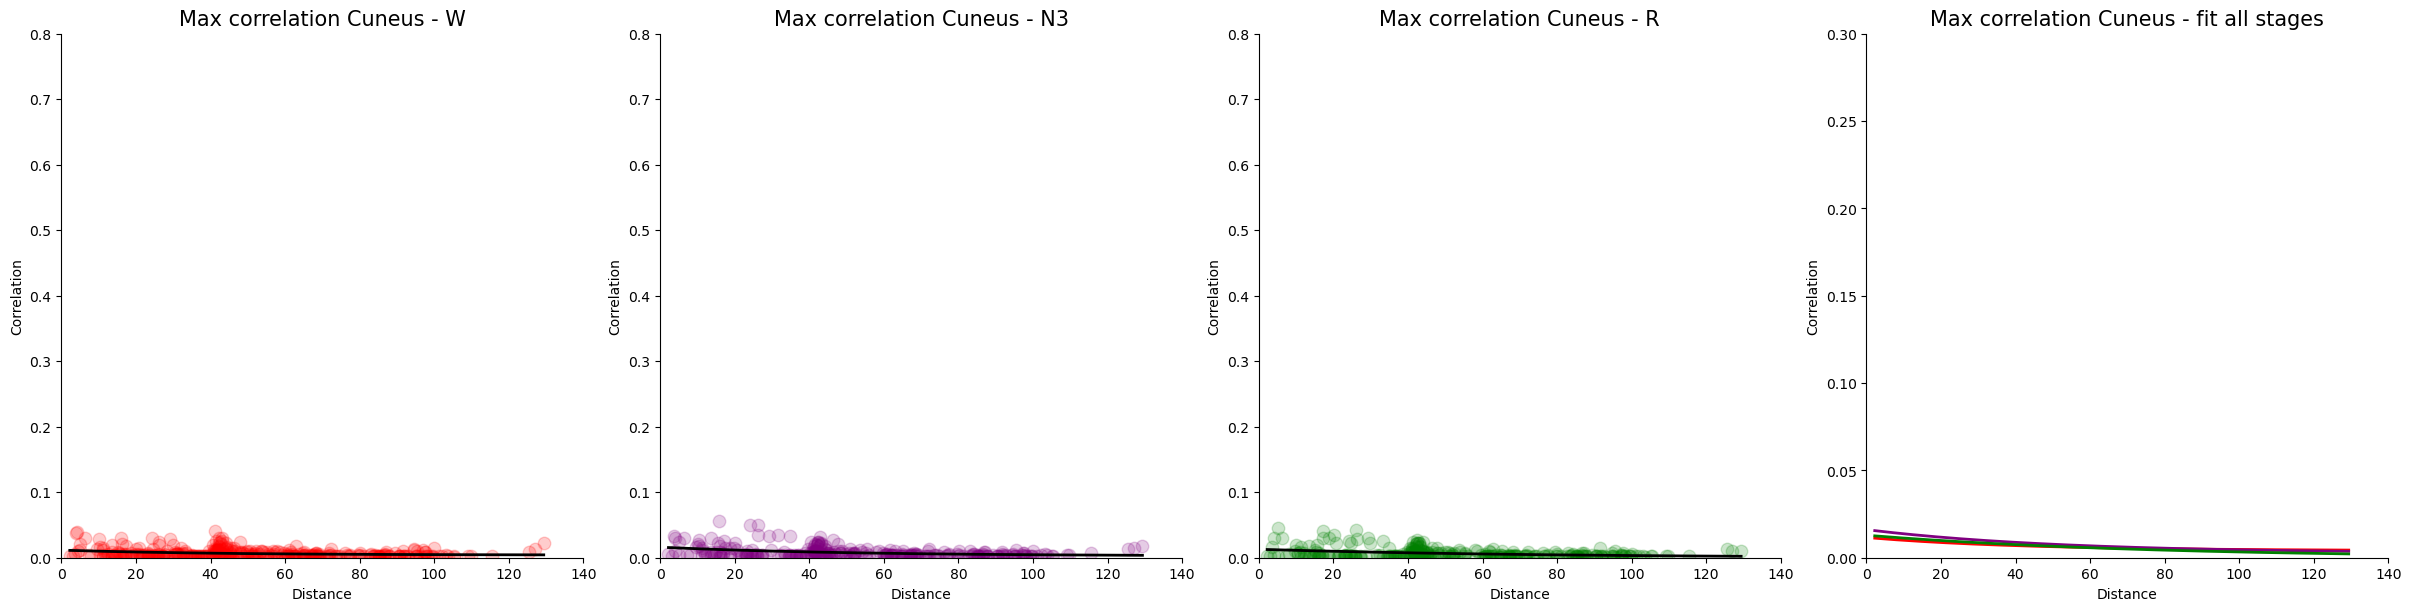

Orbital part of inferior frontal gyrus
W [7.06056489 0.06203249 0.01279853]
N3 [9.90016333 0.04179062 0.01700353]
R [9.56051286 0.03042539 0.01504677]


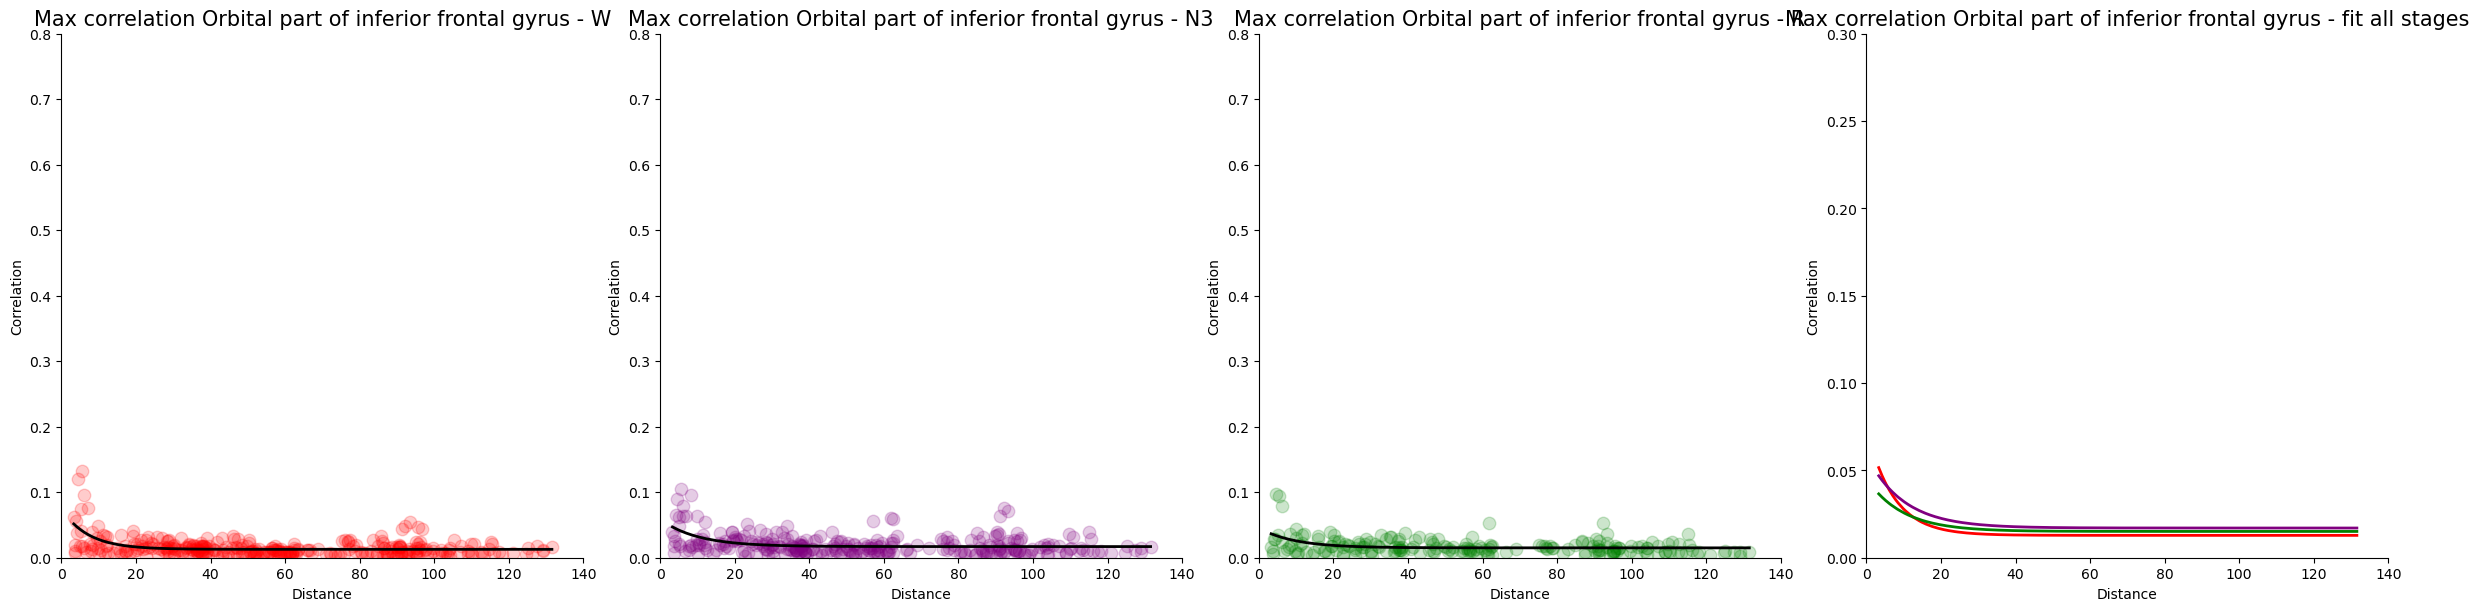

In [15]:
N = 20  # minimum number of points to fit
# Dataframe for storing parameters results
Regions = df_sc_stages["W"]["region1"].unique()
df_sc_params = pd.DataFrame(
    columns=["region", "stage", "k", "a", "b"], index=range(len(Regions) * 3)
)
idx_df = 0

for region in Regions:
    print(region)

    fig, axs = plt.subplots(1, 4, figsize=(24, 6), layout="constrained")

    for i, stage in enumerate(["W", "N3", "R"]):
        df_sc_stage_region = df_sc_stages[stage][
            (df_sc_stages[stage]["region1"] == region)
            | (df_sc_stages[stage]["region2"] == region)
        ]
        if len(df_sc_stage_region) < N:
            print(f"Skipping {region} - {stage}")
            df_sc_params.loc[idx_df, "region"] = region
            df_sc_params.loc[idx_df, "stage"] = stage
            df_sc_params.loc[idx_df, "k"] = np.nan
            df_sc_params.loc[idx_df, "a"] = np.nan
            df_sc_params.loc[idx_df, "b"] = np.nan
            idx_df += 1
            continue
        popt, pcov = curve_fit(
            uti._exp_decay,
            df_sc_stage_region["dist"],
            df_sc_stage_region["corr_max"],
            bounds=(([0, 0, -1], [100, 1, 1])),
        )
        print(stage, popt)
        # Update dataframe
        df_sc_params.loc[idx_df, "region"] = region
        df_sc_params.loc[idx_df, "stage"] = stage
        df_sc_params.loc[idx_df, "k"] = popt[0]
        df_sc_params.loc[idx_df, "a"] = popt[1]
        df_sc_params.loc[idx_df, "b"] = popt[2]
        idx_df += 1

        # Plot of data
        axs[i].plot(
            df_sc_stage_region["dist"],
            df_sc_stage_region["corr_max"],
            "o",
            c=colors_stage[stage],
            ms=9,
            alpha=0.2,
        )
        axs[i].plot(
            df_sc_stage_region["dist"].sort_values(),
            uti._exp_decay(df_sc_stage_region["dist"].sort_values(), *popt),
            "-",
            c="k",
            lw=2,
            zorder=9,
        )
        axs[i].set_ylim(0, 0.8)
        axs[i].set_xlim(0, 140)
        axs[i].set_xlabel("Distance", fontsize=10)
        axs[i].set_ylabel("Correlation", fontsize=10)
        axs[i].set_title(f"Max correlation {region} - {stage}", fontsize=15)
        axs[i].spines[["top", "right"]].set_visible(False)

        # Plot of fit
        axs[-1].plot(
            df_sc_stage_region["dist"].sort_values(),
            uti._exp_decay(df_sc_stage_region["dist"].sort_values(), *popt),
            "-",
            c=colors_stage[stage],
            lw=2,
        )
        axs[-1].set_ylim(0, 0.3)
        axs[-1].set_xlim(0, 140)
        axs[-1].set_xlabel("Distance", fontsize=10)
        axs[-1].set_ylabel("Correlation", fontsize=10)
        axs[-1].set_title(f"Max correlation {region} - fit all stages", fontsize=15)
        axs[-1].spines[["top", "right"]].set_visible(False)
    plt.show()

In [16]:
df_sc_params.to_csv(res_path.joinpath(f"SC_fit_params.csv"))
df_sc_params

region stage          k         a  \
0                     Middle temporal gyrus     W   9.057472  0.055383   
1                     Middle temporal gyrus    N3   8.879103  0.070995   
2                     Middle temporal gyrus     R  12.675451  0.036374   
3                     Medial frontal cortex     W   4.226238  0.041633   
4                     Medial frontal cortex    N3   1.981619  0.163845   
..                                      ...   ...        ...       ...   
109                                  Cuneus    N3  51.537691  0.013503   
110                                  Cuneus     R  74.444508  0.012991   
111  Orbital part of inferior frontal gyrus     W   7.060565  0.062032   
112  Orbital part of inferior frontal gyrus    N3   9.900163  0.041791   
113  Orbital part of inferior frontal gyrus     R   9.560513  0.030425   

            b  
0    0.010046  
1    0.013282  
2    0.009746  
3    0.014027  
4    0.016234  
..        ...  
109  0.002587  
110 -0.000094  
111  0.012799  
112  0.017004  
113  0.015047  

[114 rows x 5 columns]

In [7]:
df_sc_params = pd.read_csv(res_path.joinpath(f"SC_fit_params.csv"), index_col=0)

Plot:

In [17]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\ricca\AppData\Local\Temp\ipykernel_31700\2502189404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc_param_stage.sort_values(
C:\Users\ricca\AppData\Local\Temp\ipykernel_31700\2502189404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc_param_stage.sort_values(


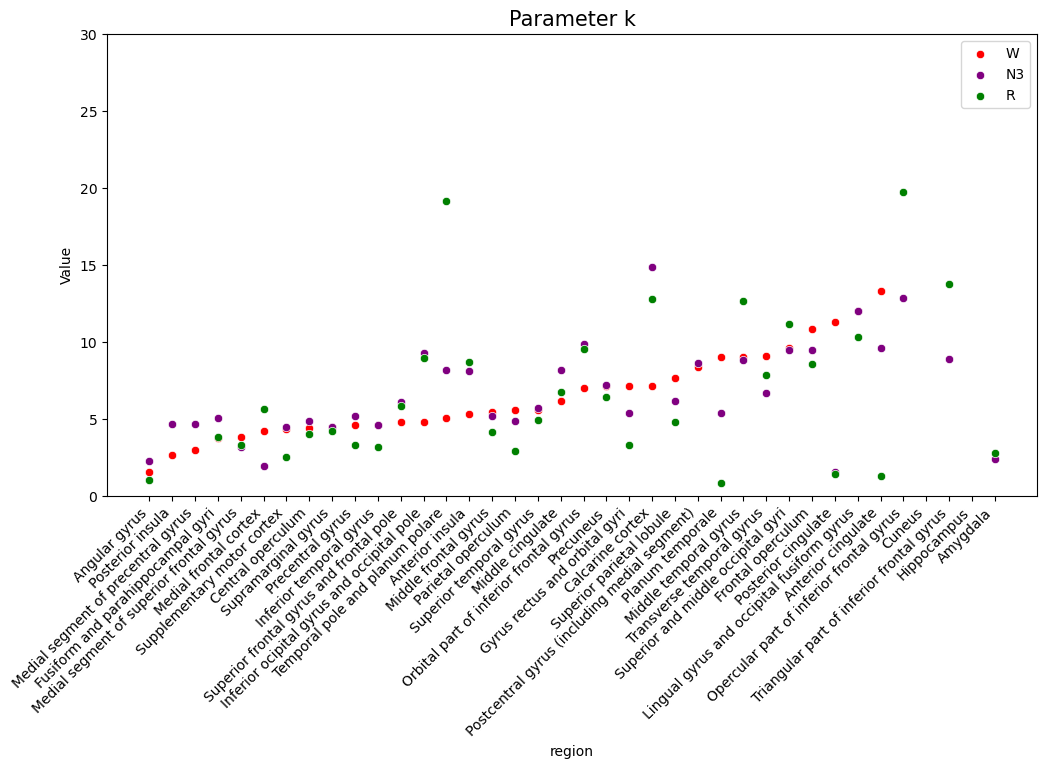

C:\Users\ricca\AppData\Local\Temp\ipykernel_31700\2502189404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc_param_stage.sort_values(
C:\Users\ricca\AppData\Local\Temp\ipykernel_31700\2502189404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc_param_stage.sort_values(


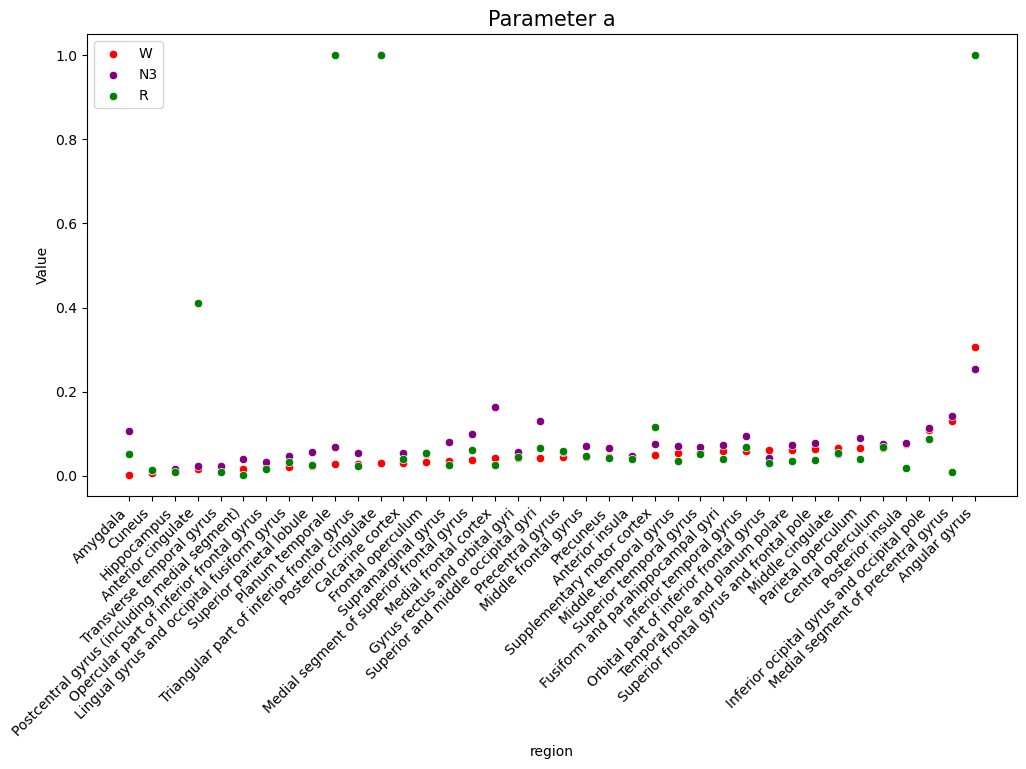

C:\Users\ricca\AppData\Local\Temp\ipykernel_31700\2502189404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc_param_stage.sort_values(
C:\Users\ricca\AppData\Local\Temp\ipykernel_31700\2502189404.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc_param_stage.sort_values(


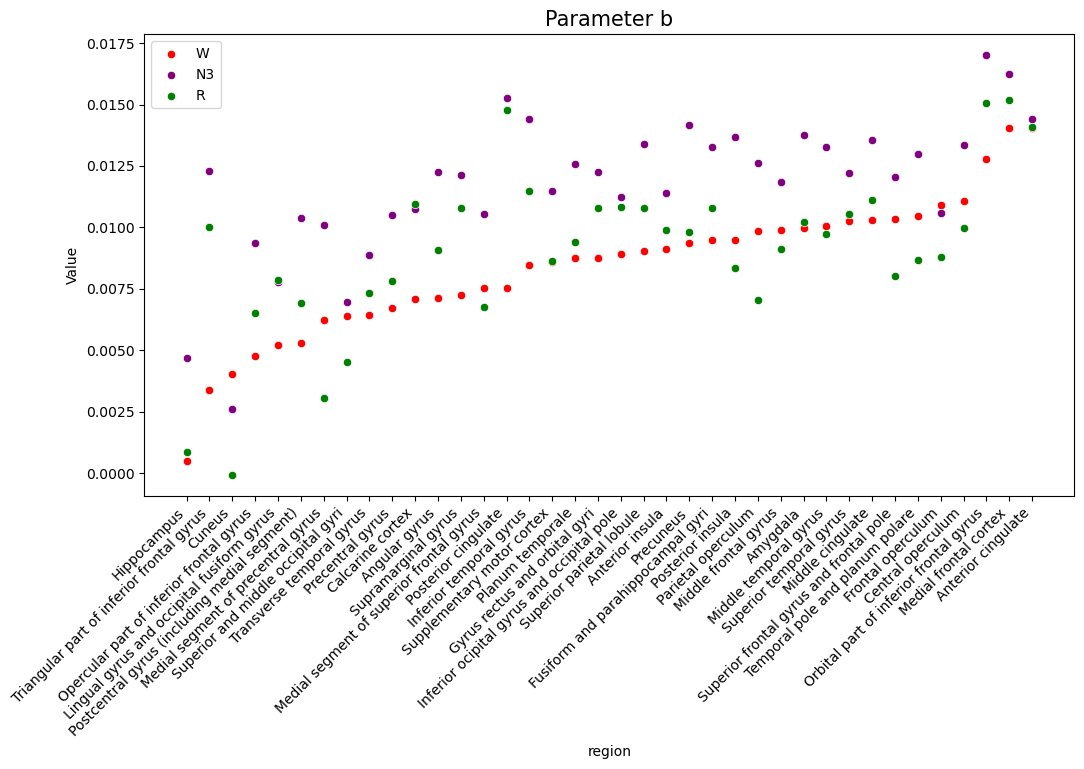

In [18]:
for param in ["k", "a", "b"]:
    fig, ax = plt.subplots(figsize=(12, 6))
    for stage in ["W", "N3", "R"]:
        df_sc_param_stage = df_sc_params[df_sc_params["stage"] == stage]
        # Set order from wake
        if stage == "W":
            df_sc_param_stage = df_sc_param_stage.sort_values(param)
            regions_order = df_sc_param_stage["region"].tolist()
        else:
            df_sc_param_stage.sort_values(
                by="region",
                key=lambda column: column.map(lambda e: regions_order.index(e)),
                inplace=True,
            )
        sns.scatterplot(
            x="region",
            y=param,
            data=df_sc_param_stage,
            c=colors_stage[stage],
            ax=ax,
            label=stage,
        )
    plt.xticks(rotation=45, ha="right")
    ax.set_ylabel("Value", fontsize=10)
    ax.set_title("Parameter " + param, fontsize=15)
    if param == "k":
        ax.set_ylim(0, 30)
    plt.show()

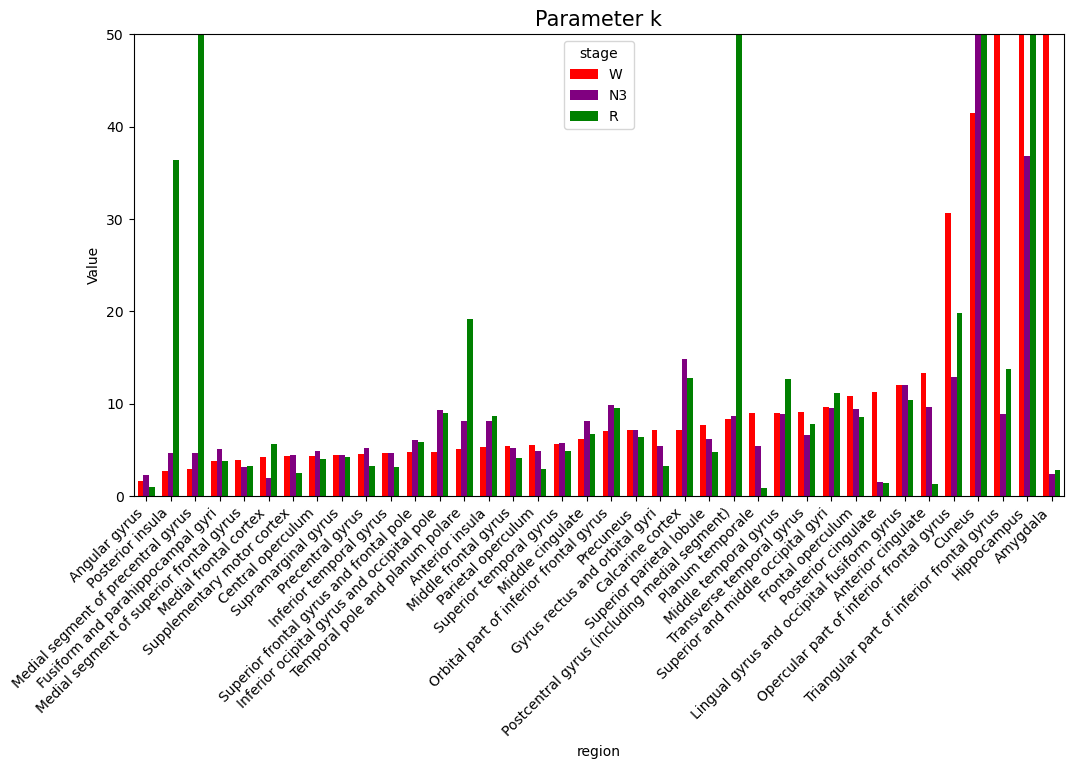

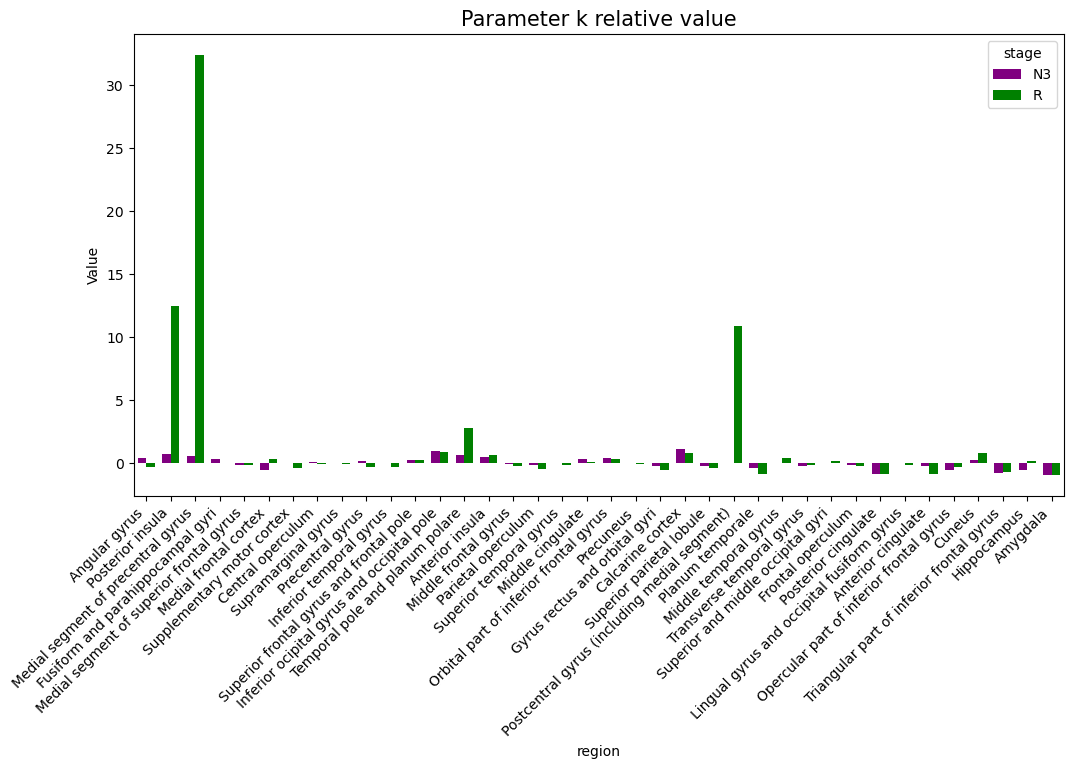

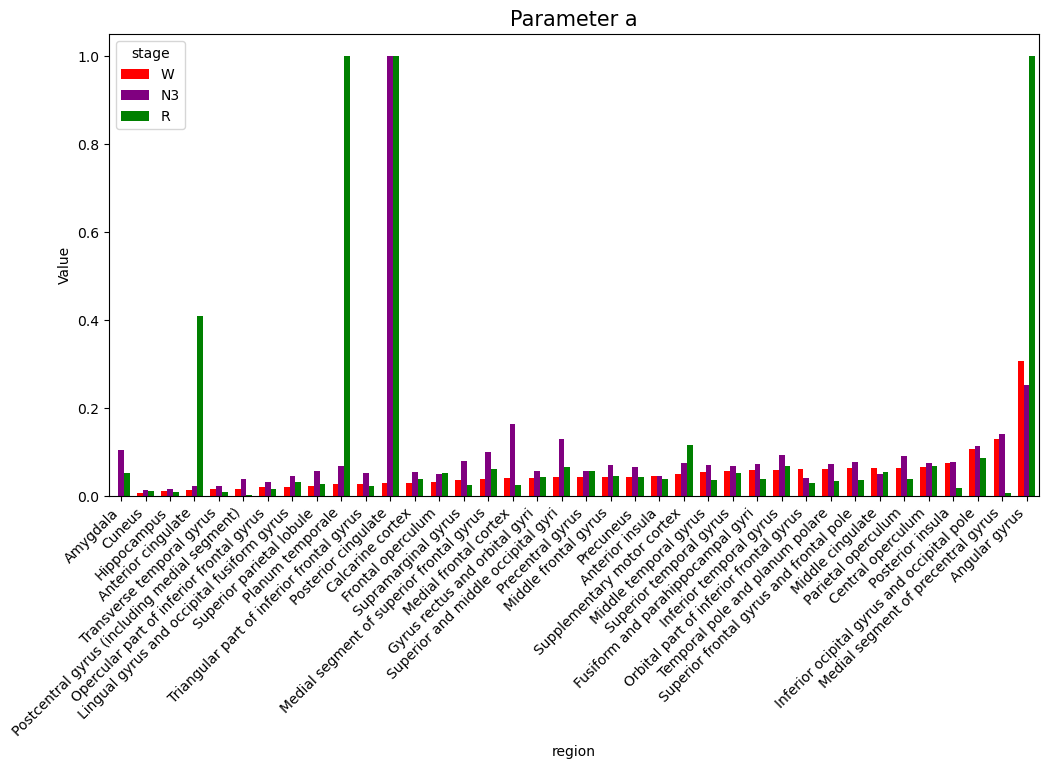

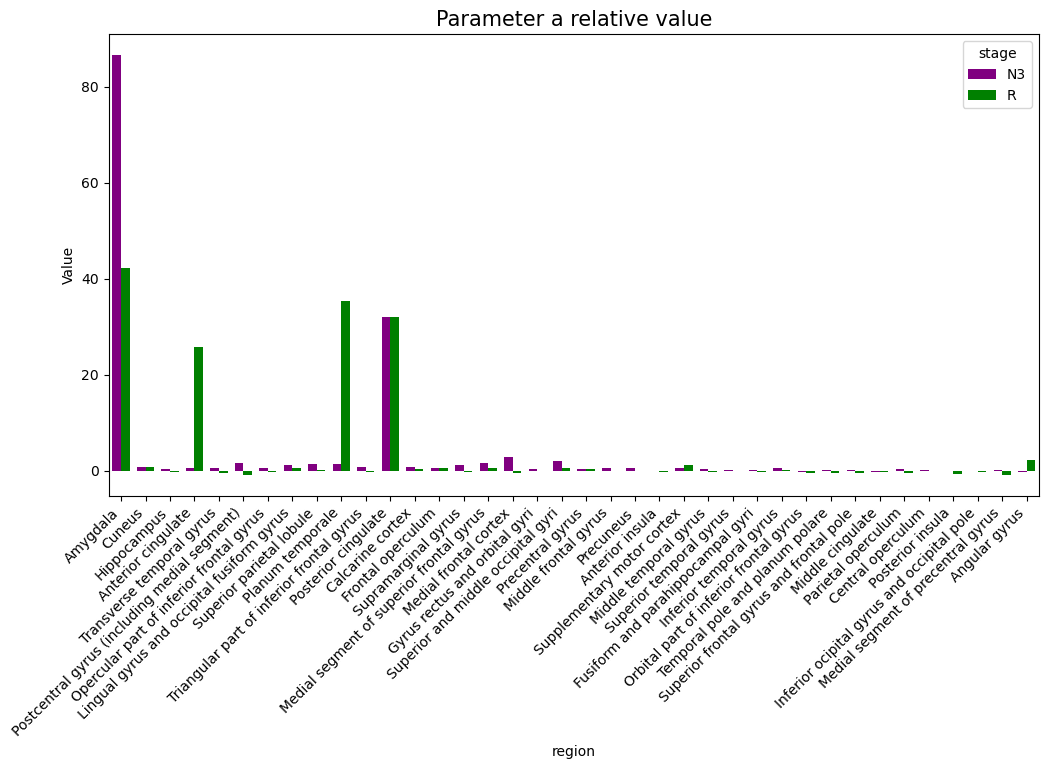

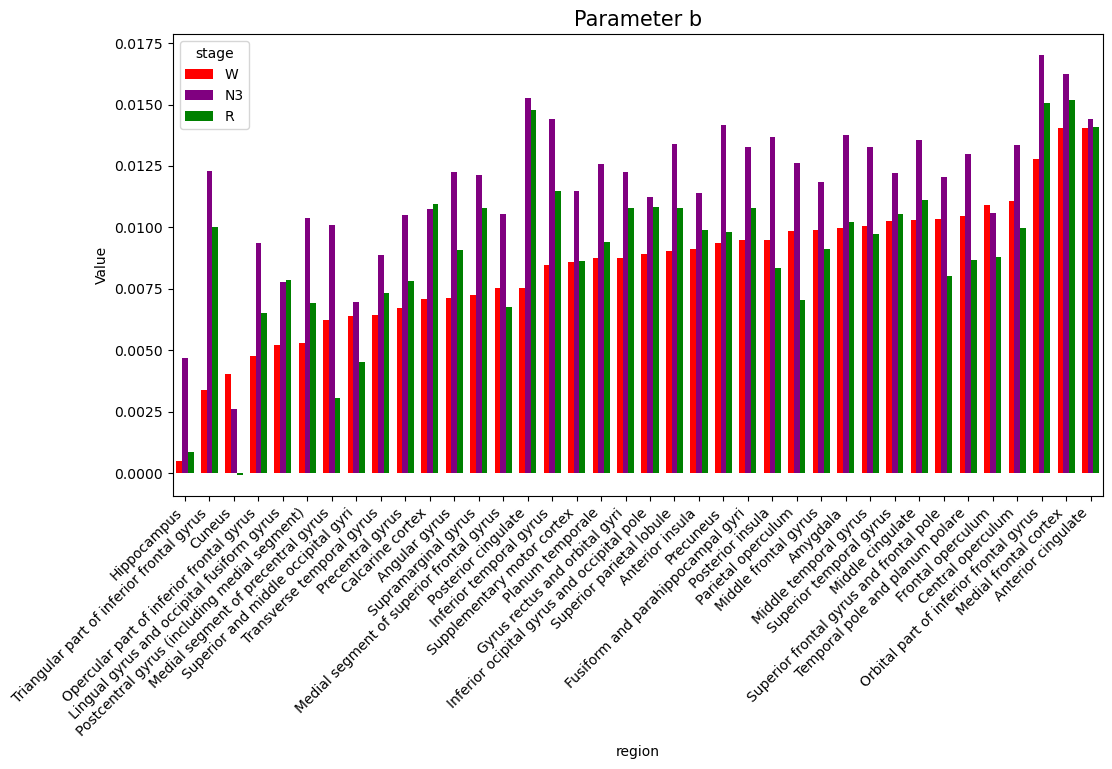

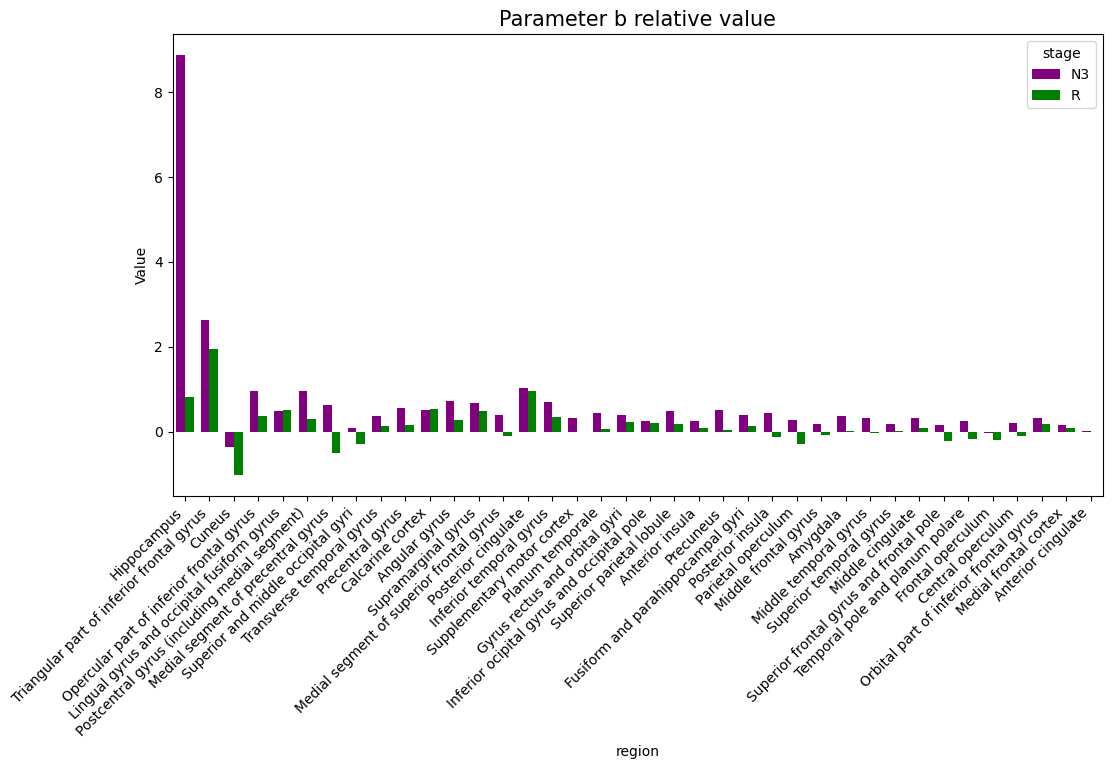

In [20]:
for param in ["k", "a", "b"]:
    # Figure with absolute values
    fig, ax = plt.subplots(figsize=(12, 6))
    regions_order = (
        df_sc_params[df_sc_params["stage"] == "W"].sort_values(param)["region"].tolist()
    )
    sns.barplot(
        x="region",
        y=param,
        data=df_sc_params,
        hue="stage",
        order=regions_order,
        hue_order=["W", "N3", "R"],
        errorbar=None,
        width=0.7,
        dodge=True,
        palette=colors_stage,
        saturation=1,
        ax=ax,
    )
    plt.xticks(rotation=45, ha="right")
    ax.set_ylabel("Value", fontsize=10)
    ax.set_title("Parameter " + param, fontsize=15)
    if param == "k":
        ax.set_ylim(0, 50)

    # Figure with relative values (to Wake)
    fig, ax = plt.subplots(figsize=(12, 6))
    df_plot_rel = pd.DataFrame(
        columns=["region", "stage", param], index=df_sc_params.index
    )
    for region in df_sc_params["region"].unique():
        df_plot_rel.loc[df_sc_params["region"] == region, "region"] = region
        df_plot_rel.loc[df_sc_params["region"] == region, "stage"] = df_sc_params.loc[
            df_sc_params["region"] == region, "stage"
        ]
        df_plot_rel.loc[df_sc_params["region"] == region, param] = (
            df_sc_params.loc[df_sc_params["region"] == region, param]
            / df_sc_params.loc[df_sc_params["region"] == region, param].iloc[0]
        ) - 1
    df_plot_rel.drop(index=df_plot_rel[df_plot_rel["stage"] == "W"].index, inplace=True)
    sns.barplot(
        x="region",
        y=param,
        data=df_plot_rel,
        hue="stage",
        order=regions_order,
        hue_order=["N3", "R"],
        errorbar=None,
        width=0.7,
        dodge=True,
        palette=colors_stage,
        saturation=1,
        ax=ax,
    )
    plt.xticks(rotation=45, ha="right")
    ax.set_ylabel("Value", fontsize=10)
    ax.set_title(f"Parameter {param} relative value", fontsize=15)

    plt.show()

### Correlation with timescales

In [8]:
df_tau = pd.read_csv(base_path.joinpath("Results_gamma/all_tau.csv"), index_col=0)

In [9]:
df_tau.shape

(6079, 11)

W k
Linregress LinregressResult(slope=0.03938640132263698, intercept=27.763462951263488, rvalue=0.33597758102447567, pvalue=0.0391794552218216, stderr=0.018402452645140427, intercept_stderr=0.46857276301026973)
Spearman SignificanceResult(statistic=0.17496443812233284, pvalue=0.29341686503812725)
W a
Linregress LinregressResult(slope=0.2585548675892495, intercept=28.295196034676447, rvalue=0.005073912972742994, pvalue=0.9758812150554299, stderr=8.492838458269, intercept_stderr=0.6037473692370606)
Spearman SignificanceResult(statistic=0.018054491738702265, pvalue=0.9143239675169044)
W b
Linregress LinregressResult(slope=-241.45607418438348, intercept=30.337646738510383, rvalue=-0.26480435456503626, pvalue=0.1081281827660623, stderr=146.54631467826263, intercept_stderr=1.2957323146250401)
Spearman SignificanceResult(statistic=-0.19728635518109205, pvalue=0.2351325183034733)


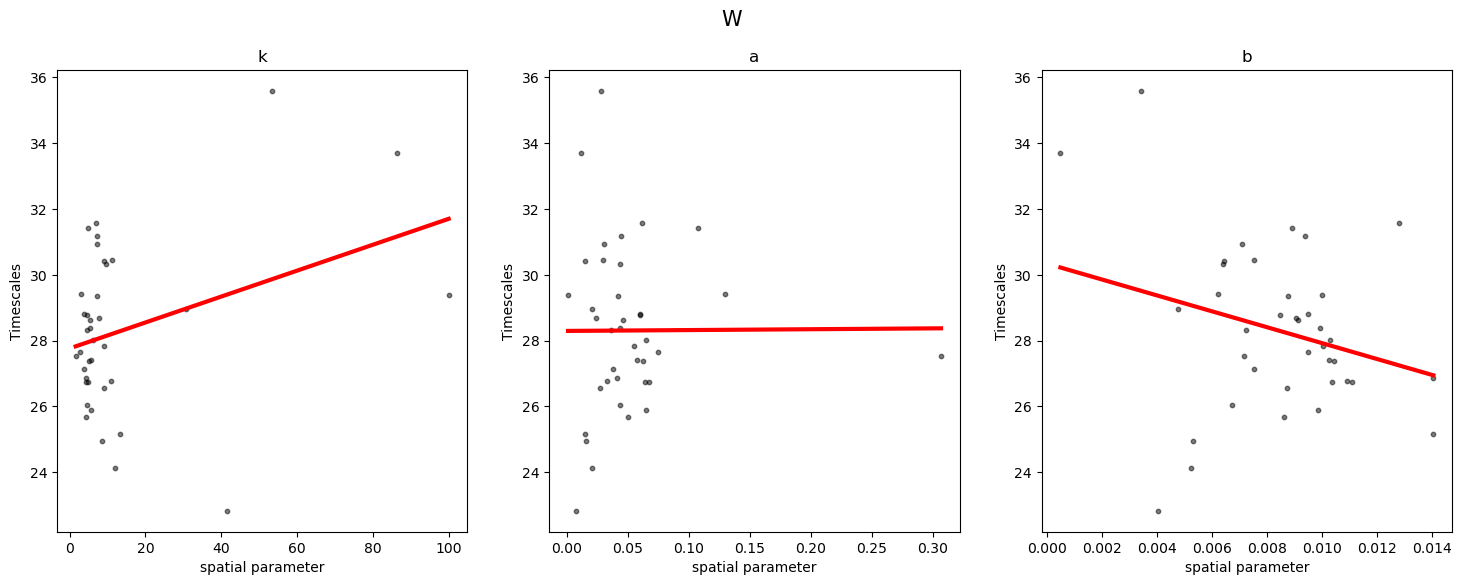

N3 k
Linregress LinregressResult(slope=0.5482068786414361, intercept=54.46579521565712, rvalue=0.3259094841236257, pvalue=0.04584459950435328, stderr=0.26504052206631556, intercept_stderr=3.3190412856039355)
Spearman SignificanceResult(statistic=0.16205274100010944, pvalue=0.331033222747837)
N3 a
Linregress LinregressResult(slope=25.808550750656696, intercept=56.67781670647905, rvalue=0.26233662603780467, pvalue=0.1115780304446077, stderr=15.822319165189741, intercept_stderr=2.8986718495353236)
Spearman SignificanceResult(statistic=0.20647773279352225, pvalue=0.21359143008905915)
N3 b
Linregress LinregressResult(slope=-2077.9732840094384, intercept=83.61676130086423, rvalue=-0.38564465853410823, pvalue=0.01679448105284936, stderr=828.5851471892378, intercept_stderr=10.005483956849266)
Spearman SignificanceResult(statistic=-0.18459350038297406, pvalue=0.2672289952065507)


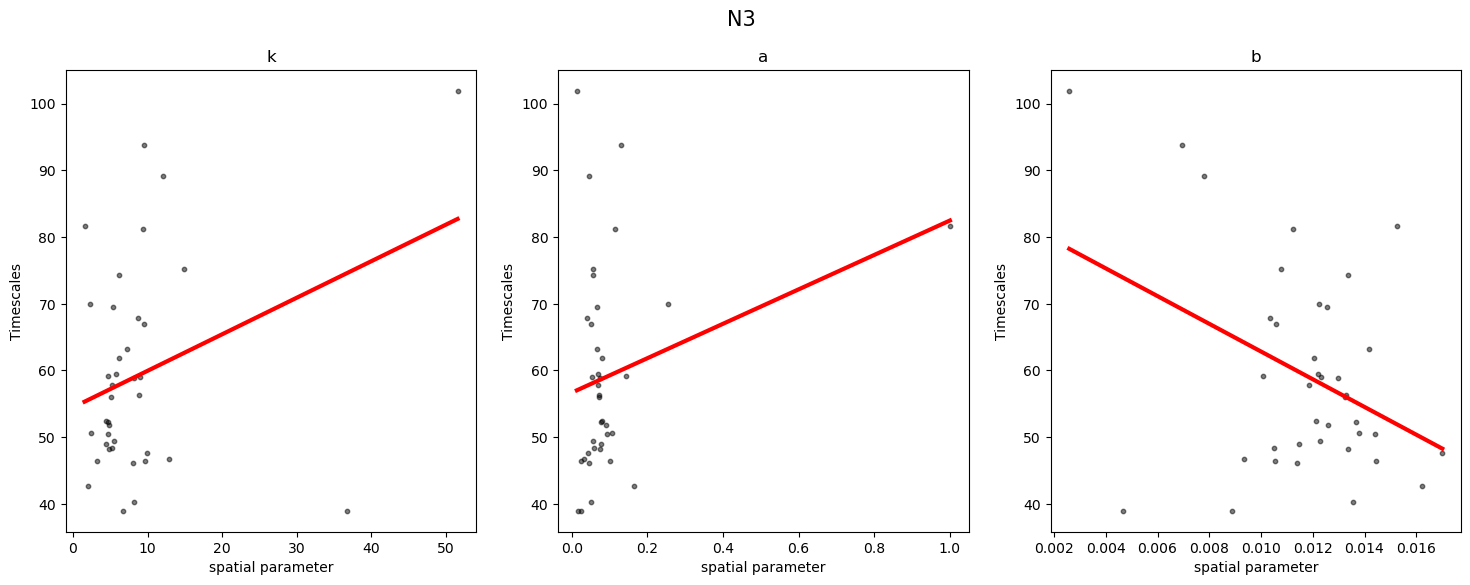

R k
Linregress LinregressResult(slope=-0.005464169734656417, intercept=30.20418566494464, rvalue=-0.027963484603559248, pvalue=0.8676433956536976, stderr=0.03255455595543971, intercept_stderr=1.0442129917025342)
Spearman SignificanceResult(statistic=0.09664003733759002, pvalue=0.5638161795021841)
R a
Linregress LinregressResult(slope=-0.5239264551106607, intercept=30.179459919173112, rvalue=-0.025755064212462687, pvalue=0.8780145334704946, stderr=3.3893182821803265, intercept_stderr=0.9902221549414473)
Spearman SignificanceResult(statistic=0.10931174089068825, pvalue=0.5135660171571469)
R b
Linregress LinregressResult(slope=-207.78444184912513, intercept=32.002652131373516, rvalue=-0.12627248805257577, pvalue=0.4499940447201398, stderr=272.05880185605815, intercept_stderr=2.6276800846480697)
Spearman SignificanceResult(statistic=-0.13207134259765838, pvalue=0.4292840124711672)


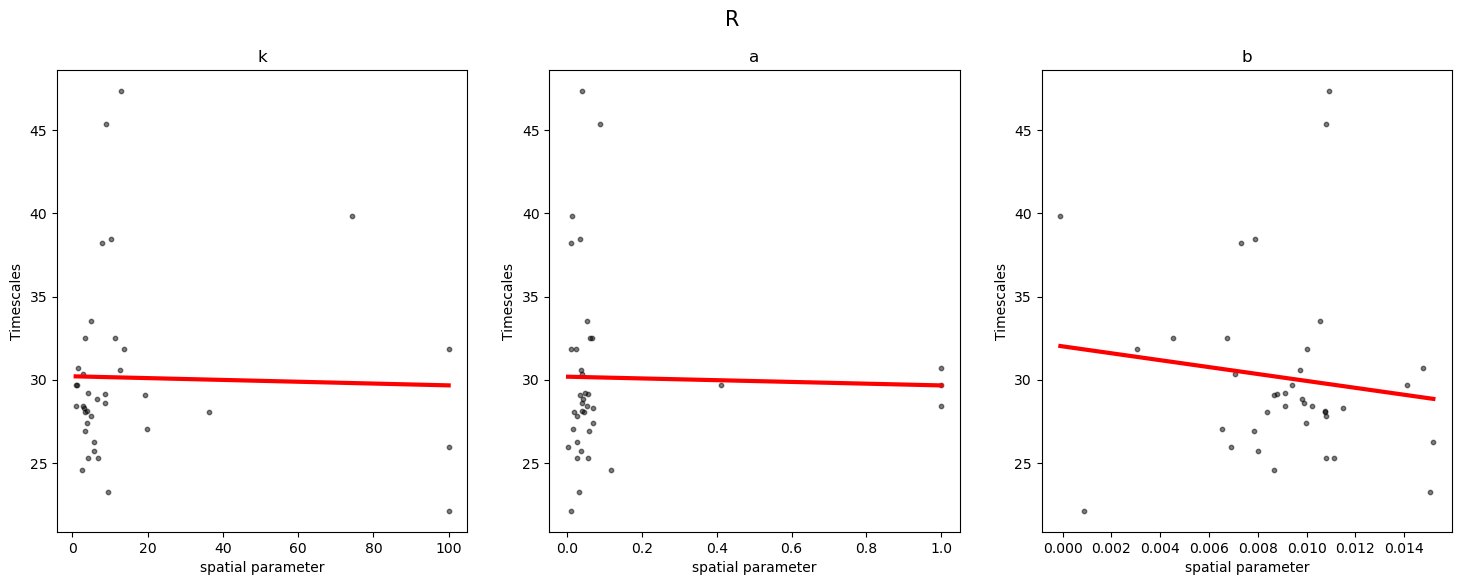

In [10]:
from scipy.stats import linregress, spearmanr
import statsmodels.formula.api as smf

for stage in ["W", "N3", "R"]:

    # Compute timescale per region
    data = df_tau[df_tau["stage"] == stage].copy()
    data.dropna(inplace=True)
    md = smf.mixedlm("tau ~ 0 + region", data, groups=data["pat"])
    mdf = md.fit()
    df_tau_stage = mdf.fe_params
    df_tau_stage.index = df_tau_stage.index.str.strip("region[").str.strip("]")

    # df_tau_stage = df_tau[df_tau["stage"] == stage]
    # df_tau_stage = df_tau_stage[["region", "tau"]].groupby("region").mean()
    plt.figure(figsize=[18,6])
    plt.suptitle(stage, fontsize=15)
    for i, param in enumerate(["k", "a", "b"]):

        df_spa = df_sc_params[df_sc_params["stage"] == stage].set_index("region")[param].astype(float)
        x = df_spa.loc[df_tau_stage.index].to_numpy()
        y = df_tau_stage.to_numpy().squeeze()
        res = linregress(x, y)
        print(stage, param)
        print("Linregress", res)
        print("Spearman", spearmanr(x, y))

        plt.subplot(1, 3, i+1)
        plt.scatter(x, y, c="k", alpha=0.5, s=10)
        plt.plot(
            [x.min(), x.max()],
            [
                res.intercept + res.slope * x.min(),
                res.intercept + res.slope * x.max(),
            ],
            "r",
            linewidth=3,
        )
        # plt.ylim(0, 200)
        plt.xlabel("spatial parameter")
        plt.ylabel("Timescales")
        plt.title(param)
    plt.show()